Проект посвящен изучению GAN сетей, решающих некоторые задачи из физики.
Космические частицы, такие как $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой, вызывая образование ливней вторичных частиц. Эти частицы двигаются со скоростью, близкой к скорости света, и излучают Черенковское излучение. Атмосферные черенковские телескопы фотографируют это излучение.

Задача таких телескопов заключается в получении изображения ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор, а для его анализа используются параметры Хилласа.

Изображения, полученные для $\gamma$-квантов (фотонов) и адронов (протонов), имеют различные формы кластеров. Астрономы применяют модели машинного обучения для классификации этих изображений, при этом сбор каждого изображения является затратным процессом.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [ ]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("/content/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


Задача состоит в том, чтобы с помощью GAN научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [ ]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

# Визуализация данных

Каждое изображение описывается 10 параметрами, построим распределения значений каждого параметра для каждого типа частиц.

In [ ]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

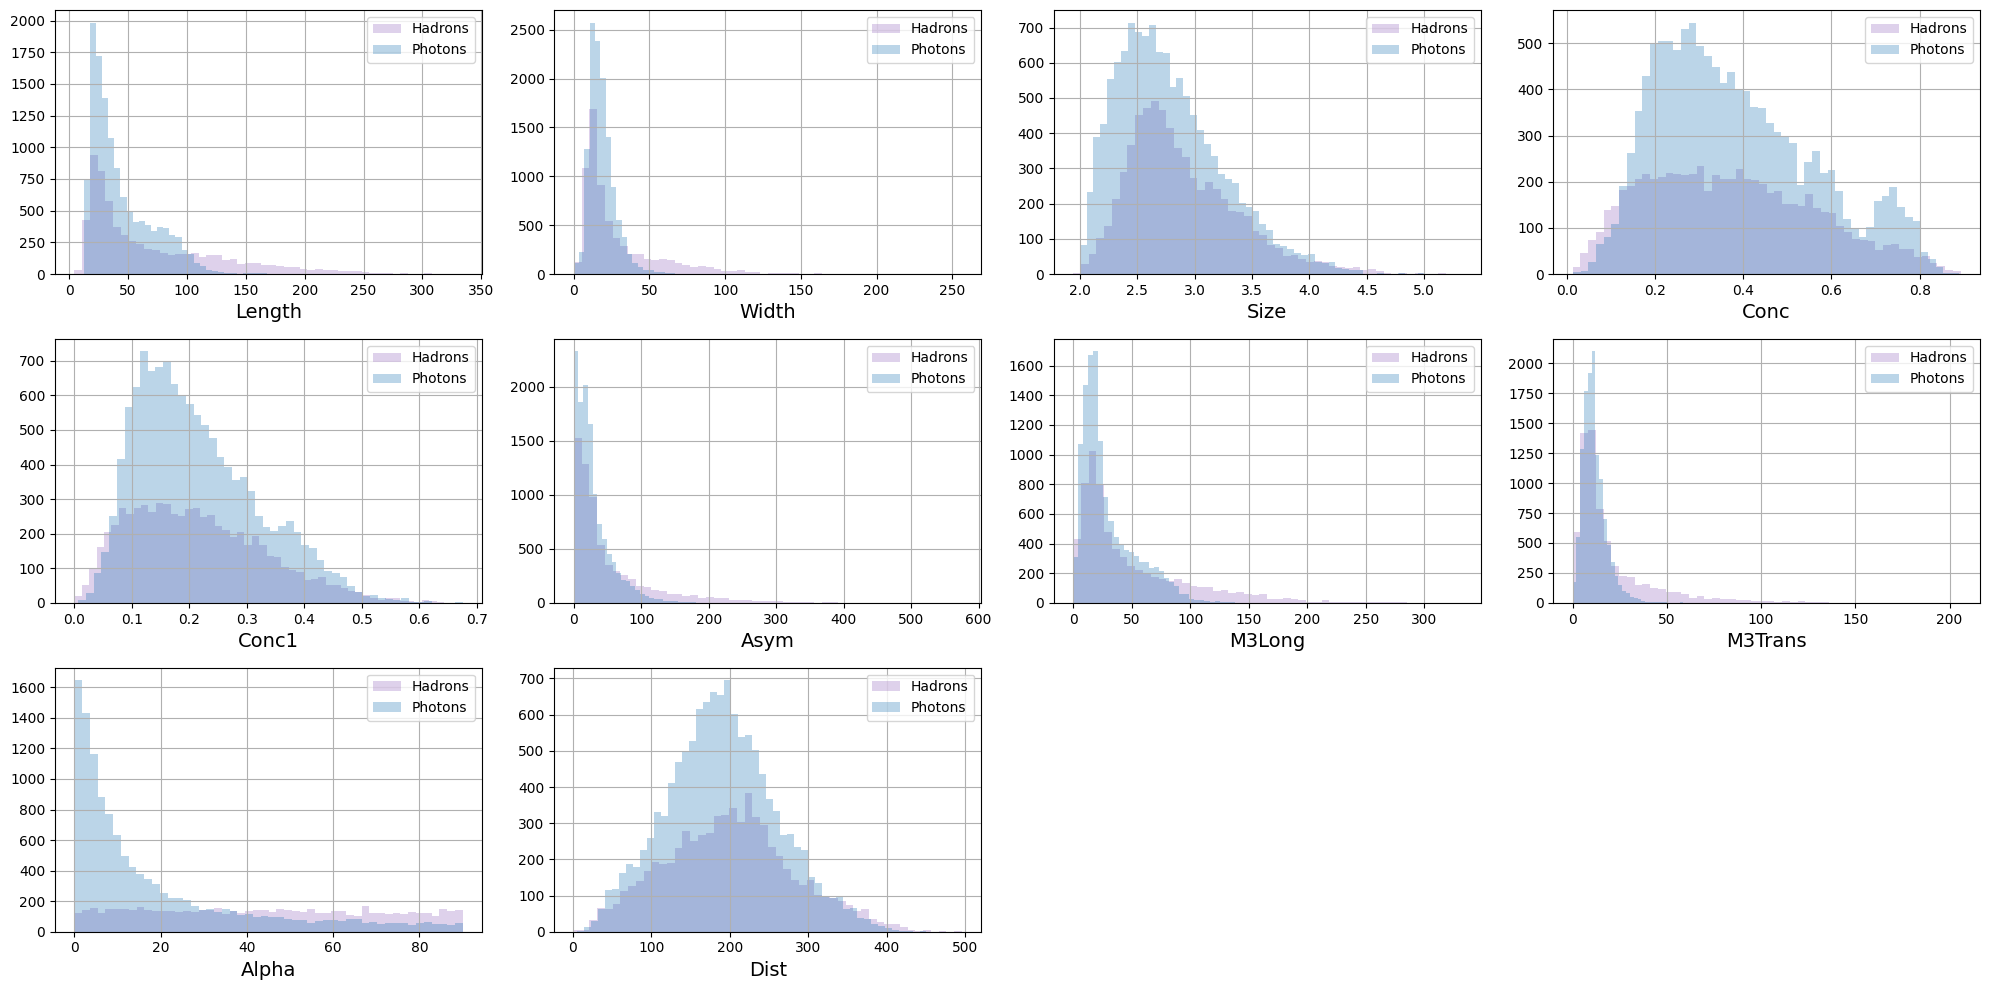

In [ ]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты.

# Обучающая и тестовая выборки

In [ ]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

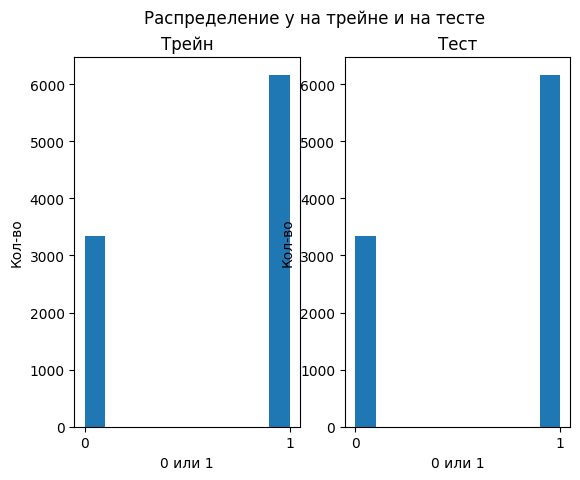

In [ ]:
f, a = plt.subplots(1, 2)

a[0].hist(y_train)
a[0].set_xticks([0, 1])
a[0].set_xlabel('0 или 1')
a[0].set_ylabel('Кол-во')
a[0].set_title('Трейн')

a[1].hist(y_test)
a[1].set_xticks([0, 1])
a[1].set_xlabel('0 или 1')
a[1].set_ylabel('Кол-во')
a[1].set_title('Тест')

f.suptitle('Распределение y на трейне и на тесте')
plt.show()

Преобразуем входные данные

In [ ]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal', random_state=0)

X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)

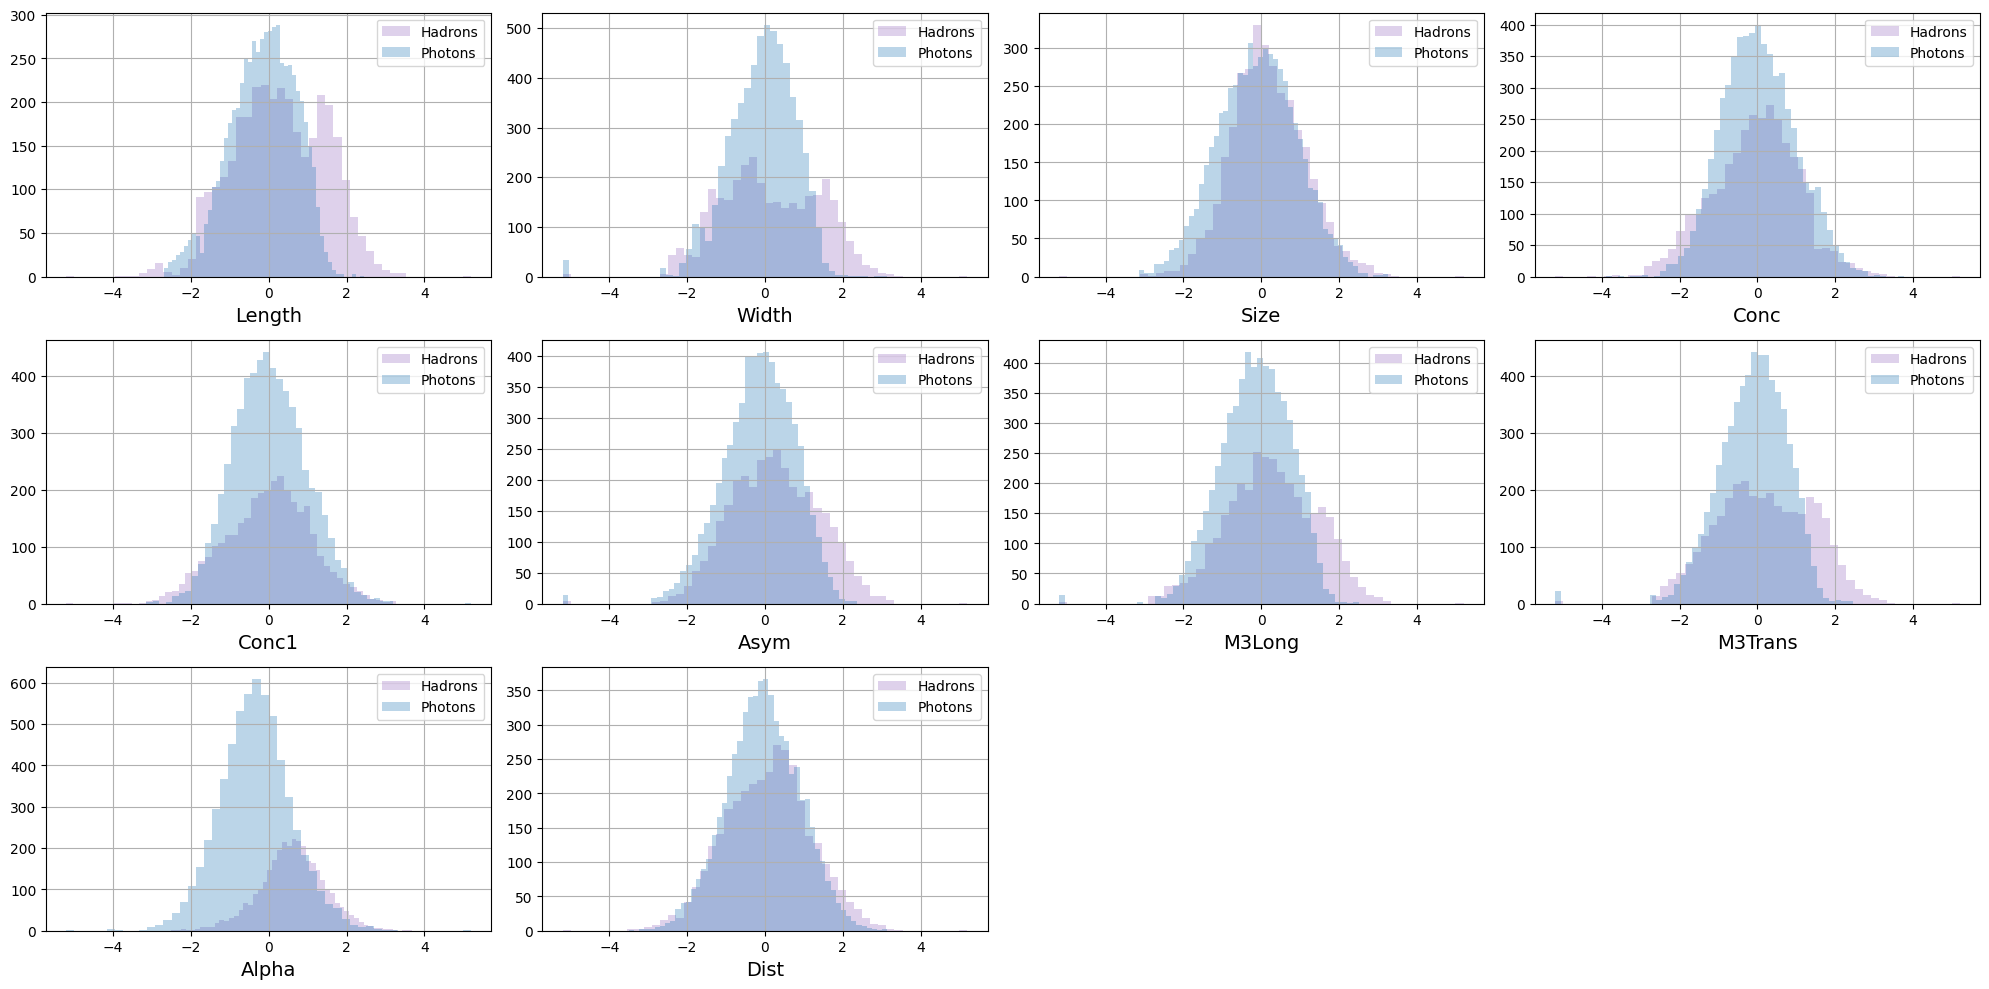

In [ ]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

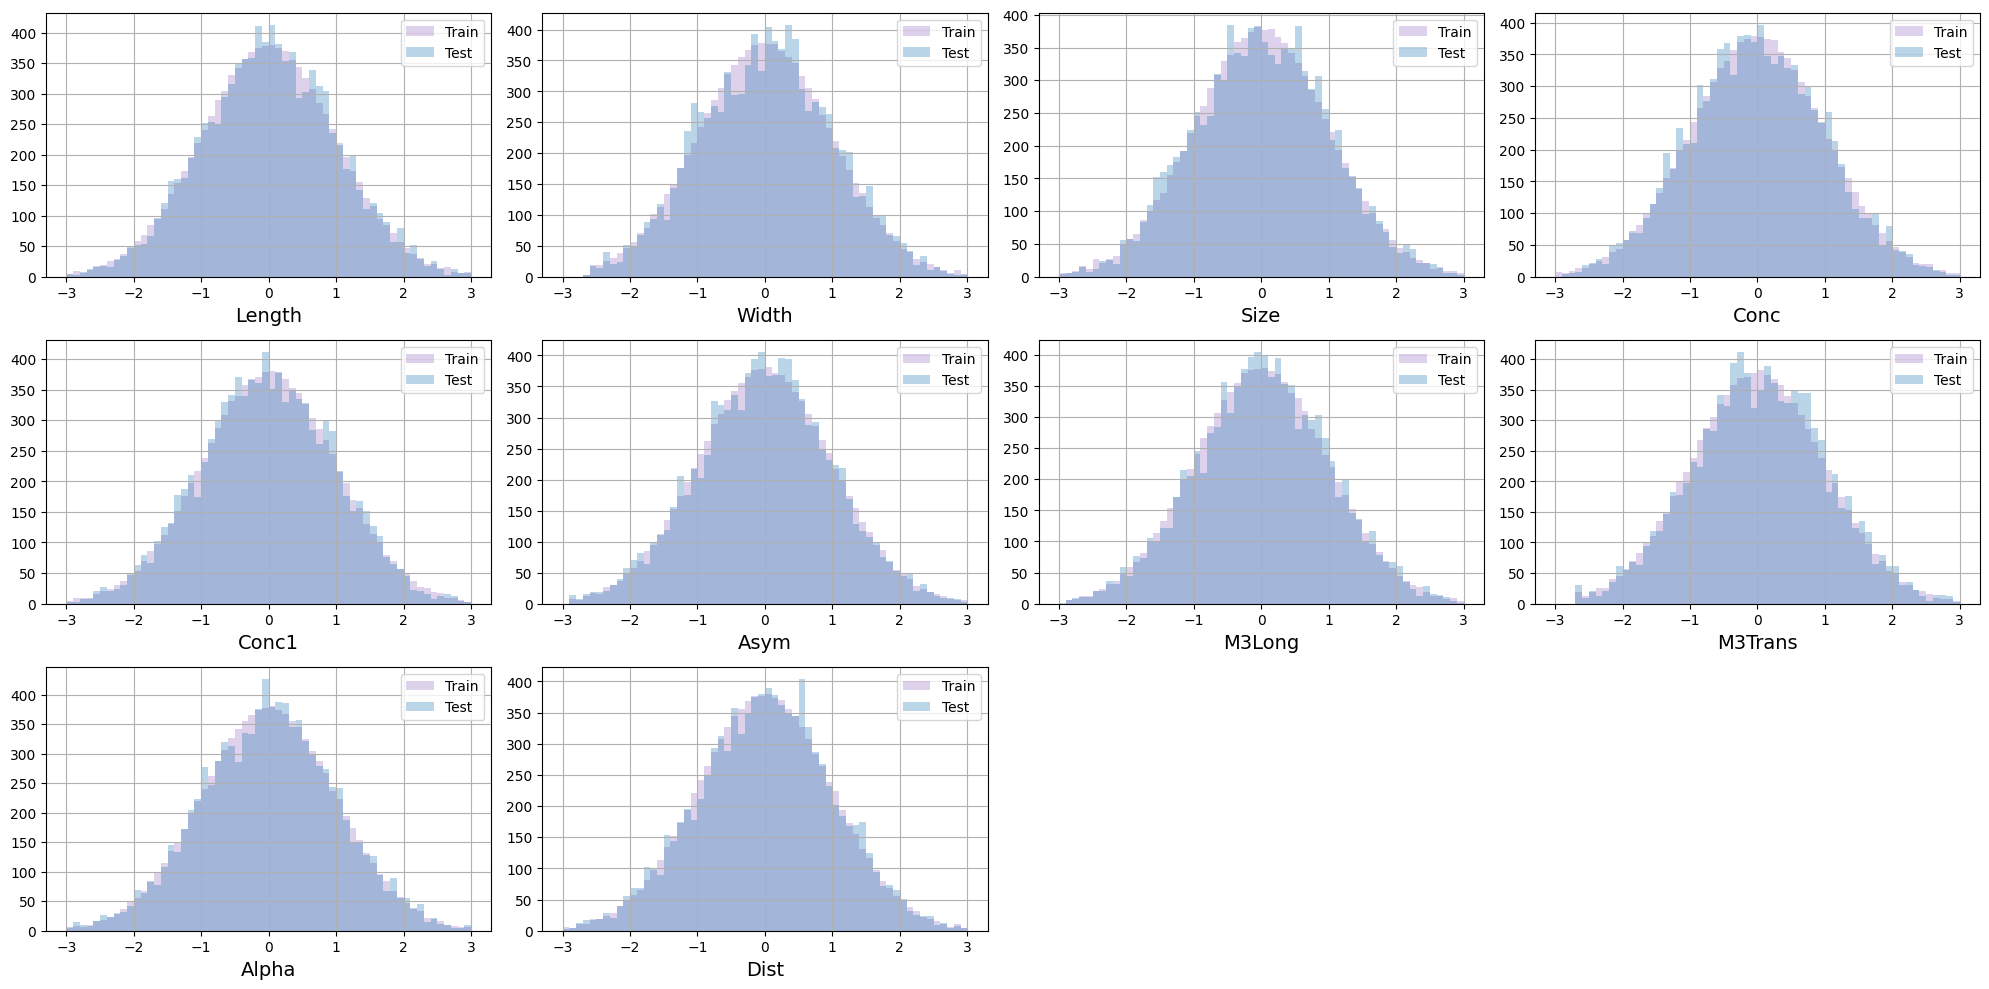

In [ ]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения.

iVBORw0KGgoAAAANSUhEUgAABZAAAAIJCAYAAAA75xhYAAAABHNCSVQICAgIfAhkiAAAIABJREFUeF7s3Qd4VNW6BuAvyaT3QkIIhJJAICBFkCZSpUtTEBsi4lFED6gIeLwiYFewoygqTcCCIqCgNOlFCL13UkjvvefutcKM6aTMTKZ86z7zmNmz9yrvnpwb/vnnXxZFSgMbBShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUKCMgCVFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIVCTCAXJEKj1GAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAYQOabgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABSoUYAC5QhYepAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQaQ+R6gAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKECBCgUYQK6QhQcpQAEKUIACFKAABShAAQpQgAIUoAAFKEABClBARQIKUIACFKAABShAgZoLZOfmIzQyCWFRyQhXHmHRybgZk4r0zBxkZuchK0d5ZOUhTXkumrODLeztrWFvaw0HO2s4O9rCz9sV/o3c0MRH/Ncd/r5usLPhn2c1vxu8ggIUoAAFKEABClCAAhTQlYBFkdJ01Tn7pQAFKEABClCAAqYikJyWjSNnwnH0bARClMeVsASdLK1lUy90btsYdymPLu0aw9XJTifjsFMKUIACFKAABShAAQpQgALVEWAAuTpKPIcCFKAABShAAbMUEBnGv+86j52Hr+JqePmAsZ1jFhyc02Hvkgl75yw4uqZDZZ0PK+VhqcqHSlUIa9tcaZeXY4P8fEsU5qtQkKdCfq4KGalOyEp1QGaaA7LSHJGdYV/OWQSU+3RpgZH9gmWGMhsFKEABClCAAhSgAAUoQAF9CjCArE9tjkUBClCAAhSggMELJKZkYtPuC9i05wIuXI/VzNfCoghO7ilw80mER8NEuHonwUpVoNX1FCjB5eRYdyRFeSApxgPpSS5K/xaaMYIDvDG8dxsM690a7i7lg81anQw7owAFKEABClCAAhSgAAUooAgwgMy3AQUoQAEKUIACFFAEroYn4rtfD2Pz3gsaD5V1AbwaR8GrSRzcGibAWsks1mfLUzKVk6M9ERfmg4QIHyWD2Uoz/HAliPyfsd3QzM9dn1PiWBSgAAUoQAEKUIACFKCAmQkwgGxmN5zLpQAFKEABClCgtMDh0+FYtj4EB0+EyhdU1oVo4B8J76bR8PCNNyiuhMgGiAv1UR6NkF9gKed2z53N8cSYLugc7GdQc+VkKEABClCAAhSgAAUoQAHTEGAA2TTuI1dBAQpQgAIUoEANBSJiUjB30VYcPXdTXmltm4/GQdfh1zpU75nGNZy6Uj/ZGuEXmuLmxebIyy3OSu7RoSlefbofmjRkneSaevJ8ClCAAhSgAAUoQAEKUKByAQaQK7fhKxSgAAUoQAEKmKBAdk4+vvr5EFb9cUwpCVEIG7s8NGmjBI5bhWq9prGu+fLzrHDzUlNEnG+B3BwVrFVWmDiqsyxtYWvzb7kLXc+D/VOAAhSgAAUoQAEKUIACpivAALLp3luujAIUoAAFKECBMgJb9l/Chyv2IDYhHWJTPL9WNxDQ8QostbwZnr7hxeZ7104EymByUZEFGno5Y+akPhjQPVDfU+F4FKAABShAAQpQgAIUoICJCTCAbGI3lMuhAAUoQAEKUKC8QEZWLl795C/sDrkmX3T2TEabHqfh6JpR/mQjPpKe5ITzB+9AepKrXMW9SgD5zf8Ohr2dtRGvilOnAAUoQAEKUIACFKAABepTgAHk+tTn2BSgAAUoQAEK6Fzgcmg8pr+3EZGxqVDZ5KFFx0vwC4wAlAxkk2xKBnLklca4ejwI+Xkq+Pu64ZNXRqJFYw+TXC4XRQEKUIACFKAABShAAQroVoABZN36sncKUIACFKAABepR4Jetp/HB0l3IzSuQWcd39DkGW/vcepyR/obOzrTF6d13Ij3RFbbWVpj73EAMu6e1/ibAkShAAQpQgAIUoAAFKEABkxBgANkkbiMXQQEKUIACFKBASYGioiK8s+RvrFUCyKL5tQxDYJfzsLQ00azjSm5/YaEFLh9po2Qk+8szJoy8EzMm9q7kbB6mAAUoQAEKUIACFKAABShQXoAB5PImPEIBClCAAhSggBEL5OUXYObCTdh15BosrQrQpucpePvHGPGK6j716GuNcOGfdigqtMTAHi3xzgtDYK2yqnvH7IECFKAABShAAQpQgAIUMHkBBpBN/hZzgRSgAAUoQAHzERCb5U17ZwOOnrsJlXUeOt57GM4eaeYDUMVKU+JdcfLvu1Cg1EXuHOyHRa+Nhr0tN9ergowvUYACFKAABShAAQpQgAKKAAPIfBtQgAIUoAAFKGASAokpmXh63q+4EpYAa9scdLo3BI5uDB6XvLlpSS44uaML8nJsENSsAb6aez/cXexN4v5zERSgAAUoQAEKUIACFKCAbgQYQNaNK3ulAAUoQAEKUECPAiLzeML/fsS18ETYOmSh08DDsHfK0uMMjGeozFQHHN/eFblZdgho4omV746Ho72N8SyAM6UABShAAQpQgAIUoAAF9CpgqdfROBgFKEABClCAAhTQskBObgGee2u9JnjcefA/DB5XYezgkglhZGOXg6vhCXj+7fVVnM2XKEABClCAAhSgAAUoQAFzF2AGsrm/A7h+ClCAAhQwS4Ht27djx44dKCoqqtP6VSoV7r33XvTt27dO/dT24oKCQjynBEAPnQyDyiZXCYweggiQst1eQGQiH/2rB/LzrNGnSwt8NOs+WFkxt+D2cjyDAhSgAAUoQAEKUIAC5iXAALJ53W+ulgIUoAAFKCAFvL29ERcXpxUNa2trREREyD713V75eDP+2ncJllYFMnjs5M6axzW5B6nKxnqinEVhgRWG9W6Nd6YPqcnlPJcCFKAABShAAQpQgAIUMAMBppmYwU3mEilAAQpQgAJlBZKTk8seqvXzvLw8REZG1vr62l64bH2IDB5bWBShfb+jDB7XAtLFKwXt+x6Vhpv3XMD3vx+rRS+8hAIUoAAFKEABClCAAhQwZQEGkE357nJtFKAABShAgUoE+vXrV8krxnH4zJVoLFq9X062ZZdzcPdJNI6JG+As3RsmIrDzeTmzT1buxcXr2slMN8ClckoUoAAFKEABClCAAhSgQC0EGECuBRovoQAFKEABChi7wJYtW5Ceno60tLQKHyXXt2fPnnLnREdH1xtBWkYOXnz/dxQUFqFBk2j4tQqvt7mYysCNg8Lg1ThGmgrbjKxcU1ka10EBClCAAhSgAAUoQAEK1FGAAeQ6AvJyClCAAhSggLEKODo6wsnJqdxDlKQo2ezt7cudI64t2SwsLPTGMPujzYhLzIC9Uwba9Dylt3FNfSBhKUwj41Lx2mdbTH25XB8FKEABClCAAhSgAAUoUE0BBpCrCcXTKEABClCAAuYisGnTplJLrai+schcLtnERnr6aL/vOo8DJ0Llpnl39D0GK1WhPoY1izFU1sWmlpYF2Hn4qlJf+qJZrJuLpAAFKEABClCAAhSgAAWqFmAAuWofvkoBClCAAhQwG4HCwkIsW7YMU6dOLbXmsgFl8eLff/9d6hxXV1edO4nSFQuX7ZbjtOh4CY6uGTof09wGEKbN2l+Wy16gWLOUhbm9A7heClCAAhSgAAUoQAEKlBdQlT/EIxSgAAUoQAEKmJNAXFwcVqxYgcWLF+PatWvllv7tt9/C09MT48aNgyhdceDAAcyYMUNzXqNGjeDn51fuOm0f+EzZNC8lPVsJHKehcatQbXfP/m4J+Le5gZjrfkhIBhatOYDZk/vShgIUoAAFKEABClCAAhQwYwGLIqWZ8fq5dApQgAIUoIBZCoj/9y+yiJcsWYL169cjN7f2m6a98sorePfdd3XqeO5qDB6Z9YMyRhG6DDkIZ89UnY5n7p2nJrjg6F89YWlpgZ8WPoqWTb3MnYTrpwAFKEABClCAAhSggNkKsISF2d56LpwCFKAABcxZYMyYMbj33nvx888/lwse29nZYeHChdi5cydsbW2rZGratClEAFmXTQS753y+VQ7RqFUYg8e6xL7Vt4sSoPcNCEdhYRHmflFsr4dhOQQFKEABClCAAhSgAAUoYIACDCAb4E3hlChAAQpQgAK6FqiorrGDgwOmTJmCc+fOyRIVffv2xbp16yBKVFTUOnXqhB07dkDX9Y+37L+Eq+EJsLHPRYBS+5hNPwIBd16EtW0ezl2NxY5DV/QzKEehAAUoQAEKUIACFKAABQxOgCUsDO6WcEIUoAAFKEAB3Qs4OTkhI6N4E7o2bdrIwPHEiRMrDAZnZ2fjxx9/xPHjx5GZmQlvb2/07t0bAwcOVEoc6P6z6Ade+F4GkFt2OYfGQWG6x+EIGoGw801x9VgbtA3wweoPHqYMBShAAQpQgAIUoAAFKGCGAgwgm+FN55IpQAEKUIACn332GU6fPo3HHnsMffr0MViQQ6fCMGX+Oqhs8tBzzE5YqQoNdq6mOLGCfEvsXzcABXlW+O7NcegcrPvNEk3RkWuiAAUoQAEKUIACFKCAMQuojHnynDsFKEABClCAArUTmDZtmuZCUWN4//79OHjwIMLDw5GWlgZnZ2eI+sa9evVCt27dajeIFq5a/luI7MWvVSiDx1rwrGkXImDv1+oGws4GQNwLBpBrKsjzKUABClCAAhSgAAUoYPwCDCAb/z3kCihAAQpQgAK1Fti8eTOmT5+OK1cqr3EbHByMjz/+GIMGDar1OLW58GZMCkQGsoVlIZq0vlGbLniNFgSatA5F+Pnm2HvsOmIS0uDj6ayFXtkFBShAAQpQgAIUoAAFKGAsArovXGgsEpwnBShAAQpQwMwEli1bhvvuu6/K4LEgEZvqDRkyBIsWLdKr0O+7z8vxvP2jlM3c8vU6Ngf7V8DGLhcNmsTIA7/vKr4n9KEABShAAQpQgAIUoAAFzEeAAWTzuddcKQUoQAEKUEAjcOPGDblxnihfUZ0mzhNlLw4fPlyd07Vyzsad52Q/Ps2jtNIfO6m9gE/TSHnxb9vP1L4TXkkBClCAAhSgAAUoQAEKGKUAA8hGeds4aQpQgAIUoEDdBD799FPk5uZqOnn44Ydx4MABZGVlaY65urrizz//lLWQRRNB5Pnz59dt4GpeffpSNCJjU+XmeR4N46t5FU/TlYCHX7y8FzeVe3L+WqyuhmG/FKAABShAAQpQgAIUoIABCjCAbIA3hVOiAAUoQAEK6Fpg+/btmiFGjx6N1atXo0ePHrCzsys1tChd8dNPP2mOietKBpl1Nc9Ne4pLJfg0j1RqIOtqFPZbXQFLyyI0UEqJiLbpVmmR6l7L8yhAAQpQgAIUoAAFKEAB4xbgP8mM+/5x9hSgAAUoQIFaCYSGhmqumzFjBiwsLCrtp1u3bnB3d5evi6zlyMjicgaVXqCFF7YdvCx7UZdO0EKX7KKOAg2bFQeQdx25VseeeDkFKEABClCAAhSgAAUoYEwCDCAb093iXClAAQpQgAJaEsjJydH05OPjc9te8/LyNOdUt27ybTut5ARRuiIhORPWSskE1wYplZzFw/oWcPNJgpUqHxExKYhNTNf38ByPAhSgAAUoQAEKUIACFKgnAQaQ6wmew1KAAhSgAAXqU8DDw0MzfEJCQpVT+eOPP5CeXhwwVKlU8PX1rfL8ur4YcjZCduHqnVjXrni9lgXU9+To2Zta7pndUYACFKAABShAAQpQgAKGKsAAsqHeGc6LAhSgAAUooEOBoKAgTe8hISEVjiTKVbz22mt46KGHNK/37t0bjo6OFZ6vrYPHzhUHJ129k7TVJfvRkoBbg+J7cvRccZBfS92yGwpQgAIUoAAFKEABClDAgAVUBjw3To0CFKAABShAAR0JiEDw7t27Ze9ik7znn3++3Ehis7y3335bc1zUSZ4zZ06587R9QJOB7GUYAeQu/gPQ1KM1rC1tkJmXjhMRexCWdPG2y7a3dsQ9AaPg7uCNgsICRKfewP5rm1CEwttea6gnuHony6mp75GhzpPzogAFKEABClCAAhSgAAW0J8AAsvYs2RMFKEABClDAaAQmTJiAd955BwUFBdi/fz8yMjI0mcVWVlbyeMlmaWmJBQsWoG/fvjpdY2ZWrqyxa2lZAGfPVJ2OVZ3Om7i3wqNdZpY6tVeL+/D+9ilIyCjeVK6yfiZ0/R/a+HQp9XJaTjJO3txb2SUGf9zFK1nZcLEQN24mITcvHzbW/FPS4G8aJ0gBClCAAhSgAAUoQIE6CrCERR0BeTkFKEABClDAGAVatmyJdevWYfr06Vi8eHGpshQPPvigZkkuLi4YPXo09uzZg5deeknnS70RWZzh6uiWpgSRi3Q+3u0GiE65oWQdp5U6zdrKFqPbP13lpW19u5cLHosLIpKvVHmdob8o7omja3E97NBb98rQ58z5UYACFKAABShAAQpQgAJ1E2DaSN38eDUFKEABClDAaAVGjhwJ8Sjb1qxZg08//RQiE9nd3V3JOLUoe4rOnodFFZetsHfO0tkYNek4rzAX287/gFFlAsbtfHsgyPtOXIw9Vq47KwsVRt3xn3LHQ8J23DZrudxFBnjATrk36ckuCItKRsumXgY4Q06JAhSgAAUoQAEKUIACFNCmADOQtanJvihAAQpQgAJGJiBKV2zatAnLly/Hzp07NaUrGjRoAA8PD70GjwVdWHRxBrKdU6bBSO65uh4xaWHl5jOmwxRYWpT/U6p34Cg0cPIrdX52fiY2nv62XB/GeMD+1r0RAWQ2ClCAAhSgAAUoQAEKUMD0BZiBbPr3mCukAAUoQAEKVCggSlj85z//QWJioub1gIAArF27Fp06dZLH0tPT8fTTTyMqKgpPPfUUHn300Qr70tbBsFtlEeydDSeAXFhUiHUnF+PZXu+WWqaPs7+ySd5I7L6yXnPcydYVg9qUN9pybhXSckpvCuhi5wFf1+awUP5P3YqUsXILcpCanWiw2crqAHLorWxxbd179kMBClCAAhSgAAUoQAEKGKYAA8iGeV84KwpQgAIUoIBOBY4dO4bx48cjPz+/1DhXr17F0KFDcebMGXh5eeHatWv44Ycf5Dn79u2TgeXg4GCdzS0+KUP2be9oGCUs1Au9FHscpyL3o32ju0utfXCbxxASthMZuSny+LDgJ2Cncih1TnRaKEQWc8nm7dQYLw/4AqKecmVNBJwPh27Djos/ISuv2KWyc/V53O5WcF99r/Q5NseiAAUoQAEKUIACFKAABfQvUP57l/qfA0ekAAUoQAEKUEDPAh988EG54LF6CjExMfjkk0/k0/bt26NXr17yZxFs/uyzz3Q604zsXNm/tV3xf3U6WA07X3/qa+Qp2cElm721E4a3nSgPNVKyibs3H1yu13UnvoTIYi7ZWni1qzJ4LM51tnXHgFYPYta9X8HLsVG5fuvrgM2te5ORZXj3qL5MOC4FKEABClCAAhSgAAVMWYABZFO+u1wbBShAAQpQoBKB3bt3a16ZN28eREayKGehbqK8hbq9/PLLmp//+OOPSnrUzuHMrDzZkUpVoJ0OtdhLUmYsdlz6uVyP3ZsPgZ9rAO7v8KxSjKL0n1YnIvbgctzJctdYWliVO1bZATf7Bniyx+vl+q7sfF0ft7IqvjcZmQwg69qa/VOAAhSgAAUoQAEKUMAQBFjCwhDuAudAAQpQgAIU0LNAQkKCHNHd3R1z586VP3/xxRf45ZdfkJSUhAsXLiAzMxMODg7o37+/ZnY3b95EfHy8LG+hi5Z5KwPZUlW6tIYuxqpNnzsu/oyuTQfBw8FHc7kIGv/n7jfgaudZqsvcgmysP72kWsPsurIOIaHblU0LLSFqI9/ZpB86Kw9183VphnaNuuN05IFq9afLkyxvBfczsouD/boci31TgAIUoAAFKEABClCAAvUvwAzk+r8HnAEFKEABClBA7wINGjSQY+bm5iIvrzgQaG1tjbZt28rjRUVFcuM80ZydnWFjYyN/Fi02Nlbzs7Z/UJdFsLQqXfJB2+PUtr/8wjyIUhZlW9ngsXh96/k1SMmKL3tqhc9TsxJwM+UaIpKv4Fz0Yaw68j6ORewqdW6rBh0rvFbfB61uBfczWcJC3/QcjwIUoAAFKEABClCAAvUiwAByvbBzUApQgAIUoED9CqizijMyMrB48WLNZBwdHTU/i9dEO3v2rAw0q1vJc7S9irSM4hrDVgZYwkK9VpEFfDH2WJVLj0u/iV2X/y0DUuXJlbx4ITqk1CtOdm6VnKnfw1a3gvvnD/yEFStWoKDA8MqN6FeEo1GAAhSgAAUoQAEKUMC0BRhANu37y9VRgAIUoAAFKhR4/vnnNcdFjeMFCxZg+fLlECUq1O23337D22+/jREjRmiOiWzkxo0bV9inNg5aWRb/aVJUZKGN7nTWh9gYr6Co8jIb604urvL16kzMwca51GnZeZnVuUwv52Ql30Tslb2YOnUqunbtijVr1jCQrBd5DkIBClCAAhSgAAUoQAH9C7AGsv7NOSIFKEABClCg3gVmz56tmYMoYTFr1qxycxKb65VtY8aMgZVV9TeAK3v97Z7b21ojLTMHhflWsLSpPEB7u350/XpsegREhnBb3+7lhhKb7V2IKZ09XO6k2xxwsHZGr4B/A/fi9BuJ529zlX5eLshXwdbZBy3uGouiuMM4efKk3IDxww8/xIwZMzB+/Hidvkf0s0qOQgEKUIACFKAABShAAQqoBZiBzPcCBShAAQpQwAwF9u/fX+NVN2zYUGYk67LZ2xV/tl2Qp7sgtTbm7+Psj9YNu1TYlbuDN7r4D6jwtcoOtvBqhz6Bo9G35QO4v8Oz+L8hS+Hl2Ehzemp2Io6H767scr0ez1fujaWVCi3a9UVISAg+//xziPeGOpDMjGS93g4ORgEKUIACFKAABShAAZ0LMICsc2IOQAEKUIACFDA8gU6dOlV7Ul5eXpg0aZIMFuqyfIWYkMhAFq2gwLADyA90fA5WFpV/kWtEu8mwVTlU27idbw+Mbj8Fo+74D+4JGAWRgaxuGbmpWHboTeQWZFe7P12eKDKQRXN0sIe7uzsmT57MQLIuwdk3BShAAQpQgAIUoAAF6lmg8n/51PPEODwFKEABClCAAroT2Lt3L+Lj41FUVFTpIBYWFhAb5rm56W/zNnu7WwHkW0HKSidXjy90atwHLRt0qHIGLnYeGNLmUWw4/U2V593uxfScFHyy6wUkZETd7lS9vS7Ki4jmYF98r2xsbCAeEyZMwPDhw7F27VosWrQIp0+fxvTp07FkyRKImtuilratra3e5smBKEABClCAAhSgAAUoQAHtCDADWTuO7IUCFKAABShgVAIikOfn5ycziit7iNf1GTwWgO6uxVm7udk2BulpY2Uns4TLtorqE98TOAo+zk3Knlqj5462LmjsFlija3R9cm5W8b3xvHWv1OM5OTnB398fzzzzDHbv3o13330X4tiBAwfw7LPPolevXli6dClycnJ0PUX2TwEKUIACFKAABShAAQpoUYABZC1isisKUIACFKAABeom0NjHVXaQlVb98g91G7FmVw8Jfgyu9l6lLkrIiMaXe1/BzZSrpY6LEhf3d5harQE2KpnKL60bire3PIlz0Yc111jAAmM7Pg+7GpTDqNaAdTgpK7343vjduldlu6oskHz8+HHMnDmTgeSyYHxOAQpQgAIUoAAFKEABAxdgCQsDv0GcHgUoQAEKUEAXAq+//jr+/PPPKktY1GTc1q1bY+XKlbC0rNtn0+oAcna6fU2G18u5Ipu4t7LRXdkmgr95BTnYcGoJpt7zfqmXW3l3QvtGd+NU5O03LSxCEeIzIrH04BuYMWARfF2ayb6cbF3RvflQ7Lr8a9mh6+V5VkZxAFl9ryqbhAgki4fISB43bpymtIU6kLx48WKZmfzoo4+ytEVliDxOAQpQgAIUoAAFKEABAxBgANkAbgKnQAEKUIACFNC3wAcffKDVUgJHjx7F3Llz0bJlyzotRZOBfCvLtU6dafniijbOuxp/ShMcvhx3EmeiDkJsiFeyjW7/DM5HH0FeYW61ZlRQlI8/z67Akz3mas7v1eI+gwkgZ9/KDr9dAFk9eQaSq3XbeRIFKEABClCAAhSgAAUMVqBuaUIGuyxOjAIUoAAFKECBqgSsrIo3QqvqnJq+plLV/XNpdVkEdZmEms5BV+d3bNxb2TivY6nui1CI305+VerYxtPfQgSASzZ3B2/c23p8jaZ2JuqQsnFetOYaT0dfiGxmQ2hZt7LDGzcsLjdS3TmVLW3x/vvvw8XFBSxtUV1BnkcBClCAAhSgAAUoQIH6Eaj7v/TqZ94clQIUoAAFKECBOgh8+OGH2LJli1ZLWDRv3rwOMyq+tFkjd/lDZoojCgstlJIYRXXus64diI3zRt/xdLlu/rmxVal7fK3U8bj0m9h/7Q/0Dihd6qJfq3EQ5ydmxpTrp6IDopxFSNh2DG7zmOblns2H4VLs8YpO19uxggJLpT61oxyvSQ0DyOpJMiNZb7eLA1GAAhSgAAUoQAEKUEArAgwga4WRnVCAAhSgAAWMS2DKlCkQD0NrdrYqiCzkmzEpSIl3g7t3Ur1PcXCbR8ttnJedn4lNZ5dXOLct51aji/8AOFg7a163trTBmA5T8N3B+RVeU9HBw6HbMEgZW2ykJ1q7Rj1kPeT0nJSKTtfLsdQ4N+VDBws0VQL9NtZ1+zOybCB506ZNWLRokSYjmTWS9XJLOQgFKEABClCAAhSgAAVuK8ASFrcl4gkUoAAFKEABCuhT4K62jeVwKbHF2cj6HLvsWB4OPujTckzZw9h6fo0SyE0ud1wcyMxLU15fXe41URs5sEH7cscrOyCyla/Gnda8bGWhQtemgyo7XS/Hk+OK70mXW/dIG4OqS1s88sgj+O2337Bw4UI0aNAAJ0+ehNjscdiwYVi9ejVyc6tXQ1obc2IpDc2qAAAgAElEQVQfFKAABShAAQpQgAIUoMC/Agwg891AAQpQgAIUoIBBCXS+FZxMNoAAcmf//hCB25ItPiMSe66sr9Js79XfIcpZlG3dmg6Wh0SJipKtskId/4RuKXVe2Q36yvav6+fJMdoPIKvn7OrqilatWmHSpEnYuHEjxEaPIri8d+9ezJ49G0OHDmUgWdc3mP1TgAIUoAAFKEABClCgAgEGkCtA4SEKUIACFKAABepPoFv7JnLwVCXbtaiyyKqepnch5qgSCI5AQWEeCosKEJ0aiu8Pv19uo7yy0xHnrg5ZgJi0MHmdeCRlxuLkzX3y1Ktxp5RN8qKU44XK8RhcjDlWtgv5/HjEHlyOOyHPyy3IqdcayOJepMZ7yHnd1a44S7zCSdfxIAPJdQTk5RSgAAUoQAEKUIACFNCygEWR0rTcJ7ujAAUoQAEKUIACdRIYNmUpIuNS0fHef+DuU/91kOu0GBO5ODHaEyd33AV/XzdsXPSE3laVkpKCmJgYbN68GV999RWuXbsGb29vBAUF4cknn8S4ceNgY2Ojt/lwIApQgAIUoAAFKEABCpibgNU8pZnborleClCAAhSgAAUMWyBC2UTvzOVoWFoVwssvzrAnayazu3GmBdKTXDGyfzB6dmyqt1Xb2dnB09MTbdq0wciRI9GsWTOcOnVK1kg+ePAg/vrrLxQWFiIwMBC2trZ6mxcHogAFKEABClCAAhSggLkIsISFudxprpMCFKAABShgRALDe7eWs40N9YVSvYGtngUKCy0QF9pIzkJ9b/Q9papKW7z22msYMmSIzFBOS0vT99Q4HgUoQAEKUIACFKAABUxaoPSuMCa9VC6OAhSgAAUoQAFjEWjXsiGaNHRFeHQKEqO84OkXbyxTN8l5JkQ2QEG+Ffy8XdC6uXe9rlEEksXDx8cHw4YN05S2+Oeff2R5i++//x4TJkzAo48+Cmdn53qdKwenAAUoQAEKUIACFKCAKQgwgGwKd5FroAAFKEABCtRBoKCgAAcOHMCxY8cQERGBrKwsODk5oUmTJujSpQu6du0KCwuLOoxQu0uH92mDr346hBgl85UB5NoZauuqmBsNZVdj7m2nrS7r3I86kOzh4YF77rlHlrJYvnw5Dh8+jMjISGzYsAHjx4/H2LFj5fuZjQIUoAAFKEABClCAAhSonQA30audG6+iAAUoQAEKGL2A2Ed30aJFeOuttxAbG1vpekQgec6cOXjqqaf0GkgOi0rGyOeXyzrIPUbvhI1dXqVz5Au6E8jNtsaB3/oppUQssWXJZPh4GmZWb3x8PEJDQzWB5Bs3bqBx48Zo3bo1A8m6e3uwZwpQgAIUoAAFKEABMxDgJnpmcJO5RApQgAIUoEBFApMmTcJ7772HjIyMil7WHEtNTcXvv/+O69evY/To0XoLIrs62+HUpSiERaXCwrIIHg0Tq5wnX9SNwPVTLZES54HenZtj3OD2uhlEC706ODigUaNGCA4OxsCBA2XwWJS0OHToEI4fP46dO3ciPz9fbrZnY2OjhRHZBQUoQAEKUIACFKAABcxDgAFk87jPXCUFKEABClCglMDq1asxd+7cGqmcPHlSBug6d+5co+vqcrKfjyvW/30W6Uku8AsKVbKRi+rSHa+toUBergrn9nVCUZEF3ntpGBq4O9awB/2fXjKQPGDAALRq1QoXLlxgIFn/t4IjUoACFKAABShAAQqYiICliayDy6AABShAAQpQoAYCX331leZse3t7zJ49GwcPHoQoAyBqIickJGDfvn2YOnUqVKp/t0xYuHBhDUap+6kdWzdCl7aNlQ3cVIi42LTuHbKHGgkI88ICS3Rr7482Lep387waTVw52cvLCx06dMDEiRNlbWTx3nVzc8P27dsxf/58jBs3Th5PT0+vadcmd354eLj8PRe1zo3lIeYr5s1GAQpQgAIUoAAFKKB7AdZA1r0xR6AABShAAQoYnIC7uzuSk5PlvNauXSs3Gqusff3115gyZYrm5ejoaPj4+FR2utaPHzoVhinz10Flk49uI3azFrLWhSvuUNQ+PrShjwzef/vGWBnIN+Ym3u+iRvKuXbtk4PjMmTOskXzrhj755JNYtmyZ0d1eUYZn6dKlRjdvTpgCFKAABShAAQoYmwADyMZ2xzhfClCAAhSggBYEnJycNLWP4+LiZLZmZS0qKkqWrlC38+fPy43J9NmenvcrDp8Oh2+LCLTucUafQ5vtWOcOtEfM9eIMcBFANpXGQHLpOymyeJs3b66UKSnCpUuXEBAQYPC3+urVq7I0iciWFrXZxUafbBSgAAUoQAEKUIACuhNgCQvd2bJnClCAAhSggMEKBAUFaeZ29OjRKucpNiBTNysrK/j5+VV5vi5efP3Ze2FlZYmoa42RmuCiiyHYZwmBlDg3GTy2Vlli3nMDTcpGlLEQpS0effRRLFq0CPPmzYP4QGXHjh14//33MXnyZPz444+33VzSVFDmzJkjy9Y8/PDDRhE8Fu4iyP3QQw/Jede0lrup3DeugwIUoAAFKEABCuhTgBnI+tTmWBSgAAUoQAEDEfjoo48wY8YMOZsWLVrI+sfe3uVr3CYlJaF79+4yM1G0kSNHYsOGDfWyik9X7cOy30Lg6JaGu4btV7IP62UaJj9oUSHwzx/3ICvNEU+P7YapD/cw6TWLut8XL16UpS1E4Fj8LAKU7du3x5gxYzBixAg4Ohr+5oG1uUnqTF5xrbFkH6vXySzk2txxXkMBClCAAhSgAAVqJ8AAcu3ceBUFKEABClDAqAXS0tLk19bFZnmiiYCZyEQUGcYlm8jIFLVi1W3BggWyfIXI/MvPz5f/FY/AwEDcddddOjXJysnDiKnLEJ+ciVZ3nYVfK26gpQvw8AtNceVoG/h4OuH3L56AjfW/myjqYjxD6bOyQHKbNm1w33334f7775eb8JlSe+KJJ7BixQqZjb1q1SqjW5qY95o1a8BayEZ36zhhClCAAhSgAAWMTIABZCO7YZwuBShAAQpQQBsCd999Nw4cOKCNrmQfKpUKYnM9T09PrfVZUUdbD1zGrA83wUqVjy7DDsDBObOi03islgKZaQ44suluFBZY4aNZI9C/m+HXw63lUiu9rGwgWdT8btasGdq2bYtRo0aZTCDZmLOP1TePWciVvo35AgUoQAEKUIACFNCqgJVS922eVntkZxSgAAUoQAEKGLzAM888IzfN0lYrLCzE448/XmEZDG2NIfoJaOKJqxEJuBKajKQoT/gGRsDSUnvr0OZcja2vgnxLnNjeFbnZdri3eyCeebC7sS1BK/N1cHCAv78/goOD0aNHD5mpL8paiA9cTp8+jf379yMrK0set7Oz08qY9dHJiy++iBMnTuCRRx7BU089VR9TqPOYHh4esvTGqVOnIDZHFAF+NgpQgAIUoAAFKEAB7QswA1n7puyRAhSgAAUoYPACnTp1ksEjbTV3d3eEh4frpVasKGXx4EurEB6dgoYB4WjT/ay2lmHW/ZzZ0xFx4Q3R3M8daxY8Antba7P2UC++ZEbyunXrcPLkSaPPSDaF7GP1/WEWMn9NKUABClCAAhSggO4FGEDWvTFHoAAFKEABChicgMigDAsL01oWsq+vL1xdXfW2zqvhCXh45hrk5hWgTY9TaNgiUm9jm+JAkVca4+I/7WBro8Lajx6Dv69p1frVxj0TgeTLly/jn3/+kZvthYSEGG0geeLEiVi5cqXR1j4uez9ZC7msCJ9TgAIUoAAFKEAB7QowgKxdT/ZGAQpQgAIUoICeBNb/fRbzvtgGC8tCdLr3MFwbJOtpZNMaJinGAyf/7oKiQksseHk4BvZoaVoL1PJqEhMTZRbyvn37sH79evlzUFAQ7rzzTgwbNkw+9PlhSk2XZ0rZx+q1Mwu5pu8Cnk8BClCAAhSgAAVqJsAayDXz4tkUoAAFKEABkxI4ePAgPvvsM6xZswbHjx9H48aNK9wIT9Q4trCwMKi1t27ujcTUTJy9HIvY0Ibw9IuDjX2uQc3R0CeTnuQs6x4XFVph8v134eFhHQ19yvU+P3t7e1n/+I477kCHDh3QokULXLlyBdu3b8e5c+fk71FOTo6so2yINZJfeOEFGfQ25trHZd8ErIVcVoTPKUABClCAAhSggHYFmIGsXU/2RgEKUIACFDAagRkzZuCjjz4qNV8bGxssWbIE4ivuokVERKBr166IiYmB2Hjvyy+/NKj1iY0AZ324GdsOXobKJhddhhyEvXOWQc3RUCeTmeqAo1u6Iz/XBsN6t8Y704cY6lQNel7GlJFsitnH6jcHs5AN+teEk6MABShAAQpQwMgFGEA28hvI6VOAAhSgAAVqI/Drr79i7NixFV5qbW0tN9gLDg5GaGiozLAUGcii/fXXXxg8eHCF19Xnwafn/YrDp8Nh45CNzoMOwc4xuz6nY/BjZ2fY4diWbsjJskfPjk3x5ZwxBj9nQ5+gMQSSH3/8cXz//fcmU/u47HuCtZDLivA5BShAAQpQgAIU0I4AA8jacWQvFKAABShAAaMSGDBgAP7++2/NnEXN1pSUFM3zJ598Et999518rg46iZ/HjBmDdevWGdxas7Lz8NgrP0JsrmfrkIWO9x6Bg3Omwc3TECYkMo+Pb+uG3GxbBDVvgOVvPQh7O2tDmJpJzOF2geThw4fDxcVF72s15exjNSazkPX+tuKAFKAABShAAQqYiQADyGZyo7lMClCAAhSgQEkBNzc3TcBYBJL79euH5cuXY9KkSfI0X19fREZGyp8PHTqEHj16yJ9F4EsEyKysrORzQ2oJyZl4Zv6vuBKWIMtZdOh/FC6e/wbFDWmu9TWX1Hg3ZcO8zsjPs0bLpl5YMu8BuLvY19d0THrcygLJ3bp1kxvtDRo0SK+B5AkTJmDVqlUmm32sfjMxC9mkf624OApQgAIUoAAF6kmAAeR6guewFKAABShAgfoUEJt7iY2+vL29ZX1jdWvatCnCwsLkUxEAc3d3l+c5ODhoyliIush+fn71Of1Kx87IysXUN3/DyYtRsLTKR/u+x+DeMLHS883phcQoT5zedadyH63QvlVDLH79fjja25gTQb2stWwg+cyZM2jdujU6d+4sy8H0798fDRo0uO3cRL3vuDhlo0ilTrn4AKgmzRyyj9UezEKuyTuD51KAAhSgAAUoQIHqCVhW7zSeRQEKUIACFKCAKQmIQLFoSUlJMlCsbgEBAZqfRbBKNJVKBUvLf/9kKFnqQnOygfwgAqLfzH8A93RujsIClZJt2wXhF5oZyOzqbxqh55rj1M7OMnh8d6em+PaNsQwe6+l2eHh4yAz/5557DgsXLsTs2bPl79Pq1avx1ltv4YUXXsDKlStlcLiqlpubKzOIFy1apPkwp6rzS742b948ec3DDz+Mkr/j1b3emM4T63vooYdQUFCAuXPnGtPUOVcKUIACFKAABShgsALMQDbYW8OJUYACFKAABXQn8PLLL+PDDz+UA0yePBnffvut/HnIkCHYsmWL/FlspNehQwds3rwZom6ruonSFqLEhSG3wsIizP1iK37fdV5O09MvFsF3n4TKusCQp631ueXnqnB2XwckRhVnuA69JwhvTxuiBDAttD4WO6yeQHR0tCwLs3v3bmzbtg2XLl1CmzZtZJkYUZtcPETQuWQT2cdiQ8sRI0YgOzsbn3/+ufxdrU4zp+xjtQezkKvzzuA5FKAABShAAQpQoPoCVkpGwrzqn84zKUABClCAAhQwBQFHR0csXbpULuX48eM4cuSIDGYdPHgQaWlp8rgoVbFs2TK89957moxHETg2hj8dLCws0L9bIJwcbXH4dDgyUhwQe8NXKWeRABu7XFO4hbddQ3qyE45t7Yb0JFcli9wSMyf1wQsT7oGwYas/AScnJwQFBaFjx45o1aoVmjRpIoPDW7duxblz52RAOSsrS35IY29fXJ86Ly8PK1aswJo1a2TtclFmpnv37vDy8rrtQqZNm4ZTp07hkUcewVNPPXXb803hBBGAF45i3cnJyRg1apQpLItroAAFKEABClCAAvUmwAzkeqPnwBSgAAUoQIH6EyhZ67gms5gzZw7eeOONmlxS7+eeuRyNlxduQnR8GiwsC9G03TU0bXtVycItqve56WIChQWWuHGmBcLOtUBRoSUaNXDBx6+MQFCz29fZ1cV82GfVAgkJCTh8+DD27t0rg8iiRrIIMKszkkX5i/T0dPktABFgFk3UQRabxX300UdV1kM2x+xjtTazkKt+3/FVClCAAhSgAAUoUBMBZiDXRIvnUoACFKAABUxE4JVXXpE1QmvS+vbtiyVLlsiayMbUvD2dMKp/W1wLT8SNm8lIjvFAbKgvnNzTYOeYbUxLue1ck2PccWJHVyTc9AGKLNCvawC+nns/fJUgMpthCogNKlu2bCkzkkXgWGxQeePGDU1G8oULFxASEoI///wTopSFaKKe8bVr1yA2w+zZs2elWeX//e9/zS77WH2XmYVsmO93zooCFKAABShAAeMUYAaycd43zpoCFKAABShQJwGxoZfIdlQHpCrqTJQ6EKUuAgMDMXLkSPkVeGMLHpdd1597L2LBst1ITMmULzVscRMBnS4oZS3yyp5qVM/zcmxwOaQ1Ym40kvP2cnPEy5N6Y0ivIKNaBycLlM1IFmUYRJC57OaVYiM+8U2CTz/9VNZGLtvMOftYbcEs5LLvCj6nAAUoQAEKUIACtRNgALl2bryKAhSgAAUoQAEjFUjPzMVnq/dh7ZZTSgAdsLYpgG/gDfgHh8La1rjqI4vAcdjZZoi80hT5eVZKJiowfkgHTHusFxzsrI30DnHaQkAEkg8cOIC5c+fKOuUVNfGBjqiF/PXXXyM4OLjUKaLEhaiZLP67atWqii43i2Nqh0mTJmnqvpvFwrlIClCAAhSgAAUooEUBBpC1iMmuKEABClCAAqYqMGHCBPz2229o27YtduzYAbERmLG389di8fqirbgcGi+XYqUqRMOAcDQNvg5bB8MubZGdYY/Qc80QfbUJRM1j0Vo3b4A3nh+EVqx1bOxvTTl/8e0AsbnekCFDcPHixUrXJOohi28HfPzxx5p6yMw+/peLWciVvnX4AgUoQAEKUIACFKi2AAPI1abiiRSgAAUoQAHzFbC3t0d2dnFQ9cSJE+jQoYNJYBQWFmHHP1fw3a9HcOF6rFyThUUR3BomwKdZFBo0iYbKuma1onUFIzKM48IaKmUqfJU6zp5KgFFJN1ZacIA3nhxzFwZ0bykzkNlMQyA3NxfffPMNpk2bJmseV9ZEqRlXV1eZqSxqHltZWcmA8g8//GD22cdqM2YhV/bu4XEKUIACFKAABShQPQEGkKvnxLMoQAEKUIACJieQlZUlv9p+9OhRREZGIjU1tdI17tmzR1MvuXPnzjID2draWgatevXqVel1xvTCwZNhWLruMI6ciSg1ba/GMfBpHgV333hlzfl6XVJengpJUV6Iue6L+AhlY7wS7a52jfHk/V3Ro4O/XufEwXQvILKPIyIiZG3jkydP3nZAUQ+5WbNm+Pzzz+VGfK1atZLXXLp0CQEBAbe93tRPYBayqd9hro8CFKAABShAAV0LMICsa2H2TwEKUIACFDBAgejoaPTp00cGmOrSTLG+amhkEjYrm+39te8ixM/qJjKTndxT4N4wCe4+CXD1TlLKXmg3O7kgX4XkWDclaOyJpBgPpCe5KMP/m1bc3M8Dg3u1wvDebdCkoWtdbh2vNWCB6mYfl1yCqIfcs2dP+eHO5s2bmX1c5v6qs5AN+LbLqf34448YNWoU7OzsDH2qnB8FKEABClCAAmYkoDKjtXKpFKAABShAAQrcEnjttdfqHDwWXYmvz5taa9rIHc+O7y4fok7y1v2XsOfodVwNT0Baopt8hJ1rLpdt55gFe5cMODgrD5dM5ZGhlLzIh5XysFTly/IX1jZ58lyx4V1+viUKlSBxgZJZnJ+rQkaqI7LEI80emWlOELWNy7aWTb3Q685mGHx3K6XOsXfZl/ncBAXE75Wjo6MsX1G2iezktLQ0zSM9PR3qh8i0vXnzprxkypQpZS816+fPPvus3FSQjQIUoAAFKEABClCg5gIMINfcjFdQgAIUoAAFjF5AZCiqm6iZKmoau7m5VRoQ3rlzp6YOa7du3TQlLKZOnWr0FlUtoE0Lb4jH9Am9kJKejSOnwxFyNkI+roQlyICveIgyE9pqImDcuW1jdAn2w113NIGrEzMRtWVrLP2IkhQ+Pj5o0aKFDAiLchbiWwPq/4ogsqiLLB7qn8XamjdvjrFjx+KXX37BV199ZTLlZbRx3xYvXiy7EZnIX3zxhTa61GofkydPxqZNm7TaJzujAAUoQAEKUIAC2hJgCQttSbIfClCAAhSggBEJiPrF+fnF9XxXrlyJCRMmVDl78XXqnJwcec7x48fRsWPHKs83hxezc/Nx42YiIqJTEBaVjLDoZETGpiItIweZ2XnIys5VHvlIyyx2c3awhb29NextreFgZw1nR1v4ebvC39dNlqNorDyaKSUq7Gz4+b45vH+qWmNeXh6WLl2Kl156SRMoVgeMK9tQz8HBASJI2q9fPxlIFoFl1kAuVlbXQBaBefGzv7/h1Q1/+OGHsX79eixfvpwlLKr65eBrFKAABShAAQrUiwD/hVIv7ByUAhSgAAUoUL8CDRo0QFRUlJyEjY1N/U7GSEcXgV5RUoJlJYz0BhrwtMUHPA8++CDWrl2LHTt23Hamov7x3XffDRGEFNeKD4REIFJscik2yjT39vrrr8tA/MSJEw0yeGzu94frpwAFKEABClDA8AUsDX+KnCEFKEABClCAAtoWGDlypKbLffv23bZ7V9d/N2wr+fNtL+QJFKBArQTE79kHH3wgayFX1US9ZLFx3vz582XwWLQ33ngDojTNDz/8IDNuzbmJ9YuN6USQfd68eeZMwbVTgAIUoAAFKECBWgswgFxrOl5IAQpQgAIUMF6BTz75RAZVvvnmG8yZM+e2Czlw4ID8Sv2uXbvk1+PZKEAB3QqIcgvBwcGYPXt2lQOJoPFDDz2Erl27as5r0qSJzEIWWbciC9mcmzr7WHgYYukKc743XDsFKEABClCAAsYjwACy8dwrzpQCFKAABSigNQFR01hkIcfHx2P48OFo1qwZ+vTpgxUrVpQb4/z583LzLvH1eHEOGwUooB8BUV5m4MCBEL+vFTWRfSw22xMfAomM45KNWciQ2dfMPq7oncNjFKAABShAAQpQoGYCDCDXzItnU4ACFKAABUxCIDc3Vwam/ve//yEkJAShoaHYs2cPnnjiCTzzzDOaNZ45cwbt2rVD37590bNnT4jr2ChAAd0LZGRk4M0338SIESM0G1iWHVUElsVGe76+vmVfArOQAWYfl3tb8AAFKEABClCAAhSolQADyLVi40UUoAAFKEAB4xb47LPPsH///goXsWTJEvz555/yNRGEcnBwkD8fP34cK1eurPAaHqQABbQjIMpOHD58GIMGDcJ7772HtLQ0PP300+VKWYiMY1HiQrwmMpErauachczs44reETxGAQpQgAIUoAAFaifAAHLt3HgVBShAAQpQwKgF1qxZo5l/o0aNZDkLNzc3zbHFixfLn8VGXtOnT9ccZwDZqG87J2/gAqmpqbIcxeDBg3HkyBEEBARgw4YN+PjjjzFz5kz06NFDswJ7e3u89dZbmg94KlqaOWchM/u4oncEj1GAAhSgAAUoQIHaCVgUKa12l/IqClCAAhSgAAWMVUBkFWdlZUGlUsnyFSKIfOLECdx5550Qfxo4OztDBLNEu3TpEoKCguTPYsMukRFpa2trrEvnvClgcAIFBQUQG1W++OKLOHv2rKxnPHXqVMyaNQvu7u7yufockZksfh4zZgzEB0Flax+XXVx4eLjc+FL8XovfZRGUNvUmso9btWoFsRGh+NkYNs8TNebXr1+P5cuXY9SoUZXWvTb1e8f1UYACFKAABShgmALMQDbM+8JZUYACFKAABXQqIAIronl6esrgsWgdO3aUX4kXTQSJo6Ki5M+BgYEycCxaXl4eIiMj5c9sFKBA3QUSEhIwY8YM+S2AU6dOoW3btvjjjz8gyk94eXlpAsQiUNy5c2e8/PLL8tsC8+bNu23wWMzOHLOQmX1c9/cle6AABShAAQpQgAIlBRhA5vuBAhSgAAUoYIYC6kBxbGwsLl68qBEouRlXcnKyPC42zsvPz9ecw430zPANwyVrXUBkEW/btg19+vTBV199JX/HXn31VWzfvh333HNPhRmo4psDItgsapirvxVQnYmZUy1k1j6uzjuC51CAAhSgAAUoQIGaCahqdjrPpgAFKEABClDAFATGjx8va6yKr7U/8cQT2LFjh6ylWvLr8Dk5OfKr8u+++648T918fHxMgaDOa8jOzUdoZBLCopIRrjzCopNxMyYV6Zk5yMzOQ1aO8sjKQ5ryXDRnB1vY21vD3tYaDnbWcHa0RSNvFzRt5I4mPq7wV/7r7+sGOxv+eVbnm2PgHcTExMgM4lWrVskPaLp37y43zBMlZG5XHkZkH48dO1aWZ6huU2chi/IIc+fOleOaalNnH0+cONEoSleY6n3guihAAQpQgAIUMC0B1kA2rfvJ1VCAAhSgAAWqJfDjjz9C1NxUN/FVeUdHR4jAVnZ2tjzcsGFDiCxk9XNxrF27djh9+nS1xjC1k5LTsnHkTDiOno1AiPK4EpagkyW2bOqFzm0bo0uwH+66owlcnex0Mg47rR8BUef2f//7H65fv658oGAvs46ffvppWXe8JkHhms7eHGohG2PtY/V9ZA3kmr6jeT4FKEABClCAAvoUYIqLPrU5FgUoQAEKUMBABJ555plSM4mPj4d4lGzR0dHlZjtz5sxyx0z5gMgw/n3Xeew8fBVXw8sHjH0dc+HvkgN/5xz4OeehhVsOnK0LYG9dCHtVARxURXC1LS7/kZKjQjTGI2oAACAASURBVGa+BbLyrZCVZ4nUXEtcT7FDRJoNwlKVR5otojNscDk0Xj5+3HxC0oqAcp8uLTCyX7DMUGYzToHExEQZLBbZv6KWeK9evbBgwQL5oYyNjY3OF2UOWcjMPtb524gDUIACFKAABShgpgLMQDbTG89lU4ACFKCAeQu4uLjIjfKq20RmpAh+vfnmm9W9xGjPS0zJxKbdF7BpzwVcuB6rWYelRRGC3LPQuWEG7mqYjo7emUqQuFCr68zMt8SJGEcciXbE0RgnXEy0QxEsNGMEB3hjeO82GNa7Ndxd7LU6NjvTncDGjRvx4osvIiIiAuJ3b86cOZg8ebLMQNZl1nHZFZlyFrIxZx+L+8QM5LLvVj6nAAUoQAEKUMCQBJiBbEh3g3OhAAUoQAEK6Engyy+/xO7du0vVNi47tIWFhSxrERgYiPvuuw/NmjUre4pJPb8anojvfj2MzXsvaNblqGQS92mSjL5N0pTAcbqSXazdgHFZQAclIN3TL00+REtTMpVDopyxM9wZe8Jdce5qrHwsWLZbCSS3xn/GdkMzP/ey3fC5gQhERkZi1qxZEGUrsrKy0L9/f3z66afyd0ofWcdlGUw5C5nZx2XvNp9TgAIUoAAFKEAB7QkwA1l7luyJAhSgAAUoQAEjFDh8OhzL1ofg4IlQOXt76yIM9E/CwKYp6NYo3aBWdOCmM3aEuWLbDTdkFxRnJvfo2BRPPdAVnZWayWyGI7BmzRpZ6zgqKkpuUCk2o3z88cflz+LDmfpqppiFbOzZx+K9wAzk+vqN4LgUoAAFKEABClRHgBnI1VHiORSgAAUoQAEKmJxAREwK5i7aiqPnbsq1udgW4qGgOIxvE6/zTOPaYqqzk1/oHIUfznvhp4sNZOBbPHp0aIpXn+6HJg1ZJ7m2vtq4LiwsDDNmzMDmzZtl1vHIkSNl8DggIKBeso7LrskUs5CZfVz2LvM5BShAAQpQgAIU0K4AM5C168neKEABClCAAhQwcIHsnHx89fMhrPrjGPLzC+FmV4DH2sRhXFCC1msa65oiQylxsfaSF1af80JKjhWsVVaYOKqzLG1ha2Ol6+HZfxmBb775BvPmzUNcXJysdfzRRx9h7NixstZxfWYdl71RppSFbArZx+L+MAO57LuUzylAAQpQgAIUMCQBS0OaDOdCAQpQgAIUoAAFdCmwZf8ljPzvcixXSlYUFRTg4dZx2Dj6Ah5vG2d0wWPhJGo0P9E2FhvGXMB4JXu6QFnTt0od51HKGrcfvKxLSvZdQuDy5csYMWIEXnjhBVmyYty4cThy5IgMCtZ3yYqKbpQ6C7mwsBBz586t6BSjOabOPp4wYQL8/f2NZt6cKAUoQAEKUIACFDAmAWYgG9Pd4lwpQAEKUIACFKiVQEZWLl795C/sDrkmrw/2zMTrPSLQwi2nVv0Z6kWXk+zwxoHGuJhkL6d4b/dAvPnfwbC3szbUKRv1vETAfvHixXjjjTeQlJQEHx8ffPjhh7JshZ2dnUFlHZeFNoUsZFPJPhb3hhnIZd+hfE4BClCAAhSggCEJMAPZkO4G50IBClCAAhSggNYFLofGY9xLq2Tw2MUmH//rdhPLhlwzueCxgGvpno2Vw67ila43ZR3n7YeuYPzLq3EtIlHrrube4enTpzF06FDMmjUL8fHxcoO8gwcP4oEHHjC4khUV3StTyEJm9nFFd5bHKEABClCAAhSggPYFmIGsfVP2SAEKUIACFKCAgQj8svU0Pli6C7l5BTLr+MO+ofC0zzeQ2el2GjEZKszc3QwXEu1lPeRXnx6AUf2CdTuoGfQuso4XLFiADz74AGlpaWjUqBG+/PJL9O/f3+CzjsveHmPOQjal7GNxX5iBXPbdyecUoAAFKEABChiSADOQDelucC4UoAAFKEABCmhFoKioCG9/vQNvKQ8RPB7bKgHfDr5qNsFjgejjmI/vhlzFmJYJyMktwNxFW6UJW+0FQkJC0K9fP8yfP18Gj5999lkcOnQIgwcrZUIMbKO86qzSmLOQmX1cnTvMcyhAAQpQgAIUoIB2BJiBrB1H9kIBClCAAhQwWoHc3FwcOHAAN27cgLOzM9q2bYvWrVsb7Xry8gswc+Em7DpyDbZWhZjXMxwDmqYa7Xq0MfHN19zw9iE/5BVaYmCPlnjnhSGwVllpo2uz6CMnJwdvv/02Fi1ahNTUVAQEBOCLL75Ar169ZNaxMTdjzEI2texj8f5hBrIx/xZx7hSgAAUoQAHTF1CZ/hK5QgpQgAIUoAAFKhP47rvv8NprryE6OrrUKT179sQ333yD4GDjKnkgNsub9s4GHD13E07WygZnA68hyCO7suWbzfFhLZLRxDkH0/5ujm0HLyMxJROLXhsNe1turne7N4HIMJ42bRpEzeP8/HzMnDkTM2bMgLu7O6ysjD8IL7KQJ06ciKVLlyIwMPB2HAb1+hNPPAF/f3+DmhMnQwEKUIACFKAABUxRgCUsTPGuck0UoAAFKECBagiIGq5PPfVUueCxuFRkJHfv3l1uCqZu169fl1/dHzVqFIYPH45XXnkFFy9erMZI+jlFBEUnvvqTDB672ebhm8EMHpeUv6NBFr4aeB2utvnS6IlXf0ZSapZ+bo4RjpKRkYHZs2dj0KBBOHbsGFq2bImdO3di7ty58PLyMongsfq2zJs3z+jWo1Kp5L1gowAFKEABClCAAhTQvQBLWOjemCNQgAIUoAAFDE5ABH7bt28PUb6iqubp6Yldu3bh22+/lRuF5eXllTpdZGCKr/VPmTKlqm50/prIPJ7wvx9xLTwR3g65WDLoGho5lZ6rzidhJAOEpdpgyrYWiM+yRkATT6x8dzwc7W2MZPb6meaOHTvw0ksvyQ9ILCws8H//9394/vnnZYkXU8g61o8iR6mJAEtY1ESL51KAAhSgAAUooG8BZiDrW5zjUYACFKAABQxAQJSnKBk8FpuArVmzBuvXr8e4ceM0M0xISECHDh3w6aeflgsei5MKCgrw3HPPYd++ffW2KrFB3HNvrdcEj5cOYfC4qpvh75ILYeRpl4+r4Ql4/u31VZ1uVq+lpKTI9/Po0aNx5swZ+SHL3r17ZdkKNzc3Bo/N6t3AxVKAAhSgAAUoQAEKqAUYQOZ7gQIUoAAFKGCGAlu2bNGsuk+fPvjrr7/kJk6iPMXPP/+MBQsWaF4vLCwsJSQ2DRPBNHUTr7/77rv1olhQUIjp723AiQuRcLHJx5f3XlcykJl5fLub0dAxVylncVXWiT5+PhLT392ofBhQ+j7frg9Te33Tpk0Qtb9Ftr1o7733HrZu3Yo777wTtra2prZcrocCFKAABShAAQpQgALVFmAAudpUPJECFKAABShgOgLh4eGaxTz++OOlFiY2Crty5Uq5xYq6r59//jlEVnJiYiLmzJmjOUfUhi1b3qJcBzo48H+f/YVDJ8Nga1WIL5X6viK7lq16Ak1dc/H5gOuwUxVid8g1zFm0tXoXmthZ4r0sNmMbP348Lly4gK5du8oa4NOnT5cflFha8s9lE7vlXA4FKEABClCAAhSgQA0F+BdxDcF4OgUoQAEKUMAUBEqWr/Dz89MsKSsrC2PGjMHXX39dbpnTpk2TdWAdHBxkXVjxXN3EdbGxseWu0eWBZetD8Ne+S7CyKMIn/W+glXu2Loczyb7bemXhw743pOHmPRfw/e/HTHKdlS1q3bp1uOuuu/DDDz9AbMom6nmLbPy2bdvCxoZ1oStz43EKUIACFKAABShAAfMSUJnXcrlaClCAAhSgAAWEQMOGDXH9+nWJERERIf+bnp6O4cOHY8+ePfJ52fbOO+/gvvvuQ6dOneRLZTMzc3Jyyl6is+dnrkRj0er9sv8ZXSLR2SdDZ2OZesd3NczAi12isPBII3yyci+6tmuCoOYNTHrZ0dHReO2117Bx40aZTd+3b1+I93dwcDAcHR1Neu1cHAX0IZCemYv9x29g37HruBaRiNT0bKQoj9R0/f3/CX2sk2NQwFQFXJ3s4OJkqzzsEKhsuHv3nc3Rs2NTODnww1VTveemsC6R0HLp0iVcvnxZfptSPMS/d8QeF+LfORkZGfK/ycnJcrnim2ZOTk7ybz/xX/G8WbNmaNWqFQICAtCyZUv5sLe3NwWeOq+BAeQ6E7IDClCAAhSggPEJiLqu6gDyL7/8goceeghiIz3x1X11ExmYYvO8+fPnQwTcsrOzMXToUCxbtgz9+/eXr5VsosSFPlpaRg5efP93FBQWob9/CsYGJepjWJMe48GgBByOcsKeCBdpu/bjx+Bob5r/SPzpp5/w5ptvyve/qOctyrI88MAD8PT05CZ5Jv0u5+L0IXDhehw+W7UPB06E6mM4jkEBCuhIQHzgIx5ACs5eicGGnefkSPcogeTpE3oh0N9TRyOzWwpUX0CU1RNl9Hbv3i0fYgPkoqKiancgAsnqYHJlF4lvXd5xxx0Qe8aIR79+/eDh4VHZ6SZ93ELBrb6uSVNwcRSgAAUoQAHzEfj+++9RsvZxt27d8M8//2gAXF1dsX79epmZ+fvvv2PkyJFV4ojMzbNnz1Z5jrZenPrmbzI40dgpB2vuu6zU8OWfMtqwzcizxIRNgYhIt0W/rgH4ePYIbXRrMH2ITPuZM2di+/btMutYZNu/9dZbCAwMlGVZ2ChQnwJiE1Pxv7nLly+Xm5mKDzeMqUXHpymB4/3YvPeCZtq+3g64u4sv7ryjAVydbeDiaAM3V9P8YMqY7hXnSoHqCCSn5CI1Ixcpqbk4diYOe49EISYuU3Pp8D5tMP2xXvD24Ld2quPJc7QnIDKMV65ciQ0bNsiAcX209u3bY8SIEXIPDfF3pLk0BpDN5U5znRSgAAUoQIESAqIGsviDp+RmeuqXRSbx1q1bNaUqxHGxYZ4ItlXWRO3Y5557rrKXtXb8913nMefzLXLTvJXDrqC5K78OrTVcpaNrybZ4fHMgcgst8d6LQzGkV5A2u6+XvgoKCrB69WpZoiI0NBTu7u7yvSw+FBEZJGVLsdTLJDmo2QsYcwBZlKp4eeEmZGXnyft4T1dfjB0WgBb+LmZ/XwlAAVMSuBaWil82X8Xew1FyWQ521vhw1gj06OBvSsvkWgxQQOyzsmrVKvn33LFjhrVfR5cuXfDYY4/h0Ucfhb6+jVlft4ib6NWXPMelAAUoQAEK1KOAKE/xwQcflJuBqP+1ZcuWUsFjcZL4yv8bb7xR4Vf8J0yYgGeffbZcX9o+IEpXLFy2W3Y7tWMMg8faBlb6a+GWg2c6xMieFyjWGVm5OhhFf11evXoV48aNw0svvSTr4Yka3iIDWQTrxB/5DB7r715wJNMU+HXbaTz31noZPG7Xyh2fzuuFWVM6MXhsmrebqzJzAfGhkPj9/nTe3WjbygOZyu/9s2+sw/od+vkGmpnzm+Xyz507J4OzPj4+mDFjhgwei5IShtLEXEJCQvDCCy+gQYMGEP8munjxoqFMT+vzYAay1knZIQUoQAEKUMA4BDZv3iy/xl+2ifIVAwYMQJs2bSB+Fl+nFptJiCa+Nvbzzz8jLCxMZm8OGzYMvXv3LtuFTp6/veRvrN1yCi1cs7F6+GVY8WNwnTgXFAKPbW6Jq8l2eHhYR8ye3Fcn4+iyU5F1vHTpUrz33nu4efOm/KN+4cKFuPfee2UGMgPHutRn37URMMYM5CVr/8GXPx6Uyx3Wzx/PTmhXm6XzGgpQwEgFFq04jS27w+Xsn3+kJ556oKuRroTTNjSBv//+Wya6iKQW0cTfbYWFyh+oBtxKzlHsK/Pqq6/q7d9I+mJhAFlf0hyHAhSgAAUoYEACcXFxEHWL4+PjbzsrsWHejh07bnueLk84dzUGj8z6QRmiCCuGXkEbT7GxC5uuBM4l2OOJPwOVP9gt8NPCR9GyqX42SNTGekS2iqh1fOjQIaSlpeGRRx6Rf8T7+/sbXV1ZbXiwD+MQMLYAsqh1/Oonf0ncJ8e3wZjBzY0DmrOkAAW0KvDrn9ewfG1x7fMPZgzHoJ4ttdo/OzMvgWvXruHJJ5+UG+KJZgyB47J3qGwg+YsvvkBAQEDZ04zyOXN3jPK2cdIUoAAFKECBugmImsYlg8eTJk1Chw4dKuxUBJvrs4n9fud8vlVOYWyrBAaP9XAzgj2zMDowUcn2KMLcL4rt9TBsnYbIycnBJ598gqFDh8oyFSLTWGTLf/TRR2jZsiWDx3XS5cUU+Ffg5MUovH7rf5Mnjgti8JhvDgqYscADQ1tg4tjWUuD/Pv0LZ64Ul8EyYxIuvRYCmZmZmD17tvz2owgeW1lZyV4MPeu4oqWq5ywCySKDum3btnjttdeQnW38yS8MIFd0x3mMAhSgAAUoYOICP/30k2aFolzFd999hxMnTmD//v2yXmy3bt3g6+sLR0dHWTe2PtuW/ZdwNTwBHvb5eL4T/2Gir3vx3zuj4GpbgHNXY7Hj0BV9DVurcY4fPy7LqcyfPx+RkZGYPHkytm3bJoPJotSKIdXLq9UCeREFDEQgN68AMz74A/lKrZve3ZTN8oaaRlaVgfByGhQwSoGxw1rg7i4NkZdfgJkLlf99yDfsUgNGiWzCkxb/JgkKCpIlK/LyijdjFaXIjL2pA8kiweHtt9+Wa/z111+Nelkqo549J08BClCAAhSgQK0E7OzsNNeJT/zVAbaePXtCPAypffPLYTmdJ9vGwMGa/yjR171xtinEpHYx+ORoIyxddwQDugfqa+hqjyP+KBcZxosXL0Z0dLTMNBa1jnv06CHrdzNwXG1KnkiBagms2HAU8ckZCGrhhpcmd6zWNTyJAhQwfYEZ/+mI2ISDuHw9Bd//fgyTxnQx/UVzhXUSEGXGxAZ5Gzdu1PQjvnVoqk3sHzN27Fj5WL58uUzSMbbGDGRju2OcLwUoQAEKUEALAmvWrJF1YkWwrU+fPlroUTddHDoVJrOPnW0KMDIwSTeDsNdKBe5vmSiD9meVGtRHz92s9Lz6eEHUOBbZ8++//z5EmZVp06bhr7/+ksfc3NwYPK6Pm8IxTVogKTUL3/16WPndAmY/eyesVMoPbBSgAAUUAWtrS8x4upO0+PrnQxD/e8FGgcoETp8+LUvnlQweV3auqR3/5Zdf0KlTJ5w/f97olsYAstHdMk6YAhSgAAUoUHeBfv36ya+KzZgxAzY2NnXvUEc9LP8tRPb8YFA87FSmm5WgI746dyvMx7Uq3mhRfS/q3GkdO0hNTcW8efMwZswY/PPPP2jRogU2b94MUde7SZMmBv1+ruPSeTkF6lXgoxV7kJ2bjz7dGqGB57/fYqnXSXFwClDAYAT8fBxkKQvxvxOfrdpvMPPiRAxLYMmSJejatSuuX79uWBPT42wuX76Mzp07y0xkY2oMIBvT3eJcKUABClCAAmYkcDMmBSIDWWVZhIdbFwcxzWj5BrPUh9vEy3uw99h1xCSk1eu8/v77bwwaNAgff/wxxFcfZ82aJbNXevXqJUtWsFGAAroRyMrOw++7irOlhvTx180g7JUCFDB6gaH9mso1bNx5Fjm5xl/H1uhviAEtQJSnmDp1Kp555hmT2FCurrRZWVkQm5gLE2NpDCAby53iPClAAQpQgAJmJvD77uJgxcCmyXCxZe3j+rr9HnYF6NckRQ6vDiDpey4i61iUXHnkkUdw9OhRBAcHY+vWrXLH7saNGytfnbXW95Q4HgXMSiDkXIRcr5OjCsGtPMxq7VwsBShQfYF2QR5wdrRGQWERjp03rNJX1V8Fz9S2gNgcT3xzTOxZwVZaQJg8+OCDmg0EDdmHAWRDvjucGwUoQAEKUMCMBTbuPCdXP7h5shkrGMbShzQrvge/bT+j9wn9+eefsk73V199BZGtMX/+fKxfv15+/dHFxUXv8+GAFDBHgZAzxQHkXnc1kjWQ2ShAAQpUJGBlaYFuHX3kS0fOhFd0Co+ZmYD4xtjAgQOxYcMGM1t59Ze7du1aaZSZmVn9i+rhTAaQ6wGdQ1KAAhSgAAUoULXA6UvRiIxNlZvndWuYXvXJfFXnAj380uS9uKnck/PXYnU+nhggKSkJzz33HJ544gmIzVa6deuGbdu24b///S98fHygUqn0Mg8OQgEKAFfCEiRD6xZu5KAABShQpUBQYPH/TlwJY/mxKqHM4MXY2Fjcfffd2L17txmstm5LFEbCSmwMbaiNAWRDvTOcFwUoQAEKUMCMBTbtuVVrU8k+tuJfK/X+TlAp90CUEhFt063SIrqclNihunfv3lixYgXy8/OxcOFCrFmzRm444uzsrMuh2TcFKFCBQEJyhjzawIub5/0/e+cBX1XR9OFJb6SRhATSIKH3jjTp0hRRKSIgiqJiQ18Vu6J+NmxYsAsICFJURESKdKSE0HsLkEoC6b1/O3u54bYkN8nt+c/7O6+55+zOzj57SM6dMzujAw9OgQAIqBAI9HOTn9IyLDuaEotmXAIceTx48GAZBADRj8CRI0ckM2ZniYKvZJa4KrAJBEAABEAABOo5gc17z0sCI5um13MSljP94TfSWGw/EGM0o65evUoPP/wwzZw5k06dOiVTV2zbto1mzJhBjRo1IgcHB6ONDcUgAAKVE0i94QgK8HOvvBGugAAIgIAgEHDDgXwdDuR6ez8UFBTQqFGj6OTJk/WWQW0nfuLECRo9enRtuxu1HxzIRsUL5SAAAiAAAiBguQRyc3MpJyfHIEdZmeGK3HHqCnZWeImUCe0D8i0XYD2zrEtgHrk7llF8cialpBk+rcjixYtp4MCBtHz5clkUj3MeL1q0iNq3b08eHh71jDamCwKWReBauiICuXEAHMiWtTKwBgQsj0CAvyICOT3L/BHIXHzX2dmZvL29aePGjZYHywYtKi0tpTvvvJN2795tg7MzzZR27dolGTJLSxIkj7Ok1YAtIAACIAACIGAiAkOGDKGtW7cabLSwsDA6e/YsubrWfXtz9ElFsaYugQqHhcGMhKI6E+jcKIf2JHrRwZMJNLJ/qzrrYwXx8fH0wgsvyPzGnPf47rvvloXymjZtSu7ucFYZBDKUgAAIgAAIgICJCDg7KnYLFRaZ3/l17tw5Ki4ulkdcHIr6meIWmDp1Km3atMkUQ9n0GGvXrpV1QJYsWWIx80QEssUsBQwBARAAARAAAdMRMHQxi9jYWIqJMUxqg0OnEiSIzgGGj3I1HWHbHKlLI0U00cFTCid/XWbJURU//PCDjDpes2YNubm50cKFC2XkcevWreE8rgtc9AUBEAABEAABEAABExOYO3eu3EkGMQyBpUuX0meffWYYZQbQAgeyASBCBQiAAAiAAAhYGwF/f3+DmmxnZ0d+fn4G0amMQO4UYP6tjwaZkA0p6XTDgaxco9pO7eLFizR+/Hh66aWX5IuHiRMn0pYtW+Q5vo/s7fGIWlu26AcCIAACIAACIAACpiZw4MABevXVV009rM2PN3v2bOLiepYgSGFhCasAG0AABEAABEDAxATWrVtH//33H5WXlxtk5FatWlFgYGCddeXlF8kcu872ZdTaD/mP6wzUwAra++eSg105XU5Ip6LiEnJ2qtmjJEcdf/nll/JISEigkJAQ+u6772TFaV9fX+IXERAQAAEQAAEQAAEQAAHrIZCRkUF33XUXlZSUWI/RVmIpM2W2x44dI09PT7NaXbOnfrOaisFBAARAAARAAAQMRaB79+7Eh6XJ5cQMaVKkbwE5IgjV0pZHrkmEdwGdz3CjK2KtWoTrH8l+6tQpmet4z549xAUcH3zwQRmB3KRJE3JxcbG4ucIgEAABEAABEAABEACB6glMmjRJBgZAjEPg8uXLNG3aNPr999+NM4CeWvHVTE9QaAYCIAACIAACtkogKyuL+MGkoKDA7FOMTUqXNoQ0KDK7LTBAN4FgT8XaxCYpnP26W908W1hYSO+//z6NHDmS/v33X+kw5gfgDz74QBbKg/O4OoK4DgIgAAIgAAIgAAKWSWDx4sW0YcMGyzTOhqz6448/6NdffzXrjOBANit+DA4CIAACIAAC5iNw/vx5GjFihEwd0KxZM/Lx8ZFRobwNTSmc4uL777+nt956iziC1NgSe1UxdjAcyMZGXWv9yrXRx4F8+PBhGjVqFH344YeUmJhIjz/+uPyScdtttyFlRa1XAB1BAARAAARAAARAwPwE+DvD//73P/MbUk8sePbZZyk7O9tss4UD2WzoMTAIgAAIgAAImI/A1atXqX///rRx40YqKyuThnCk6KJFi2j48OFUVKSIMj148CA9+uijNGfOHBowYABdu3bNqEbH3khhoYxyNepgUF4rAiE3IpCv3IgW16UkLy9P3jN33nkn7dq1iyIiIuS99uabb1JoaCg5Ozvr6oZzIAACIAACIAACIGA2AtevX6d58+bRsGHDKDw8nNzc3MjLy4siIyNpwoQJxNG2xcXFetnH6bq++OILWechICBAPvs0atRIPk+/++67lJKSUqUeLkr30EMPUYsWLcjDw0MeLVu2pKlTp1pMxO8rr7xCqampVc4DFw1HgL+/vfbaa4ZTWENNcCDXEBiagwAIgAAIgIAtEOD0AcnJyTqnEhUVRQsWLJDXOnXqJNMMsPBD9ddff62zj6FOXk/PlaoQgWwooobXo3TuK9dKc4R9+/bJCOPPPvtMvnDgvMdr166VLyw4yh0CAiAAAiAAAiAAApZGYP78+dS8eXPiKE9OuRUbGyvTu3HEZ0xMDK1atUrmoW3durUsRF2VHD16lNq3b0+zZs2ibdu2yWdodjzzc9HOnTulE7BNmzY6AzN4999zzz1HPXv2lM/jFy5cIH4xzwfvHly6dKlMC/bGG29UZYLRr3GQybfffmv0cTCAOgG+T48fP24WLHAgmwU7BgUBEAABEAAB8xJYt25dhQGcxuLTTz+lbt26VZxbsmSJ/NnJyYlefPHFivOrV682quG5BYrI54au1lfF2S6gDdlHDCb7pv2J3BpWw8mO7IM6KdqH9CJysJ6IjzbaHwAAIABJREFUXL8ba5Obr56nmnNpv/zyy7JS9P79+6lt27Yy6pjvn5CQEHkvQUAABEAABEAABEDA0gjwy+4nn3ySMjMzK0xjR/HQoUPplltukVHISmFnMp/funWrzmlwWgd+tub6Iiz88nzKlCnyeej++++nVq1ayfNpaWl08eJFLR2c9oufy5XSp08feuqpp6Qzmh3Hrq6u8hIHfJhL2Mn9wAMPEP8XYloCpaWlNH36dNMOemM0R7OMikFBAARAAARAAATMSiAuLk6O7+7uTlyUgR9G+aE2ODhYprKIjo6mkpIScnR0lA7BmTNnyvYnTpyQkRienp5GsT8vX7Et0NVRkVbDKIMYQal9cHdy7KlgJNUXZlHRhtlEZbq3OTq0HEkO7e6psKQs8SCV7DdudLehpu3ioFib3LybDmT+EsXbGDlPNqdEef3112XqEz8/P3kPQUAABEAABEAABEDAEgmsXLmSPv744wrTeBfVl19+KdNFKIUjkTkaePbs2cSpKfgzp5Lg52KuJaIq33zzDXGqARZ+mc7Rypo7sHbv3i3HVO7yU/ZXFh5WfuY6JDNmzFDTzy/s2T47Ozu186b8sGLFCjl3tgFOZFOSJ8mcv6dxQeq7777bpIMjAtmkuDEYCIAACIAACFgGAc6jxsKOY2UkAzv7OGUFC+dATkhIkD8HBgaSi4uL/JmFi6EZS/JuRCBbmwO5vDBHHYmLF9k3alcpJnY4q0lRXqVtLe2Cq6Mi2iS3oJjS09Pp6aefpvvuu494KyNvt2RnMm//5PsGzmNLWz3YAwIgAAIgAAIgoCTAaSU4slcp7Dz++++/1ZzHfI2flbkQMDtOlcLPw+ws1hTV9BbPPPOMlvOY2/fr14/WrFlDQUFBat05NQE7iFmaNGmi5Tzm8xwN/eqrr8oX9+YSzuHMAuex6VdAyZzTEZpa4EA2NXGMBwIgAAIgAAIWQIAdfSy8fY7TDChFNUJCWeWX87VxRIRSjOkUVKZFcHGwri1x5annZNSxqtg3Vjjj1U7yBxdPsvMJUztdmhit1cxST7g5lkrT4s4fokGDBsmInPz8fOIH2WXLlslUKMaKULdUJrALBEAABEAABEDA+gj89ttvFdHCDg4OMqdvVc+5o0ePplGjRlVMdOHChVqTVhai5gtV6dLqKE7Upa8ufcY4x/mhldHHxtAPndUT4ChkLrLI+bRNKXAgm5I2xgIBEAABEAABCyGgmjvrwQcflA8hnKuNt+Qp5cqVK3LbHV9XCuex5YgIY0l2rsJR7WZlKSyovIxK4/arYbEP6qgTk31gB3FeZduhcDyXp5zS2dYST7oJ535u6iU6vetn+QWCq4nzAyynrODq4vwFDAICIAACIAACIAAClk7gn3/+qTCRX4o3a9asWpN515VSuMCdZlFqLo6nlPfff18W49NXOG2Gvb3CTcf9uL+lydy5c6VJiD4238oo2SvXwlSWwIFsKtIYBwRAAARAAAQsiABXh1ZKUlKSTD3AD82qb7Jvv/12ucWOt/Ip5dZbbyU3NzejzcThxkNzmXUFIEseZbEaFbldfcjOWz3SmNvZB7ZX41caf0A8hVtPzudyKic3nxBqEBApc/AtWrSIOnToQA0aNDDafQHFIAACIAACIAACIGBoAqqF6Pr27auXeuUuPmVjTjuhKlzwTpkq7vz583Jn1kcffVSRmqKqQfz9/dXSVnCaCo543rt3b1XdTHbt0qVLtHnzZpONh4GqJrB+/XqKj4+vupEBr8KBbECYUAUCIAACIAAC1kJAtViIvjbzNry3335b3+a1aufm4iT75ZdY3yNKeWYclWepP8Rpp7Gw08qNXBZnGV8K9F2wvBIHsndwotZ9p8gK3AEBARXRMvrqQDsQAAEQAAEQAAEQMDcBDqJQSnh4uF7maBa+43RwqtK8eXP66aefKmqMXL9+XRbfa9y4sdzVpxrEoWvATz/9VAZwKIWjpPv06SPrlHCKDU4bZi5ZvHixuYbGuDoIcCSyKdfE+r6d6YCGUyAAAiAAAiAAAjUjwKkGaiKRkZH0119/yQdYY4qbq6NUn19snY8oZbF71PDYB6nnQbbzbUrkrBKpm5tC5emXjInU4LrzbqyNt7ePUaPRDW44FIIACIAACIAACICACgFlwTo+5e7urhcbTuemmttYNf2bUsHEiROJo5sHDx5coTMvL0/u2urcuTPdc889lJKSonM8tmP79u303nvvUcOGDSvaHDt2jGbOnElhYWH066+/6uxr7JM///yzsYeA/hoS4JcVphLFtzRTjYZxQAAEQAAEQAAELIIARzNwBERV+cu4QANvweNIinbt2hF/NrYoI5ALSq3TgVwat48c2o0TKY4V9kuHsYtXRYE9Rf7jmxS5vbWJMjpcuVbWZj/sBQEQAAEQAAEQAAEm4OLiUlH/gx28+khxcTGVlJRUNFUtQK3an9N7bdmyhQ4fPkzfffcdLV++vCKNxe+//0779++X13gnl6ZwPYmXX36Znn76afrll19kRLMy3QZHNE+aNIliYmKIU1yYStheTmEBsSwCfB8cOnSIunbtanTD4EA2OmIMAAIgAAIgAAKWR6B9+/bEh6WJm6sihUWeFaawkCwLMkVBvJNkJwvlsYiUFUEdqOyKIj8y/6wqZVbsQHZ3U6yV2oTwAQRAAARAAARAAASshABH+CYmJkpruXi0PqLpRK2uuHSXLl1k6okPPvhAHlz4jAM4EhISZETx6tWrKx2WAzkeeeQReWzbto0ef/xxOnPmjGz/xhtvyPzIHNFsClm6dKkphsEYtSDAa2MKB7J1hvfUAii6gAAIgAAIgAAIWD4BX2/F9sG0Aut9x11aWRoLJw+y871Z3ZtTV5TnJFv+omhYmJavWBu/G2tldROAwSAAAiAAAiAAAiAgCPAOO6VwhK0+olrQjgtLc25ifYQjldmB/Pnnn1c0//PPPysioKvTMWjQIPrvv//kzkCW0tLSKp3P1emr6fWqHN011YX2hiWwdu1awyqsRJv1fjurZEI4DQIgAAIgAAIgUD2BrVu30oYNG6isrKz6xnq0aN26NT388MN6tKy6SUigt2wQn+0i/j+n6sYWerUs8TBRiShw4ugmLbRvJL6c2InCc4H8JeVmGhBrjD7m+STkOMt5Bd9YK/kBAgIgAAIgAAIgAAJWRqBv3760efNmaTU/G3M0cnURxQsWLKiY5dChQ4lzItdEuAAxp6Zg4VQY6enpssCePsIR02PGjCEutMdy7do1fbrVuc3ly5fp6tWrMp1dVenv6jwQFNSKwMWLF/W6d2ulXKUTHMh1JYj+IAACIAACIGCFBLi4B+dQM6SMGDGCQkJC6qRS6UBOvOGkrJMyc3UuK6ayhGiyD++vsMDRlewCWgkHskr6ivIyKo2PMpeFdRo3Loed+0TKtaqTMnQGARAAARAAARAAATMRuP/+++ntt9+WARVFRUXSsbtq1apK634sXLiQdu7cWWHtE088oWU556SNiIjQOq88ER8fX3GNcx37+flVfObCelxEr0EDlYLLGppU+wcGBlY6jiEv7NixQ6qD89iQVA2ri9eIc2MbU+BANiZd6AYBEAABEAABCyXABUAMLdnZ2XVWqXRKKqNc66zQTApKr+y56UAWNtgHdVZEIt+wp/za6YrCemYysdbDJmYrIpDhQK41QnQEARCoAYFrV6/Rrk07KSc7V6uXvYiGc3N3I/cG7uTp7UnhzZtScHgw2dvrn6nx7ImzdOrwKSoWziPu36N/jxr11zLKgk5cS0qh/Tv3U3ZmDgU0DqC+Q/pKXpYktszfkjjDFt0EmjVrRhwRrIwq/u233+iee+6hTz75hPiaUjIzM2nevHn0f//3fxXnOBJ4+PDhaorZeRwZGUljx46ll156iXr16qV2nYM3pk+fXnFuyJAh5OyseK7ik88//zxt2rRJFsebNm0aeXsrduYpO3CuW9VUEiNHjlTTb6wPqk5zY40BvXUjAAdy3fihNwiAAAiAAAiAQCUEvvnmG/rf//4nt6MphaMdOBJCKRxlkJWVVfE5KCiIOnbsSFylmo/8/PyKnznSQpmTrZIh9TqtTIuQkF2z7YB6KTdho/LUc0R5IsLb3V+O6tC0n/g/ReQufy61wuJ5SnxK535IkPqXGhPixVAgAAL1hABv7/7szU8pMy1T7xm7ebhTxx4dafjY2ygwOKjKficPn6Sv35uv0mYHpSQl0x33jqmynzVczMrMpg9e+oAK8goqzD0adZSee+c5izHfVvgnXE6gqF1RlJebS75+DenW4bdSA6/KI0gtZgFgiCTAjuGoqCg6ceKE/PzHH3/Io2XLlsQRvvwsfPr0aRmhrBR+Hv7xxx8rPit/4LzELGvWrJEHO5M5zVtAQAAlJSURO/kKChT/Jjn1hapDmvtx/+TkZJo1a5Z0QHMBPnZkc+DHsWPHKgrocds777yTevfurRzaqP9VRiAbdRADK+fvNePGjSPOPa0q/P2Gg15SU1OJI74PHTpEhYWFBh7d9OpMsUaIQDb9umJEEAABEAABEDA7gVatWskHJ6Vw9AU/CKs6kPnayy+/LAt+sHCetffee4+6detmNPubNvGVui9lulKJSM/sqH8QmdFsqq3i0ti95ND6DkV3FecxlRZRWeKh2qo1a7/CUjuKuxGBHAoHslnXAoODQH0gkHYttUbOY2aSn5tH+7fvo6gd+6n3oN40YfoEcnK5GeGnyu3YgWNaGE8cPGETDuTzJ86pOY95ojFnLgonZz65e1hGFLIt8Gdn1OdvzaPcnJsR8olXEujh52do3Vs4YZkEPD09adeuXTLiV7UY2blz54gPVeEcwPfeey9xIIZmdDC3Y4fxsGHDKvIqc25aPjTF19eXFi1aRD169FC7NHXqVOLCerniZQQHauzZs0cemsLRz7/88ovmaaN8zsnJ0TkHowxmQKUbN26kPn36VKuROe/evZu+//574gh0a03TcebMGekId3G5GbBS7eRr2MCKv5bVcKZoDgIgAAIgAAIgUEHgnXfekdEMLFxARJfzmK+9//778kGZhaMiZs+eLX82lri6OMribKXldnTsmoexhjGJ3tJY7Qd+Hrgs6YiomnIzIswkxhhokGPX3OXahAtHv7MT4hAMhBVqQAAEKiFQUlxSyZXqT7MTYM/WPfTpGxzBnKGzQ4mOdE4lJYoIQp0drOhkcZHuVFWlIqrbUsQW+BeLe1TVecxs09PSLQVxvbeDd8dxcISHh0eVdTo4SpUdt+xI5rzGHTp0IC5Y5+joKKOHORKY00tER0fTsmXLdDqPGTanz2HHJRfmmzFjBrVt21a2ZT2c67h///7y2Zod0+wE1hSuJ8JpMD766CPiAn1c0I9TXLi5ucmdflOmTJG62Vaekynk7NmzphjGoGOwE1Xf6Gxmy05/zn19+PBhateOi15bp2i+8DD0LPDkb2ii0AcCIAACIAACVkCAH5CVwgVDNCOPVafw2muv0a+//ipPbdu2jTgPnK6oC0NNu0e7EEpIzqSjwlnZNVA756WhxjG6ntwUKr9+juz8W6oNVRa31+hDG2uAIymKLyvdxRpBQAAEQMAcBDiauJHI58tSVlomnHcirVJ2DlXm+I2NiaVv3hdpm959Xjhi1NMjhUc2pX0iWllVmoo8yLYgYZGhWtPwa+Qvc0Vbitgyf0thXN/tUD6/6suhX79+xEddhKOU2fnLR22kUaNG0lnNhyXI+fPnLcGMGtnA6UF4HWoqnTp1ov/++0/mwd6yZUtNu5u9Pa8Vv/wwlsCBbCyy0AsCIAACIAACFkyAt8YppbqtWvxmXrUt53AzpgO5m3BOrtl6ko4kuxO1t2CIephWcmwZOQ18TYSk3HjkKsqhsuSTevS0zCZwIFvmusAqEKhPBILDmtAL76nvhuFcyTFnY+jAzijau22v1hbkuMtxtHrBSrrvsclqqPoM7UNpqWl05shpKi0rJXYe3zl5rE3gbBIWTFMfv5/+27JbRsgGNG5Et0+83aLmZsv8LQo0jAGBOhC4cOFCHXpbTldOT8F5rtmxzBHnXNtl4MCBxA57VeHvOL///ruMOudocGsSYzv74UC2prsBtoIACIAACICAgQiEh4eTckva22+/LXOEhYZqRytxoQ+uBK0qvJXPmNKro8KOo9caUFm58L3WPIDAmObVSLd9SM+bzmPRsyw+iqjcOrdH81pwVDhLj/aIQK7RjYDGIGBBBL777jvinJ+8fZqLDNmC8Pbwlu1ayqPfsP70zQdfU7YoIqcq/235jwbdPpgahzSuOM39QiNCRa7gfBnN3Di0Cbk3UPye08WlrKyMzp86T5eEszorI0ukdiojLx9PCosIp5btW5KLa/W5J1nHlQuX6fzpC5SZnkGlxaVChzeFRwod7VrozNeckZpBOzbuoBwxJx8/Hxo4ciB5eDYgPn9gdxRdT1bUNAhpGkw9+vUgV3fFi9/GoY2l3sKCQvJu6E0+vurFpHiOV2Ku0P4dUVQscmeGNg2j/sP7SwcLp63ifNCxF69Ilh6iKBw72Nt2aUdOOlIYxV2Ko1OiKGHa9XRyc3cVUeKB1KlnR2lnZaIv/8P7DtHpo2ekXVwgsZ2wgaW4sIiOijzWiXGJlJudK6KrG1BYszBqU4mNuuzgeXKU+uVzl8R6ZFKeiGh3cnWSL8rDmodT89aR5CiiGTXl7ImzFL37AOlKw3Ht6jVaPH9xRRcXETU/ePRg6cTXJXxPXBLjXzoXQ9kZ2ZQv7ke+D718valF2xYU0jSk2mjKy+cvUxTbI5g0CQ+Whfw4nQLP7Xj0MUoX6+Li7kLN27SgTj06yWuQ+kWA7/UDBw7IvMtV7TzUpGJsp6TmeMb6vHr16oodlcox+HcKF9r77LPPKDg4uGJoLy8vmWNa3zQYxrK5pnqNvVZwINd0RdAeBEAABEAABGyAwF133VVRHO/UqVMVRT/4bTvnaOM0FfwQsmHDBkpLS6uYsfK6MRE0atiAmgR4UeK1LDqc4k7dAvOMOZzxdDs3IIfIIWr6S+PUt0obb3DDaz5w1YOKSu0prLEP+fuaJu+e4WcBjSAAAvylmJ0IzZo1o1mzZtHkyZNtxpHMqxsunH5Pvf40zX35Q+HcU8/3+++fm2nqE/dX3ARXLl6mBZ/+pHZTsGPl1hG3at0oh/YeojVLfqfUazf/Jqo2cnVzoUHCSThq/OhKnXP7tu+lv1f+TWmV6RCO1wEjBtLwu4arOaOXff8LnTx0c/cK9+d0FBt++0c6elUlalcUPffO88ROyS/e+VytkN7VhKv08P9uFnfjNl+99QXlCYelQvaQi5gH10hYL+xkh6qmsCP6/ienUesOreWlxLgkWvnjCuFYVy82xtdW/OhAI+4ZScPvHqGTiT782QH64yc/Vpjx37+76dWPX6XoPdG0858dKrbftLSBcHaPf3ACde/XXdP8is+pKam07e+tsuDizflrN2cn7qjxo6i/eDGhFGb+w0ffS0evLmFnNutVlRThVH7qtafUzrHzeceGnbRpzUbKycrRpUqeaxjQkEaOG0m3DOytkyOv45f/94VW0cQLJ8/T4f2H1fRu/3s7jRDrccck7fy7lRqACzZBgINCXnrpJVlEm4tkT5w4US9HMu88tFXhXZic+zgqKop27txJYWFhFVO95ZZbZBqSf//912qmb+y1ggPZam4FGAoCIAACIAAChiPAxfCWLFlCCQkJUqn8srh+vTyqEi6+ZwoZ0COClq8/Qpsv+1itA9mh1WgiB5VotNxrVJ520RT4jDIGrwULrw0EBEDAegkUFRUROxJOnz5NTz75JH3++ec250gOFhGYt429jdavUv+bdmjfYZr06H2yoBVLVrp6lDKf46hgTWFH7V+//qV5Wu1zQX4h/bP6HxFN7CWiPweoXWNH4S/fLqWonQeq1pFXQBt/3yCcxSfo2bf/R65urrJ9lohKVRXNvM2q1y6fuyw/FolI1AKhT1U0HcLcRtN5uvyH5TKytzLJTMsUOaW/psdefIy4UN+CzxdW2p7zUq9bsU46ou+dMUlLpT78eTxVYYfPh6/MrXRMbsvO2IWfL5CpOwaMUF8Lvn48+jj99NmP0v7qJEvY/uv3yyk1+TqNnXKXbM55tytzHlemjx3WqsJMvn5vPsVfjq+sS8V5fmHwyze/SLunz5quFaWua61XiZQtlcklEa0MqZ8E5M4Ckcbh/vvvl8X89HEkZ2dr/560NXpXrlyh6dOnazmLuU6MNTmQjb1W2Ldga3c+5gMCIAACIAACehDw9fWVBfFatWqlR2vhBxURWfPnz6fRo4VT1AQy+lZFZNPmKz4iL6UJBjT0EC5e5NBsoJpWa44+LhFrwGvBolwbQyODPhAAAdMT4NzBSkdyz549idNb5ORUHglpegtrP2LfYf20ojWLRCqH2IuxNVJ6XkRxVuc8VlWYcCVRS/+qhaurdR6rdmKn4sE9B7X06HOiNoWjVPVW5TxWtuPI7iXzlwgn7E9VOnKV7Xdt2kUnRXoLQ4k+NvJYvy1aTRx1rSnspNfHeazab7OIXue0FSweIr0ER5zXRPxFxLhS8nLz6bM3PtXLeaw6xjGRrmPRF4tqMqzOtrWoLaZTD05aLwFVR3Lnzp1p2bJlWrsZlLOzlb8J1a0WF83bv3+/WrNBgwZVvHCsrr8lXM/KyjKqGXAgGxUvlIMACIAACICA5RJo0aIFHTt2jL7++muZ48vZ2VnL2CZNmtCMGTNktMLjjz+udd1YJ9q3CKLQIG/KLnKgfUmWUzFe3/naB4ttsw7qPMvi9urb3eLa7UnwovwSewpu5EWtm+nO4WhxRsMgEAABvQmoOpJ52+6PP/5o9Y5kzvfLuWM1JeZszXaC/LtOe/tyUHCQjGzlvLZtO7dV2waujBpWjsuO092bd2maIZ3bYRFh1ELkPfb01v47x/mN9RF+wRsk8jo7OSvy9HIKD0MJO6MDggJEDmDtjcscQauZIoTTW/j6++ocfvOazTrP1/UkcwwMDhQ5g7VTK7GTbPOaTVpD5IjIZE0JbNJIrmV3kUM6onWEzpzD29dvk92Y+RSRCqVLry7UvnsHTVXk5uEuczUrD06lcdeN6GVuvGrhSuI8yZrCnJu1aEatRHoQziGtS45EHaH9olhkTYSd3cxI+XIhXOSyhoAAE9DHkWzsqFZLWglOZ6EqXCeA0/dZixh7rbT/ElgLGdgJAiAAAiAAAiBQZwLsNJ45c6Y8OI1FfHw88dtrJ1EwhqsTN2zYsM5j1FbB6AFt6NsV+2jTZW/qG2xd2+fK02KoPDeF7Nz9xD7iXCqN2UblOcm1RWH2fhvFGrDcNbS92W2BASBgywQuXrxIhw4d0vlCz1Dzzs3Vdp4pdbMj+eTJk/KF4bx58+iZZ56he++911BDm1xPmCggxzl0VYWL39VEYk5dUGvOhdBe/vgVtai0LFFkbsvafyn+Sjz1u+1mrlzuuEFEu2oKO44ffm6GyGMs/kYI4Ry20bujae3yP2WxMxZff+2Cd5p6/EX/R196nJqIYnkcXX1ZFLwLaRqq2axWn0OFjdOemiaLDnLE7/cff0+njpzSqctNFO2b9Nh91K13N3l9+z/bSTOFwsUzF4gjb909FAX+dCqq4clOPTvJXMfstGZHGI/J0c6qcizqKJU/Xq7mEG7VvhVdS0ohZ1H0cIAoNtd3SF+tAnfnT56jeXPmqek6J87xWrHTmp3HfBSJNBjPTp6l1o6d0Y/OfkznbDhndNQO9ShHbth7UG+654FxogDhTT4xoljjIpGKQzPv9maRM7nXraJIrx7CTvEHZj0ooqY9iO/T5Pir0kEOAQFVAlWltjC2U9KSVoLrA2hKRESErBtgDWLstYID2RruAtgIAiAAAiAAAkYmwDkxjx49SnFxccQPH56enpSfn09chViZK9LIJmipH9W/tXQgb431oWe6JZGvq3qhIK0OFnSiPOMyFW962YIsqr0pGQUOtC1O4UC+Y2Cb2itCTxAAAZ0E+MUd//7lvMSvvfaazshHnR1reZIdYNUJv1BUdSTnNOhJXkFtq+tmcde9fLQje7nAWU2kQDhmVaWBZwOtv4teIoL4rqmK/LiqbZMTkynmjHrEMzstH33pMeIIaaWwQ7KncAi269qO/hZ5m4vFmN37VF4Ajvs5uTjTYy8/Lh28LKy3ZbuWqsPX+ueWIir6MeGYdhE6lWNNmD6B5jw9R0snR9s+O+dZCm4aXHFt4MiBtHfrHrUUDXzfJcUlUGTr5lo6anOCo7/vnnZPxb8Xjgq+54HxdGT/EcoWjlKlcI7n1GuppJpCYvz08dRDRBo3DgsSjtUGOodvIViyo1mZtoIbcU7prPQs8vGr3rmvU6k4uXvTTq1L7bq0pckzp2j9249oFUGPvjiT3n/hPeLcz0pJEk7oKxeuyIKRVUnjMLGLTLyo4HuDhe9TPkwlF3bOp0GD/jTVcJWOk5GRQXzUd+F7KDm56mAGXY7k+sSOvwdpChcXtxYxdgoLOJCt5U6AnSAAAiAAAiBgBALsuJgzZ47MfcYOY01hR/LUqVPp9ddflxHJppSwxj7Up3M47TlyhZad9qcnulT90GtK2+rTWD+fDKCSMju6tVszCvQz3RfP+sQYc63fBNix5uGh2H7PX/BVHUXmJsPOBN7CW+As7LPCxKlKB6gqx8JCdYdwdYy9G/qIqOC0imaXzsXQml/W0Kh7RlY45irTceG0evQyt+vWu6ua81i1L0eJTnhwfGXq1M6PnTy2wnmsVwc9G/n6N6RHRPSsJjuOvGbHqWZqjRnPz1BzHiuHiWwdqZXjV7Mgnp4maTXj1BAcraspTiIFRKsOrWQ0t6qkX0tXcyDzi/Hmbat3ZDMLTcnPzauTA/nU0dOaKmnkuFFazmNlIy4I2a5rezpx8Lhav4siFUtVDmR2qE97clq196iWMQY8kXv9Am3frv1vwIBDQJWRCPDBRvW4AAAgAElEQVTfpWvXrhEXl+N7SZ8Xj0YyxaRqdUXw8nchaxFjPz/AgWwtdwLsBAEQAAEQAAEDE4iOjqYRI0ZQampqpZr5QYpzJK9YsYLWrl1Lffr0qbStMS48Mr6XdCCvOutPD7S/Rh5O1UfOGcOO+qozu8ieVp9TRF7MvLd3fcWAeYOA0QlwEaOUlBR64IEH6K67tCNZDWnA/fffT8ePqzujNPVzRGzHjh3p2WefpYEDB9Lts1aKbfsOms0s/nOhRvQwG+zu7l4juzsJZyWnZFAVzqu7Z8t/1HdoP3H0VXNOqrbTVbCveZsWNRq/ssb9NVJlVNaupuc5dYZqGgXV/j7Cma7pQA4Ouxl5rNrWy1exc0X1HEfZG0KahDapVI2vn3YO5qpeGqSmpNLx6GN06fwlkd4hWe7CKsovFC9Oy6hEpKfQlJKy2u+GyhW5lzl1hqrwS4NmLatOKdFCOLs1HcgJotBiVRLeIpxCmxkmnUlV41R1LbL/E/Tj29qO/qr6GOOaj48P8VHfJS8vT/6NqSodA+fJbtSoEc2aNUumMvL29qa5c+fWmwhuNzftFDvGjuo15H3JL3yNKXAgG5MudIMACIAACICAhRLgL0hjxoyp0nmsajo7mUePHi2L6QUH6/6yaIypdm7dhLq3C6Hok/G08qwfPSicyBDTEfj1jD8VltpTr45h1CYCxfNMRx4j1TcC7NTknPRhYWHEzmRjSlUOVE3HMRdS5WhNe3vr/NqYL3Luaop7g5o5kIfddRsd2H2ANFNf8OdNf2yURdo4IpajSDUddrlZOZrDV+Q91rpgBSdcXBSpEPQx1Vmk2NAUlSwMmpcM9llZTFBVYWmJttOXc2H/seQ3OrAr2mRR/5rOd7aRi9tVJz4NtZ3iugoBVqfH1NcbBDSXL6AglkGA899X9m9Yl+NYaTXvkKkvaSzYYa4p6emKvPSa5y3xs7EdyPaWOGnYBAIgAAIgAAIgYFwCHFWclJRUMUjz5s3pvffeo3/++afiHD8wvvjiixXFnPjhkdNdmFoeHqcoFLPkVABxPl6IaQgw618Ec5YZN9bANCNjFBAAAVMTYMdxhw4d6Pvvv6c///yT7rvvPunMNlcOfEPNnwuWaYqXj5fmqSo/c67iJ197SkQZ686DyVuGj4pCbXNf+pD+Wb1eTVeejoKFzm7ajtUqDcBFgxO4dvUazX15LkXtPGAy5zFPQtcLDRdX12rn5+2rfc8W5tUsFUu1g6BBvSTAjuPAwEB699136ezZs/Tyyy/LqGNVUaZYqg+A2rVrpzXNxMRErXOWesLYa2Wdr5ItdbVgFwiAAAiAAAhYCYG//vqrwlJ+WNq3b5/Mc6kq7Dj44IMPqH379jIPMsvq1avpm2++MalT4RYR/dqzQyhFHY+jrw4H0Wu9E6yEsnWb+dnBxpRXYi8jwPmAgAAI2B4Bdhzz3wDerjx06FC5w8TancbKVeL8zbExsVqL1rRFM61z1Z0IiwijF+e+QutXrqM9ojicrtQYnCN03Yp1MpftCJEfWYqddrxWabF2NGx14+O64QjwOi347Ce1vNaG0161Jjt7O60G+SKtQHVSqqPwpau7/tHg1enH9fpHoKqIY00axnZKao5nzs+9e6unayspKaGDBw+a06Qaja35Xa5GnfVoDAeyHpDQBARAAARAAARsjcDp0zeLuLCTuKoHjkmTJtGMGTOIcxdyFDJHLoeGmjav3hszh9LYp36mtRcb0t0t0qitv/a2ZFtbI3PO59g1d/rnki85OdrTnCeGmdMUjA0CIGAEAlwUqW3btjbpOFbiOi6KjnHBM1Xh9AZhkWG1Iuru4UbjRIG7URNup6gd+2j3v7spSUeE8z+//UN9RG5kL29PcvfQTpeRnZldq/HRyTAETh05pfVigf89DL5jCHW5pTMFNg4kFzdX+SLgl2+WyhcGhhJd6VMy07OqVZ9xPUOrTQNP4+Y61RoQJ2yCgDLiWDXHcXUT45zI9UGcnJyIv/OoypEjR4hTf1iLcDS5MUX7lagxR4NuEAABEAABEAABiyCgWhCiZcuWVdrEX6xUHczmeJAKCfSmqWO6Sjv/b1+w2HJapcm4WAcCpaJO4dt7FRHHD47tQcweAgIgYDsEHnzwQVq0aBHxTpRp06ZReHi4zUQdK1eJo483/LZBa9HadGpb57myI3ngqEH06iev0YwXHiFP4ShWlZLiEjp9+KQ85eunXbgrNuaKll04YToCp26sjeqIYybfSWMnj6XwyKbk6u4mncfGED//hiKfuLoLJjMtQ+TX1s6VrTp+zLkYLXNCRVQ8BARqQoDz7D/33HOVpqqoTFdERNVFHivrZ23nOX2HprN86dKlVjUNY68VHMhWdTvAWBAAARAAARAwDAHV/GY5OVV/cTl16hRdv369YmDNhyvDWFS9lkfG9yJ/H3e6kOFGv51rWH0HtKgVgdXn/Cg2y4UC/RrQw+N61EoHOoEACFguAXYac5SVLTqOmTrnJF69aBXF6UhfMVREmRpK2MnYuWdnGnPfGC2VGcIpyKIr2pmLtvG2aF3Ctu/evItWLlxFBXnYaaOLUV3PpadqR/NGto7UqbagoPo8ww4O2i4VXSlOeABnVxdqHBqkNhan1Ni/Y7/O8flkrnhGO7xHewt98zbNK+2DCyCgiwBH2N55551aOY51tVU9Z2ynZHXjm+L6Aw88QK+//rraUJmZmfTTTz+ZYniDjWHstdL+bWcw06EIBEAABEAABEDAUgmw40ApquksVO3lLzX//vsvjRs3ruI0F1lq2NA8zls3Fyea/dAgactXhxtTXDYKERn6/mKmnGea5UXB2tkJ2c4MzRj6QMDcBFxF0S7eWWKLknA5gb5+bz7t3LBTa3rN2zanyBo63diJ+837X9M3H35DcZfitHTyiaKCIq3zbiJKmaVVh9ZarFNTrtOfS9doFW9Lu5ZG337wDS3/fjntWL+NdglHMsTwBJyctf+upSSmaA20dd0WOqTDcavZkP8tOWr8rbyekkpFRcWaTeXnjj06aZ3/W+TWvnT+ktb5IuHAXvzlYsrTeJnA0cfB4cFa7XECBIxBwNhOSWPYXJ1OjsYOCQmh8ePH08aNG2nhwoVau1M4Irm6IJvqxjH1dWOvlfZvT1PPEOOBAAiAAAiAAAiYnAAXiTh06JAc988//6TJkydr2ZCdnU3Dhqnnv3366ae12pnyxG19WtDmveLYc56e3x5Oi0ddIBcH5LMwxBoUlNjRc9vCqbDUnobe0pwG99IdkWWIsaADBEAABGpLgHPG/rt2s+xeVlZO+cK5lp2RRZfOXaKrCVd1qvXw9KBpTz6g81pVJ49GH6cTh07IJifEz607tRFRx50oIDCAysX/Lp+/TJv/VNiiqicsQvGS1svHizr27EiH9x5WG2br31vp/OkL1L5rO3J2cRG5lBPp0N5DxOkvlJJ+Pb0q03CtlgSCghtr9fxjye/CoV8mnLIhlJGaTjs37iTOlayv+Iv74Wp8UkXz4sIi+vHj76htl/aUcDmezh4/Q8PG3kb9b7uV+g7pR5v+2EScZkUpBfmF9Nnrn1LXPl2JizyycyvlagpF747WWexv2FjUJtB3bdCu7gSM7ZSsu4X6aVi8eLFM38TiIn7vViW//vqrLBpubWLstYID2druCNgLAiAAAiAAAgYgMHHiRJo/f77UxA7k/Px8cnNTRExVpv7uu++m6dOnV3bZZOfffvI2OhOTQpeEn+CjqCb0Wu8Ek41tywPN2RNKl7NcqVmwL73z9HBbnirmBgIgYMUE0q+n0R9L/tB7Bk4uzjT92YeoYUDNd88UF6qnMDhz9DTxUZWENA0RTsCmFU3uvG+scEKfJHYqqgqn2NCVZkPZhnPxQgxPoJtw0v6zer14+SAS/t8QLmy4ZP6SWg/G6SRUHcis6OThU/JQCjul2YHs6+9LI8eNpHUr1qmNxw7lA7sOyKMq6dKrC3Xr3a2qJrgGAgYl0KpVK4PqM5cyTuGhj3z77bdk7oAZfezU1aZ5c+OmtkEKC13UcQ4EQAAEQAAEbJxA//796YUXXqBOnToRO4ZV38TzOVUJCAig9957j1auXKlV/MUcmDiVxbyXxoj0Cg609mJD+jtGu0iROeyy5jHXXPClrbHe5Cq29n7+8p3EjCEgAAIgYG4CdlS3YmYBjRvR7PdeoNYilURtpHGodrRqVXpcRI7b+2aq7+gJCAqgSY/cV6PCbJwrt3s/5KCvinVtrwUGB9Gg0Yp0WLXVodnv1uG3Vvt8pLpXavjdI6hrb0VhYE1dVX1u1b4VTXlialVNcA0EDE6AA0yMHdlqaKPz8vJkcExN5Pjx4zJt38yZM6m4WHcKmproM3VbdvRXF1ldV5sQgVxXgugPAiAAAiAAAlZKYO7cucSHpmzZsoW2bt0q8zY2bdqUOnbsqJUXTLOPqT9HhvrRK48MpjnzN9O7+0Io1LOIOgbkmdoMmxjvYLIHzY1S5FLkyOOwxnDI28TCYhIgYAMEvP18peOVi8vVRLwbetPg0YOp37D+5OrmWmlXJx153h0cb35FjmzdXEaLbvx9o1rEqi6F7Kye9tQ0Cr+RvkK1Ta9be5KLqzOtEPmNs0S0a1XSTKQwuHfGJGqi4rzWtJP/PjOXqoTnocnOSWVu3FefNqpjOOrIH+zgqDuftqOO844a42vOS2mT6pj6tFGzUWMMvqY57tgpd8l0ITs27FDtqvVzq/Yt6eyJc2rnHe2158v5iCc8NIFW/Lii0ns1QqyrUuzt7WVUfOPQJrTpz01a0emahnCO5SF3DKVR4l501BFFWdN11NSPzyBQHYGBAwdSTExMdc0s5jrvMJg9eza9++675OXlpWYXX+MCeenp6RQbG0u7d++mbdu2yaOmf2ssZsLCkAEDBhjdHDiQjY4YA4AACIAACICAdRHw8/OTRSUsXcYObkenLibTyg3H6OktTen74THU0rfA0s22KPvOpbvSM1ubUkmZHT10dw8a1ruFRdkHY0AABOo3AXdRjG7C9Iliu/9flJuTqwWDHanuDdyJ2/k09KWI1hHUXDh9uWCeLkebpoKIVhHUTuQhPnv8LJWVihy4YcHUo193tWa3T7yD+g3tT/t37JPOxOTEq5STlSOds17ensT5jjv16kSdb+lKupydSmWde3am1iKCdO+2fXTi8AmZ9zg3O1fspnEibz8f4jQInW/pojNaeqCImE29lipyPWeTi3CIDxo1sNqIV7Zl6Jih9N/m3VQgirGxU33gKPXIW33aqMIYMHwgJcYmUWZahnCIu1DvwX3IrZJUG51EsThOxxB78YpUEdk6UuZ8VhV9+OvTRlVnN7F+R6OOUrzIPWxnbyfzVvP9oCrswJ3w0ETqNbAX7d60my6cvkjpaelyTX3FWrTp2IZuGdxb3g9L5v8s9B0T10QBPLGGjYID1XQpP3B6irDIMNq6bhtdPHORsjOzxPj25B/oL+bdnkaIqGNV4bFGjR9FfYf2FZyi6PSxM5SckEw52TkkvFjkKe4tzrXdVjDjlBWc+qIyqek6VqYH50GgMgLsnFywYEFlly3y/FdffUV81BdhJ7+xxU542Gv2OtfYFkE/CIAACIAACICA0QnwG3feqmWox4BmzZpRu3bqXwyNPgkxANs/+5P1orDeefJyLqGfR16gYE/r23ZmClaaY8RmibygGyIpq8iRRt3amt6bpf7lVrM9PoMACBiHAP8+/uSTT2j9+vX00ksv0UMPPWScgeqgtfM982TvvxaMqoMWdAUBEKgPBNjDNOah9XKqR357pj5M2ebnmJiYSMHBit1qNj9ZK51gUlISBQUFGdV6RCAbFS+UgwAIgAAIgIBlEuC31JcuXTKYcVwx/OrVq+TrW3mEjMEGU1HEETwfPT+aHpnzG0Udj6NHNkfSguEXKdADTuSqeCfnOtHMzc2k87hP53A4j6uChWsgAAIgAAIgAAIgUI8JNGnShJqKtHaXL1+uxxQsd+otWrQwuvOYZ48iepZ7D8AyEAABEAABEDAagStXFFtKDTVAUVER8Ztvc8nnoqge50W+ludED22MoLhsZ3OZYvHjXsl0pmn/RNK1fGdq1SyAPnnhdou3GQaCAAiAAAiAAAiAAAiYj8CYMWPMNzhGrpKAqdYGDuQqlwEXQQAEQAAEQMA2CbRv396gE/P09KTQ0FCD6qyJMjdXJ/p+zj3UPMyPUvKc6UHhID2Z6l4TFfWi7cnr7iJtRXNKK3CiFuH+9O0bdxOzg4AACIAACIAACIAACIBAZQQmT55c2SWcNzMBU60NUliYeaExPAiAAAiAAAiYgwBXHOZqyobKgcxb29iJbE7x83Gnn9+bSI+/8wcdPZtEMzc1o08HXabuQdqFl8xpp7nGjkryoP9ta0pFZfbUsWUQfSOcxx5uiNQ213pgXBAAARAAARAAARCwFgI9e/ak5s2b04ULF6zF5HphZ0REBHXp0sUkc4UD2SSYMQgIgAAIgAAIWBYBdvZ26tTJsowygDXsEP3hrXvouY/+pl0HL9FTW5rRU12v0n1trhtAu/WqWHwqgL45HEil5XbUt0s4ffbiHeTshMdA611RWA4CIAACIAACIAACpiUwZcoUmjNnjmkHxWhVEjBl4V2ksKhyKXARBEAABEAABEDA2giwY5RzIt8xsI10mM472Jie2x5OucX177Enp8ieZm1tSl8dCpIsRvZvRV++MhbOY2u7qWEvCIAACIAACIAACJiZgDJVAhexhlgGgfvvv99khtS/b1ImQ4uBQAAEQAAEQAAEzEXA3t6O3nlqOD3/4ABydLCnXfFeNHldC7qQ7mIuk0w+Ls91kpjz3kRPcnS0pxcfGkjvPzOSmA0EBEAABEAABEAABEAABGpCgFNYjBgxwmAp8GoyNtpqE7j99tspJCRE+4KRzsCBbCSwUAsCIAACIAACIGB+AlNu70KL3p1AQf6elJjrTNP+aUE/HG9ExWW260QtKrWjb480ovv/aU7JoqBgkwAv+uXDSTRpVGfzLwgsAAEQAAEQAAEQAAEQsFoCr732mtXabmuGv/XWWyadEhzIJsWNwUAABEAABEAABExNoH2LIFr16RQa0D1COo5/OBpI9/7Vgg6nuJvaFKOPdzjZncavbUkLTgRSiSiWN6hnJK3+bAq1ahpg9LExAAiAAAiAAAiAAAiAgG0T6Nu3Lw0cONC2J2kFsxs6dCh17drVpJaieooJcRcUldCVxHSKTcqgOHHEXs2ghOQsyskrpLyCYsovFEd+MWWLzyye7i7k5uZEbi5O5O7qRJ4eLhTcyJvCmvhQaCD/15fCGvuQqzOW0YTLiKFAAARAAASskAD/Df385TH0z66z9NHCHRSXSfTopkgaHZFOs7omkY9rqRXO6qbJmYWO9El0EG245CtP+vt4iPQdt9KIfq2sel4wHgRAAARAAARAAARAwLIIvPrqq7R9+3biXMjl5eWWZVw9scYckeDwPBrx5srILqADJ+Lo4Ml4ihbHhdjUGo3GjmSlM/lmxzgtHS3C/albuxDqIY7u7UPIu4GrVhucAAEQAAEQAAEQIFlErn+3ZvTFL7tp1cZj9HeML+2I96ZxLa7TfW1TycelxKowZQjH8dKT/vTbeT9ZJJBrmkwc0YmentJPvnyGgAAIgAAIgAAIgAAIgIAhCXD065AhQ2jLli2GVAtdehIYNGgQDRgwQM/WhmsGB7LhWEpNHGH81/bTtC3qIl2M03YYN/YoojCvQgrzLKRgz2KK8CkkT6dScnMqIzfHUnJ3LCfvG19eOZoor8SO8kscKF98KcwSldQvZbpSfLYzxWaJI9uFrop8juevXJfHr+uPSBvYoczbdMcMaisjlCEgAAIgAAIgAAI3CTRwd6ZXZgymu4a0pze+2iT/hi462YiWn/WnMZHpNK3dNWrkXmzRyPjv/8/CcfzXxYbEOY9ZWjcLoLefvI1aIl2FRa8djAMBEAABEAABEAABayfw/fffU+vWram42LKfma2ds6b9Li4u9OOPP2qeNslnOJANgDktM4/+3nGG/t55hs5cSqnQaG9XTq1886lbUC71CMqhzo3yhJO4TO8R2ZHsLYvF3/wH2btJjlr/vBJ7OpLsQQeuetDB5AZ0Ns21wqH8429R1DayEY2+tQ2NurU1+Xq56T02GoIACIAACICArRNoE9GIVnw8mbbsv0A//XZA/g1fddaPfjvnJ/5uZ9OIppk0MCyTPMRLXksQjjDeGutNGy95U3SyJ5Xd2DHIf+un39WDhtzSQkYgQ0AABEAABEAABEAABEDAmAQiIiLoueeeow8++MCYw0C3BoHZs2cTszeHwIFcB+oX49LEF84oWr/rTIUW/pI5IDSDBoZmC8dxjoguNu6XTnfhkO4TnC0Plmzx5TI6yZO2xXnSzjhvOnUxRR6c73G0cCLPGNeLmgYr8iPWYeroCgIgAAIgAAI2QcDe3o6G9W4hj71HY2nB71Ei/VQ87Rd/S/l4a28IDQjJohERGdSzcbbR/65rQuW/61HCjg0xPiLVhpfa5R4ibdX0u3tS705hmt3wGQRAAARAAARAAARAAASMSuD111+nn3/+mZKSkow6DpQrCISGhhLnnzaXwIFcC/JRx+No4Zpo2nvkiuzt5lROw8LSaVh4JvXSiBCuhfo6dWGH9SARLcUHUTztSfCkLSJaafNlHxkhzUf/rs3ogbu6U7e2wXUaC51BAARAAARAwJYIsCOWD05HtV4U29uw+6z8mR23fCh3FnUXO4u612JnkT6seGfR4RQP8TL45s6icroZVtwsuCEN79dS7i4KDfLWRyXagAAIgAAIgAAIgAAIgIDBCbi7u9Pnn39OEyZMMLhuKNQm8MUXXxCnsDCXwIFcA/LxyZn0psiVePBUguzl5VJG97a6RhPbXDd5RJK+Ziujk5/plkTLT/vTirMBtOvQJXn07hROrzwySHwBRZ5kfXmiHQiAAAiAgO0TCG/iSzMn3iKP0zEptOm/c7Tz4CVZ2+B0mrs8lpwKkCBUaxuEeRVTuLdGbQPxYtfbuVS21VXb4EqWq6xrECfqG1zJUtQ20CTMtQ36dW1Kw/u2FHmOG2lexmcQAAEQAAEQAAEQAAEQMAuB8ePHSwfyypUrzTJ+fRl03LhxNHbsWLNOFw5kPfAXFJbQtyv30dJ1h6ikpIx8XEtpSptrNL5Vao1yGusxlNGaeIovr490SqbJba/RqnP+9Mspf7FV9wrdPWsJTbuzm0xt4eLsYLTxoRgEQAAEQAAErJEA50nmY9bUfpSZU0AHxC6k6JPx8rgQm0pJopgdH5zuwlDCDuNu7UKou9gp1KNDKHk3cDWUaugBARAAARAAARAAARAAAYMSWLhwIR06dIguXLhgUL1QpiDQpk0bmSrE3AIHcjUrsFFEHX3y805KSc0hB1EUb1Lr6zSzcwq51qAYXjVDmPQy52h+oF0KTWh1nb453Eg4kwOIi+2t23GaXnhwgCjA09yk9mAwEAABEAABELAWAuzIHSpyJfPBUlBUQpcT0ij+aibFJmVQ7NUMSkzJouzcQsorKKb8giJxlFB2XqFs7+nuQm5uTuTm4kTurk7k6eFCwY28Kayxj0xHESKOpiJFhaszHs+s5Z6AnSAAAiAAAiAAAiBQ3wlwKos///yTunXrRgUFBfUdh0Hnz2zXrl1L/F9zC76hVLICuflF9Mq8DbQjOka2aOuXR2/0jqcIH8WXwEq6Wc1pLr73XI+rNKZ5Br29J4TOXid67qN1NFQ4kN95aji5iS+2EBAAARAAARAAgcoJsKOXU0ogrUTljHAFBEAABEAABEAABEDA9gm0bduWvv76a5o+fbrtT9aEM+TI4+bNLSPQ096E87aaoc5fuU7j/7dUOo+9nEvo5V4JtHBEjM04j1UXooVvAS0edZFe6pkg8zj/u+8CTXz+F4qJT7Oa9YKhIAACIAACIAACIAACIAACIAACIAACIAAC5iPw4IMP0hNPPGE+A2xs5FdeeYU497GlCBzIGiuxetNxmvzicrkFlaOOV9xxnu5qkUZ2In2FrQrP7e6WabTs9rPUumG+3IY7STiR1+86Y6tTxrxAAARAAARAAARAAARAAARAAARAAAQMTMDOTqHQ2Qk1lgyM1irUffnll8SF9SB1IzBlyhR6991366bEwL3hQL4BtLy8nN79bgv9nziKiktpXMtU+nH4RfJzKzEwcstVF+hRQj+NuCgc5qlUKBhwCg/O/wwBARAAARAAARAAARAAARCovwQa+TWQk09NQ27L+nsXYOYgoB+B5Ot5smFDb/PnbNXPYrQyJAE78QZh5cqVNGTIEEOqrVe6RowYQUuWLLG4OcOBLJakuKSUnv3wL1oloo9dHMro/f5XaHbPRHKsh3Sc7MtFyo5EmtMnjpzsy2jJ2kP0wsd/S0YQEAABEAABEAABEAABEACB+kegoZfCEZSebRv1YOrfCmLGIGA6AhmZRXIwfx84kE1H3fJG4qJ67du3tzzDLNyiLl260OrVqy3SynroIlVfBy6W99hbv9P2AzHUwKlURh0PCc+yyMUypVGjIjLo22Ex5CGYbN57XjLKLyw2pQkYCwRAAARAAARAAARAAARAwAII+N1wBCkdQxZgEkwAARCwUALpmYoXTQ3hQLbQFTKNWR4eHvTvv/9Shw4dTDOgDYzSsWNH2rRpEzE7S5R67UBOy8yjaa+soIOnEsjHpZh+GB5DrRpiW5byRu0QkC+cyJfI26VEMnrglZWUnpVvifcxbAIBEAABEAABEAABEAABEDASgTYRjaTmc5cyjDQC1IIACNgKAeXvibaRgbYyJcyjlgQCAwPpv//+o759+9ZSQ/3p1rt3b9q9ezf5+/tb7KTrrQOZI48ffnM1XYhNpUbuRbRo5EWK9IHzWPNObSWK6v0korL93Yrp7OVr9PAbq4nZQUAABEAABEAABEAABEAABOoHgQHdI+RE/8lT2DYAACAASURBVItOqh8TxixBAARqTWDbngTZV/l7o9aK0NEmCHh6etKWLVvo9ttvt4n5GGMSI0eOpG3bthGzsmSplw7kwqJSeuL/1lBMXJp0Hi8YEUNNGiA9Q2U3apiXgpGfawldjEulJ99dU1lTnAcBEAABEAABEAABEAABELAxAu1bBJGPpyvFJuRQQrKiQJaNTRHTAQEQMACBmNgsup5eIPIfe5By54IB1EKFlRNwcXEhzok8bdo0K5+J4c2fPHkyrVu3jpiRpUu9cyCXlpbRrA/+pCNnEsnLuYS+HnpJOJHhPK7uRg3yKBLpLC7KPNGHTyfSrPfXErOEgAAIgAAIgAAIgAAIgAAI2DYBOzuiCSM6yUn+tv6CbU8WswMBEKg1gTUbY2TfCSM71loHOtomAXt7e1q0aBF99tln5OTkZJuTrMGsnJ2d6YsvvqClS5cSs7EGsQ4rDUjy1S820L6jseTiUEZfi/y+HF0L0Y9AuHcRfTnkErk6ltGO6Bh6/atN+nVEKxAAARAAARAAARAAARAAAasm8MDY7uTp7kKbd8VTTGymVc8FxoMACBieAEcfb9ubSN4NXGnq7V0NPwA02gSBZ555Rub6DQsLs4n51GYSTZs2paioKHrqqadq091sfeqVA3nhmmjasPscOdiV07zBl6mlL3Ie1/TOa+efT58MvCwZrt95hpb8daimKtAeBEAABEAABEAABEAABEDAygi4uzrRtLHdpNVzvztChUXYjWhlSwhzQcBoBPILS8XvhcNS/4N3dSc38fsCAgKVEejZsycdO3aMxowZU1kTmz0/duxYOn78OHXqpNjVY00TrTcO5BMXrtJXv/wn1+a57onULTDXmtbJomztEZRLz3ZXFNCYt3gXnb10zaLsgzEgAAIgAAIgAAIgAAIgAAKGJ3Df6C4yF3JCUi59/P0Rww8AjSAAAlZJYO7Xh+XvBY4+njSqi1XOAUabloC3t7fMi7xs2TIKDAw07eBmGK1x48a0fPly+uOPP6hBgwZmsKDuQ9YLB3J2biE9++FfVFpWToPDMmlcq7S6k6vnGia0SqVbQ7IkU2abm49UIPX8lsD0QQAEQAAEQAAEQAAEbJwARyG//+woka/RjvYdukor1yEfso0vOaYHAtUS+HXtBYo+niJ/L3z43ChycXaotg8agICSwKRJk+jcuXP0+OOPV+QCtpacwFWtoh0XDxDCc3nyySflHO+9996qulj8tXrhQH7x0/V0LS2XQhoU0pw+cRa/KNZi4Ft94yTTxGtZ9NoXG63FbNgJAiAAAiAAAiAAAiAAAiBQSwK9O4XRGzOHyt5Lfj9HK9ZdrKUmdAMBELB2Ar+uPU+/rDknpzHn8WF0S8f6m9fW2tfSnPZ7eXnR/Pnz6cCBA9SxY0cqK1OkSFI6Yc1pW03HVtpcXl5OXbt2pcOHD9OXX35ptVHHqvO3eQfyX9tP054jV2TRvE8GXREF4Mpruv5oXwkBD6cy+njgFXK2L6NtURdFfumzlbTEaRAAARAAARAAARAAARAAAVshMHZwO3r83t5yOkt/P0sffnOIioqRE9lW1hfzAIHqCPC/9/e/PiScx+dl0yfv60NjBrWtrhuug0CVBJQO11WrVknnKzthrU3Y5u7du9Pq1aspOjpaOsRtRWzagcypKz5euEOu1eOdk6mZd6GtrJvFzCPCp5Ae7ZQs7flIsEYqC4tZGhgCAiAAAiAAAiAAAtUSiIuLI0dHR+KIGWs52F62G2JeAo+M70Vznxst7h972n3gKj3+2k46euq6eY3C6CAAAkYnEHUkhZ4Q/973RF8lZycH+Xvg4Xt6Gn1cDFA/CHDKh3HjxtHBgwdp06ZNNGjQIKuZONvKNnMk9T333COfq2xJbNqB/IUompeZU0AR3gU0oRUeZox1497X5jpF+hRQakYefbVsj7GGgV4QAAEQAAEQAAEQAAEDE3jzzTeptLTUwFqNq47tZbsh5idwW58WtOj/JpCvlxslX8uj1z6OojmfHaBzMRnmNw4WgAAIGJQA/7t+89MoeueLaLoq/r37+bjTAvHvn38PQEDAGASGDRtGW7dupbNnz8q/+61atTLGMHXS2aZNG5ozZw5duHBB2so226rYifBq64sJ12M1Tl1MpvtmLxcty+nnkReojV+BHr3QpLYETqW60QP/NJeJ81d8PJlahPvXVhX6gQAIgAAIgAAIgAAImIAAR/E2a9ZMbhHl4i6RkZEmGLVuQ/AXNP4CyVE9ly5dotDQ0LoptIDesbGx9Mknn9D69evppZdeooceesgCrKqZCbzzc8naQ7R03SHKKyiWnd1cHaltC19q27IhBQd6UHCQBzUN8ayZYrQGARAwC4FL8dmUeDWX4sVx6lwanb6QTvkFJdIWDzdnmjy6C029syt5uruYxT4MWn8JHDp0iFauXEl///03nThxwiwgOC3FqFGjaMKECdSlSxez2GCOQR3NMaixx+SH4Ne/3CSHGdcyFc5jYwMX+tv65dPY5mm05kJDenP+Jlo29z4TjIohQAAEQAAEQAAEQAAEakvg9ddfl9HHkydPtgrnMc+zefPmsor5smXLZDTSggULajt99DMgAU8PF3p8Um+aOqYr/frPUdq6/wKdjkmhg8evyQMCAiBg/QTaNQ+kIb2a08SRnaQTGQIC5iDAuZH5+OCDDygtLY22bdtG27dvpx07dkiHsqFjZPmFdYcOHWjAgAHy4DQVDRs2NMfUzT6mTUYgczG3lz77hxq6ldDvY86Suyj2BjE+gewie7r7z9aUWehAn7xwOw25pbnxB8UIIAACIAACIAACIAACNSZw8eJFatmypexnLdHHyknaWhSyLUQg67oB07PyaUd0DJ2+mELxyZkikjGDriQhtYUuVjgHApZGILyJL4UEesujTWQjGtA9QqaqgYCAJRPIz8+nM2fOUExMDJ0/f16mlbh8+TJlZGRQTk6OPHJzc+VnFh8fH2rQoAF5eHjI//Jn3pnFL6v5iIiIoNatW5ObG+595mWTEcg/rI6SN8P0dslwHksSphFP5zJ6sH0yzTvYhBb8fgAOZNNgxyggAAIgAAIgAAIgUGMC77zzDpWVlVlV9LFykohCrvFym6UDO5vGDm4nDwgIgAAIgAAIGJsAO3o5pUR9SithbKaq+m2uiN6+Y7F0MS6VPJ1LaUzzdFOyxFiCwN0t0qTT/qTIQX3wVAKYgAAIgAAIgAAIgAAIWBgBjj5esmSJqF1hT2+99ZaFWaefOWw327948WLiXM4QEAABEAABEAABEAAB4xGwOQfyoj+iJa0Jra6Tq6NN1gc03t1gAM3MfHzL61KTci0MoBYqQAAEQAAEQAAEQAAEDETg7bffltHHkyZNsprcx5pTV0Yhcw5nzoUMAQEQAAEQAAEQAAEQMB4Bm3IgJ4jcWhyB7GhfTpNaK5yYxkMHzZURmNTmulyDXYcuUXJqdmXNcB4EQAAEQAAEQAAEQMDEBDj6eOnSpVYdfaxEhihkE988GA4EQAAEQAAEQKDeErApB/JfO07LhRwWnkFeLiicZ667uqFrKQ0KzZTD/7VdsSbmsgXjggAIgAAIgAAIgAAI3CRgC9HHytlwFPLEiRMJUci4w0EABEAABEAABEDAuARsyoG8dtspSWt4M1T3Ne5tU732EU0Va/DHvyeqb4wWIAACIAACIAACIAACRidgS9HHSljsEEcuZKPfOhgABEAABEAABECgnhOwGQfy8XNXKTElSxbP6xWUU8+X1fzT7x2cLdciQazJ6ZgU8xsEC0AABEAABEAABECgnhPglA/WnvtYcwkRhaxJBJ9BAARAAARAAARAwPAEbMaB/PdORaqEESL62MFmZmX4BTeVRkexBpxKhOXvG6lFTDU2xgEBEAABEAABEAABEFAnwNHHv/zyi03kPtZcW0QhaxLBZxAAARAAARAAARAwLAGbcbVu3ntekhnZNN2whKCt1gSG30hjsf1ATK11oCMIgAAIgAAIgAAIgEDdCdhi9LGSCqKQ635/QAMIgAAIgAAIgAAIVEXAJhzInLoiNSOPvETKhPYB+VXNF9dMSKBLYB65O5ZRfHImpaQhrYgJ0WMoEAABEAABEAABEKggYMvRx8pJIgoZNzwIgAAIgAAIgAAIGI+ATTiQo0/GS0JdAnONRwqaa0WgcyOF4/jgyYRa9UcnEAABEAABEAABEACBuhGYM2eOzeU+1iTCUcgTJkyg0tJSevPNNzUv4zMIgAAIgAAIgAAIgEAdCNiEA/nQKYVzsnMAolzrcC8YpWuXRnlS78FTCie/UQaBUhAAARAAARAAARAAAZ0EOPp42bJlNpn7WHPC77zzjpzn4sWLKS4uTvMyPoMACIAACIAACIAACNSSgKM+/fLz8ykqKor4v3WViIgIatmyZV3VqPVXRiB3ClA4Kw2qHMrqRKDTDQeyco3qpAydQQAEQAAEQAAEQAAEakRAGX08efJkioyMrFFfa2usjEL+9ddfZRTyggULrG0KsBcEQAAEQAAEQAAELJKAXg7k4cOH065duwwyATc3N0pKSiJvb2+D6MvLL5I5dp3ty6i1X90d3AYxCkoqCLT3zyUHu3K6nJBORcUl5Oyk1y0HgiAAAiAAAiAAAiAAAnUkUJ+ij5WoOAp55cqVMgqZCweGhobWkSK6gwAIgAAIgAAIgAAI6JXCwlDOY8bNUczx8YZLZ3A5MUOuYqRvATnqNRssuikJ8JpEeBfIIa/cWCtTjo+xQAAEQAAEQAAEQKC+EuAo3LKyMpo0aZLNRx8r1xi5kOvr3Y55gwAIgAAIgAAIGJOAyV2uLi4uFBwcbLA5xSalS10hDYoMphOKDEsg2FOxNrFJCme/YbVDGwiAAAiAAAiAAAiAgCYBjj5evnx5vch9rDl35ELWJILPIAACIAACIAACIFA3AjXOJzB79mzq379/rUflHMg+Pj617q/ZMfaqwikZDAeyJhqL+axcGziQLWZJYAgIgAAIgAAIgICNE3jjjTdk9HF9yH2suZTIhaxJBJ9BAARAAARAAARAoG4EauxA7tKlC91+++11G9WAvWNvpEVQRrkaUDVUGYhAyI0I5Cs3osUNpBZqQAAEQAAEQAAEQMBmCZw5c0bOrXXr1jWeI0cfcyE5e3t7mQe4Psrrr79OK1asQC7k+rj4mDMIgAAIgAAIgIDBCZg8hYWhZ3A9PVeqtMYIZDvPJmTfbKA4BpGdT9Nq0dj5NlO0b3orkavhorirHbiODZTOfeVa1VEduoMACIAACIAACICAzRNg5+egQYPo2WefJaUzWd9JK6OP61PuY002bdu2pQkTJlBpaSlxLmgICIAACIAACIAACIBA7QlYvQM5t0CRX7eha0ntKZijp6s3OQ2ZQ46dp4pjCjkNeq1KJ7Jdw0hyGviaon2XaeQ8xHqiSfxurE1uPvJUm+NWw5ggAAIgAAIgAALWSeDq1as0b968GjmSEX18c63ZkW5nZyejkOPi4qzzJoDVIAACIAACIAACIGABBKzegZyXXywxujqWWQDOGphQJCKny8tVOtiRfWivShXYB3dXv1acV2lbS7vg4qBYm9w8OJAtbW1gDwiAAAiAAAiAgOUTqIkjmVM3cO7j+hx9rFxRRCFb/r0NC0EABEAABEAABKyDgPU7kG9EIFudA7mshMquHlW7S+yDOlV619gHdlC7VpoQXWlbS7vg6qhwlOcWKJz9lmYf7AEBEAABEAABEAABayBQnSOZo4859UV9zn2suY6IQtYkgs8gAAIgAAIgAAIgUHMCehXRa9q0KV2+fFluAeOfLUmUaRFcHFSjeS3JwsptKYvdQ/ZNulU0sGsQSHYejag8N0W9k1tDsvNsrHauLG5f5Yot7IqbY6m0KDevQEbEWJvwfc8HBARAAARAAARAAAQsgYDSkcyF8u6991569NFHZbE9ZfTx5MmTKTIy0hJMNbsNyihkdqwzn4CAALPbpGlAdnY2HThwQPM0PoMACNwgUHjlCh2/4w4qSkoiV/G7res+6/kurO8iXha52pN++EHuUm4uUhcFTJyob1e0AwEQAAGTENDLgXzo0CE6evQoeXt7U2JiIi1atIjCw8Pp1ltvJQcHB5MYWtkg2bmF8pKbtaWwEDaXXT1OVJhN5OJZMT37xp2o9MJmtenaB7ZX+1yeFU/lWQmVIbG48243nPs7fn6cHMQBAQEQAAEQAAEQAAEQqDsBpSOZc/y2a9eOdu3aJZU+9thjdVduQxpmzpwpI7P5cHTU6+uPSWdfLhxGxcXFFBYWZtJxMRgIWAuB63/9RbnHxXdnIe7iZZnNifgdkPjNN1R87ZqcmpO/v81NEROyDgK5J07IFxml4sWm/113kZ94cQMBASUBvZ6gfH19KS0tje655x75X6VwZMOqVauoS5cu8lROTg498sgjlCTeDD788MPE0Q/GFgd7eyopLaMyEYBsb21BouWlVBofRQ6RQyowcRoLLQdyUEc1jNYUfcyGl4v/QUAABEAABEAABEAABIxDID09naKjoyk4OJgSEhLo22+/pX79+hlnMCvU+t1330mrOVq7fXv1wAxLmo6Pjw/17NnTkkyCLSBgEQQytm+vsMNn4ECLsMmQRuSePFnhPLZzdiavPn0MqR66QEAvAuVFRXRs2DAqEgV8Wfi+hANZL3T1ppFeDmSOQJ4otlCUlJSogeE8ayNHjqQT4i2Fv3hLFhMTQ8uXL5dtdu/eLR3LvG3MmOLm4kTZeYWUX2JPns7Wlx6B01ioOpDt/FsSOboSlRQosNk5kH2A6lvWciqN229MpAbXnVeiiFLvf//XtPPnmQbXbyyF28WDyqBBg2igeEjZtm2bsYaBXhAAARAAARAAARDQIvDWW2/RnDlztM5rnuA0WxzB6uHhQS+//DLNmjVLPo9zf6SxIFLmhebIY2bC31ksVXgtnZycLNU82AUC5iEgfr9l7txZMbYtOpBVHeRe4iWSvZubeVhjVJsjwM7gcuHHcxEvmEVezirnlyl8eErnMTds0Llzle1xsf4R0KuI3ty5c7Wcx0pUycnJNE/k6GHp2LFjRbQDO5u/+OILoxN1c1X4wPOL9ZqK0e2p6QDlGZepPDvxZjd2GKukrLDzE/nrHG/+ASm/fp4o/2YUeE3HM0f7vBtr4+7qbI7hMSYIgAAIgAAIgAAIWBWB0tJSysjI0Mtmdh5z0bxGjRrRlClTaOrUqbLmxJsinyaEKvJCMxdOEeHu7m6xh5twGlliig3cRyBgTgL1ITrX1iOszXn/1Oexz4nsAHsbN6Z9oaEU99FH1aKw4/S04nmCxTkoiEKfe67aPmhQvwjo5XXdsWNHBRWOhOCI5BkzZlSc+/333yt+fv755yt+XrdundFpcgQyS0GpXlMxuj21GYCjkFWF01goxT6wg9q10ri9tRnCrH04OpzF3RURFWZdCAwOAiAAAiAAAiBgFQTy8/PppNg6qq9w9PHo0aNlvZK3335b1ijhKGSOvq3Pohp9rE80d31mhbmDgKUSsPno3HoQYW2p95at23V97dqKKeoTTew9YAD1EQGivS5coFtiY8mtpdgdDwEBFQJ6eV1TU1NlF86FzNEMnJpi/vz58jPLmTNnKC8vT/48ePBg+V8WzsF2/fr1is/G+MHthlMy74aT0hhjGFtnaSw7hW/mCVY4jRXbC9QcyGUlVPb/7J0HeBTl18VveiO9QiB0Qu9FqWIDsWChfFZABTuoCCgqYAELoojY8K+AYgVsWEBRQKo06Z0ACQSSkJDey3fvJLPM1mxgN9lNzn2e1ezMO2/5zWyynLlz7pnt9p6OzftXBWT1XNl8AHQIAiAAAiAAAiAAArWIgAjCUhTP2pD2UqtEohFnGiELuZzciy++qGRjq9nH1vJEOxAAAcchUNuzc+tChrXjXE11Zya5Bw5QEYvBEi5sjRTYp49Vi5cCjt5c60yOQYCAIQGrBOTw8HDluEI21ZYKwRLiz6V+sZVH56RwnoS/vz95svG7GsnJybqf7fFDcKCv0m1avlV2zvaYwuX3mZ9OZckHL/bj5U8uIc2IvAPJJbChbntpEleeLSoX6i9/0OrrIS2v/NyEVpyr6hsZI4EACIAACIAACICA8xEQL1zJJpaXCMKWQr53S2G4rl276pohC1nf+xjZx5auIOwDAQcmUAeyc2t9hrUDX161eWra68q/e3dy5RvNCBC4XAJWqa6SVbxkyRLKycmhDz/8kMaPH6+MK9kOasg+CXncToRmNbRtdBtt+EPDyEClt9NZXvzfbBv2XL1dlbCNhXvExYKDYmNRliN3jC4anZcqmcrOF2eyy28oRFecK+dbAWYMAiAAAiAAAiAAAtVL4NZbb6WbbrqJvLy86PHHH6d/NEWktDOR79q33367XvE1NQt50aJFytOD8j2+roWafTxq1CjF+xgBAiDgfATMZeeWsd6Q9vvvlLZyJeXzo/au/HvSp0ULimSvc78O+haQllads3s3pa9fTzl791IhZ2uWsn2Qe1AQ+fFNubBbbiG/ThetJS31o+xjsTtz82a6sHo15R4+TMUXLpBHaCj5cZ2ocH5CxLsZJ4iZCGszrGWuF/7+m0oLCkgEweBrr9XrLYPXkbFxI3myH37U/ffr9hWcOkXJ33xD2bzGIn463DMyUslGjbz77kpFxUzuT/gIkwbspyv+uCUZGXR24ULKYJtTmYtYIzSaNIncK55ON1xizr59dGHVKlLPZRl7/HtwgmI9Zhs2dKiS7VpZ2GNt6pjCJ53/vmZt306FnBQp582NkyLlfAnjkEGDKi0+p/ZVkpVFqWwbkcHXgfTFj8Aoa/XjJ4oMBVy5URzC1lPiNWwYl3pdZu/YQVn//ad0l8w2VmpIUcaz//uf7r0y9pAh5Mn+yGqUsqNA0pdfUnFaGvm2aUOhfP1XFrLedL4m0/laKGD3AWHnzje+Pblgn8LuuuvIhT+blqIkO5uSPv+cijMzKWTwYF3hvtL8fEpdsUL5PBXwZ9ytXj3lsxQ1ejR5VXJj3dJ42Hd5BFw4e/iid4KZvv7991+64oorlL2SeTxz5kySrOQ5c+bQPv6FICF39qXow6effkonTpxQtkk28gX5AIoZt51i8U876J3P19Ndbc7Tk93Ks6DtNJR9u3XzJM8h73DBPG9lnLKMBCrLPkeu0T3Kxy3Oo8Jfn+RfQsX2nYcdep+9rQEtPRxKz4wZQPfc1MUOI9iny7Vr19LAgQPpqquuojVr1thnEPQKAiAAAiAAAiAAAhYIpPE/5p577jlasGCBUSv5R2CTJk2U7ymNGzfW25+QkEBNmzZlTaOMjhw5Qs2t+Ee60QBOukG8j1uxd6MUF5SfISA76YnEtOs8gTPz59OxJ55QOAT27UudWegTsenEtGmKqGQqmrzyCjV+4QVTu5RtIhInfvABJX78MeUd5QL1FiKax27x7ruVCojnf/yRTrJljoilpsKFdZKGXJCs2Wuv6ffFv583saBblJKiHNaJxbKga64x6uL022/TcRZpRZCUkPXJOnUh/bBwLAKxiGviXyt84p59VhGPRdw2DG/++9CRBXizPreaPkW868uFXUWwP8TidJHBU+ZdWDANqNCL1HFSuR7WKfbkz9q2zXDoi+/5d3SDRx6hFu+8Y94ywR5r4xmkLF1KZ957j0ScthRy3XXgtbixMGouylhIPzVrFp3mdYioam20/e47Ch8+XGl+uddlWXExbW7QQHctVTYH7djSVu+z1q+f8lkzF3K9xr/xBiV+9BGVViSSmmorN3Vi+WaDMDQX2nGbcZ+NuKbaWdEUn3/e5FpE3G+3bBkFX3+9uS6x3Y4ErMpAnjJlim4KYmExefJkoymZejTstttus6t4LJOIjghQ5qJmuRpNzFk2lBRSaeIOco0p96ZxCWxELvUidLMvPbPDKcVjWUBiVnkGspot7iynBPMEARAAARAAARAAgZokIIkYc+fOpR9++EH5Ti2WFiIoq+HDWUUDuOhNw4YXLc/UfXU5CxnZxzV51WJsELAdAW12rm/r1rSbMxrT//rL4gAi5Pp360YhN9xg3I6zX/9jcUwyNXXBv1u9OBPThe2AJGtUhDw1RGAM4t+xYRUe84YdlrE2coQF0HMseGlDBGPJtFWFWxH3Elgck8zf0Jtv1jU1l2Gta8B9HGURO5GfAleCBdcmL71kJJBLBrWIxxIy36TFi+nIo4+SZJWai3xO+jtw553UTQRe7tcwRAxX+wzgeYtYeFSeRK8QsdX2kt3qzzWy1JAxjz72GJ3jJ2C0IUwkG1VPcOS+Erm2lmSbxmoyZLXH2WNtx596ik7z31ZteLAAL+JkMdf/KmaxXI2MDRvoBAv2LfhaMBXCaC8/LZTFSZdKMEvJgpfs8/y4OMo/edLUYUpGspwrJWxwXebxjWL1RoTJATUb5TwE9e+v1yxdkzCnm5eJjuTzd4Cz11V/ZbWJ3GQokc+OXPcVkcfF+PZypnPXLVvIt+3Fp+213WrHlTa7OXNZu81wCiLQH+Tx5SaJXHuI6iVg/JvCxPgb+dGFqkYUp+JLprK9o2FU+Z2gM1nOb/ItNhZ64XYx3b8kYYu9Udqtf1Xch4BsN8ToGARAAARAAARAoJYRkELUU6dOpQ84U07iHc5s+pgz5kJCQnQrFfsKSwkbddELWTKOv/32W+XJSFMJLrXsMsFyQKD2EuDM0wxNFqRkJYp4JVYJjTkDueehQ9SPxcoeBw9SKFshaEMyQU1FJot8Ih6LgBbBIlR7thvox4/OX8FPbPTi3x2SZdti3jy9LGHJpDUZLJQdvOsunXgsYlYMZ032ZCGvP1tsyKszZ7dqhWwR2bRhyf9YHu3fy2KzKh5LBmwHnq+p7GptP/LzIX7MX4TcQBYJ233/PfVmew5ZW1vOutVaTWTv3EkikJoKbZ8igh5lKyURj/179aJYPhfSb/SECRTDyYaqTYEIwXtYuFfFY1dvhyMn2AAAIABJREFUb8XeojsL3P05S7cfr6kPC7QtWLyVfWqIAJ/LVqimwtZrE9E/seKJniC2ahXhujdnVAujXix49uGbtJIJ7q75W2vuGhArlX1sN6WKx4EsCPfk67H7rl3Uia/VXizSt2LhXQ25RuSa6MY2E734OhHRWsIW16VkksuYHf/8U8nqVkNsH2Sb9tWdx/fgzHddGHzWgvgJbFMh9hx72GZCFY/r8Y0auab6sq1JXxZ2B/A57sqfsSB+ilsNEXxPsluByTAY9/CDDyrisVyjTfgY+YxLv5IN7RMbq+tCRHuxzkBUPwGrMpC78B2lbZYePdDMO4yrNt7Mv+he4Ucqotn7xN4RHVEuIJ/I8KZifqLD3SpJ3N6zurT+y1IOEeWlEvmE6ncgRfZknxNGQYkLJVRkIMfUN//YhxMuDVMGARAAARAAARAAAZsTEMuJM+wlKE/8/fbbb4ol3Ouvv658vxbLCrGQe/LJJymb/yEu1gzXmHjcWZ1UXcxCRvaxzS9JdAgCNUJAm52rTIB/N4pHqoiXnvyovhqSmdyORayt7NuazyKwhDlbAhEFRYBtwNm5Wv9XtS/JQhbbCrGkUAUq8WY1FSc5EziFH6WX8GANROwgRFDT9cU3sRT7A/49LgJaCtsVGD7Kb87/uJD/Buxhf1zxwpUQT9r2P/1EPi1b6vrX/qDtp+D0acUvtiXffBRPaG2EDxtGInpKBqcawkqEZsPQ9pnHns78B4iaz56tWHGoEcZPnGvj0H336UR/sdLo8OuvRp7Ucg5EeBZmB++5R3d4CgvSjdkr2DDssbYGDz2ksKmnyZzWjcvrFBuRhvx39iTfqJAwdw0ksLWI+ERLBPTuTZ3++EPJZNdGfR5L7FKyWbSV7HbxCTa8DmxxXUqGtwjiElq/Y/nMGPpl602Q32izzWX+shbDkBsvB0aOJMmml2j49NPK9aCXvc7Z/P49e1JH9rzezt7YuQcOKG3P87Urx8kctaEdV7aLMC03XGI/+0zPGzqQnxpozZ/7/zRWGPl80wdR/QSsklvX8y+V0/yLSLzUzL1kvzxml8J+KJ/xCa8O8Vhw+ft5UYPwACopc6E9Kc5fWbLklHG2d0mCPA5h7FtU/ZdL1Ufck+KrnJuY+kHk6WHV/YqqD4IjQAAEQAAEQAAEQKAWECjl7K5jnAElRfN+4ay3SM4QmsfZcFJQLyAgQBGTb+HCNi+xcCFJG1Jkr7KC1XUpCxnZx7XgQ4AlgEAFAa1wKJti2AtexFiteKzCcuE6TVKoTg3JhJUMXsMQsVm8g02Jx9q2XppEOBE6DUMKronnrRJsWSBZmFrx2LC9ZFP2YDFN5qkLM1mfIhrv4CxfVTwO49//ktVpTjwWYV0rmHuxH75YBhiKx+q4YVx0lT2RdNNQbSr05mwwN1lja/ay1YrHhmuUom3iKywhAnZHLnJoqaBhBNtnSHE+NXI529Qo7LA2OQfNWfg1KR5rJlDZNSBCfMKbb+qOaM0amKF4rO6UwoVqaC1S1G22ui7V/qTAoRrmsol1DfgH7WctgAVgQ2sIWeuhMWMUqxGJKP65Od/MNmV9IvuFcf0HHtANIceLZYphGH7GG/GNc7npYKqwoOKxzeK+Gm6+vobd4X01ELBKQJbqzyIIi7+auZfsD6r4BfARp+nLF1rxTi7ReKDYaz3d25f7vu1msdLZo+TI73wLKFlvGaVObF+xK7lc1O/eztibz9nPFeYPAiAAAiAAAiAAArYiIN+Z9/Jjvo9yZtxf/BiqFMAT+4rBnD2kFYmD+dHO//u//yMRhodXFN+xNAc1C1nE6enTp1tq6vT71OzjezmzDIXznP50YgF1nIBWXGrAnrpNRbDVCEiGeLwMvOBdNCKpYdvK3mt9a+txJqVhiM+y6vUaxXYR1oh0hn2Y8j9OY9FVsiwlA1nWKn7HYhUh3rzmQusRLMJdV86I9TWRyaseL9YR4s+rCxOcDDNDW7JPceSoUeamQFJE7jgXP1ND5m1pDko7FqWlkJ8aime0QdhjbYZjmHtf2TVwgW0uJJtYQjKKtRYLen2yCC7nWg0/C+fG3FzU7ZXNSdqJEF947pxyiGT8GmY7mxrDXCa82lYyqOVcSMgNHMXmpZKQAnraMHV+teNGs7+2FNEz9xmXp7O04W1QOLiS6WC3jQhYJSBXdaxn+JfHr3zn4E2+I3OQPWDsHao4uSvJ+QVkl7BWRH4Xi+eVZZ2lsox4eyO0W/86AblC5LfbQOgYBEAABEAABEAABJyUQDE/2rmdM9rGjRtHm7mafRt+XPmTTz6hfvzYphTK04bYWESwb+KdnL3Vij0PrYm6kIWM7GNrrgS0AQEnIWCQAStZuJVFSU6OrolkwBpmUVZ2vLpfsiUlw1iNQIPH+SUzOI3tKpTg38eSGX0pYZj1Kb7B4nksmdPidyz+zOL1bE5QU8fU9iP2AZ6V2YgyWy0rbXasqT7FzqDBww9bXOI5LtpXmJiotJGs4mgW/K2JMk1BPncTIrk91mbNvKRNhqYOmOE1IPuzNIUYTd1kUMcRobmgwm5BfIorFdbNTLCy61I9TMusXteuFm8+KMeYyYRX+1MKQL71lm5WDdl+xNDL29SUtedW9hudX8PPOD9dZSmkIJ9alFI+E5VlkFvqC/sunUCVPAWOsNH3TjZaT+RfDplmvIBkKvkVqe3y8/z580kK6nnw3bBRfNfKVJXoS59++ZFXdIpRftidUo9K+caE68XM9svtutqPd2+j/8exNGFztc/BVgPKudhdYSvSs30jW3WLfkAABEAABEAABECg1hAoZLHiHy4Q8xRXhT/Bj3j25n+sv82P14qI7GYiM0wWLiKy2FlYG3XBCxnex9ZeDWgHAo5PQC87l3UEUwKe4SpyNYlrvm3bGu7Wey8irRTok6zKPPZNLuYiYGItIKJXKQvRqs2AeNNKETJtJH31le6teAcbZlpaHFizUyv05bLOcpSfPlGjzRdfUCg/0W1NVJY9athHQXy8skY1/Nq3N2yiZ2mgLYhm1LBigxQ4VCN8xAhdUT1z7dXtSqZ1RZg6Z/ZYm25AzniW4nUiBOcx/yIu7ifCupopqxWQTWWYa0X4QrZxNRUlrJkdY8FVjZhnnzXV7OKULuO6VDupKrPK/I8vcAE+uWaU4KzxCC4caU1oz63cEDG8sVHZuIZjqIUKZbtYo7ixrRei+glYJSAXcaXKB9jD5Av+RVbVkGrRasTzhad9X9W+zLWPCKmn+CAnpmTSf8m+1C0y11xTh97uGtWJXIIvPsYhvscl8Vsces6WJrftnB8VchG9RlGBFBbs/P7UltaKfSAAAiAAAiAAAiBQVQKSdLFixQrFWkK+J9/IRZPE3ziWq42LSGzLkCxk+S7/NftUyhjNmze3Zfc12heyj2sUPwYHAZsTMMw8dbXC71RrE+Dfo4fJOYloFc9WGCnLlyvF5CqLICkuZ/C7WArsqRHGGcOXFAbZl+IXG//aa7quJBs51Jq+DTyCTQmdhvPTcpK1+Xfvrt+kkoxUw/5EKMzatk23OVJTGM+wrfa9HKf1X/bnbFm9sMfaeAAZM4GLv53lp3xUCwpL8zR1E0Haa4X38z/8oBRdVIvYyX4pmneEnypSb2xIIbsoMzYgtrgu1TVU2f9Y45dsyv9Y1qaGXF+GVjHm2GXv2qXb5W+iWGF6JeMa9nthzRq9eRjux/vqIWCVgPwa/zK7FPHYcAlSZM9e0b9HM/rmt13058kgpxWQ3doM1cNTlnqUKC/VXsjs3q+cC4mretSef6DYHRoGAAEQAAEQAAEQqBMEcnNz6ZtvvqFXuKBTKmc+ia+xZNGKd6+txWMBWpuzkJF9XCc+MlhkHSJQ1SzKouRkXdE5wRR6ww1GtE7zkx1xnAFaxslxEi5c58m/WzfFh9fNj5OdKoTi8ywuq8KmoSAroqdkq6oR0KeP0TjWbDD0P278wguUyYXv0itEsvPse5zNmbGWCvPJOHoewZ6eVmVqi8+yGiK0e4SH601ZmRuLrBLiqVxZ9rciBLLYq7RnpkqxMysijTNb1RDbC7HK0IY91pbO9QUOcAatXC9K8DmXbFZfvmnrzlmyanHBTLaSytmzR2li6iaCbPfjp4TUkJsRu6+5RslWlwKNYuchorDKRZi0/fZbk0XnbHFdqvPQ+h/LWqrqfxw4YIBuTeoPVf0sqseJdYcaIXxz3DCq2m9V2xuOh/e2IWCVgLxkyRKj0cw9UicNtYXz1HZiYSGF9ewVN/VvXS4gnwqiST0Syc0u7s72mj3/7gqIJpegxnoDlMQ7r31FcSnRn3wuJG4c0Np+4NAzCIAACIAACIAACDgZgWx+TFU8jt9iX8GsrCwaO3YsSQ2R+vwPT3tGbcxCRvaxPa8Y9A0CNUCgihmwMsNkvhknXq0S4s8axGKeNk6/8w4dnzhR2STeyE34iYzoRx4hVxGONSHicpJG+zAU1LLYzlMb9Vh8vJTQy7BmEVcyrJvyzUQpoKfGCRaVO2jEXlPjmOrHVDt1mzBKFiGzIkx5S1c1+1sybdXwbdlSEZ2tiZTvvtM1Cx061Og4W69NROG9rEeVVtit1ue/u+IxbSqjds9115Fq8mF4Dcik89n2ZG+FZ6+I38Xp6cpaRHRWhWd5L+e1IdtTyQ0CKV5oGLa6LtV+9ZjxzRFLxReVYyr5rInVi+I9XBF+lVjDqO2ytm4lXcE/FunD77hD14c14+o3Jio4dUp5KcH9KaI+okYIWCWznjx5Uje5SZMmKf7HUuzD3MuL7zypIQVBpF0eewrdd999dltk+5ZRilVCVqEbbTlrvSec3SZUxY7L8tKoLJXvZpZx9dHifCpN3EGl8Zuq2IvjNN90JoDyil2pWcMQat30YlFAx5khZgICIAACIAACIAAC1U9ABOP33nuP5s6dSyIkP/HEE/Tkk0/aXTyWlapZyKXs8ym2GbUh1Ozje++9V8neRoAACDg3gSr7H7OX7dn//U+36KjRo/XEuvy4OIrTFLprxxnGjfiGnaF4LB2I8KX6A7sHB1M9A/9jrZgmQrSpPqyhbyqbUrKZQwYP1h0uhfoyNmyw2J2pfiwdIKJtUYVfrwtnLEeNGWPUvKp95qvCHvfkHhpq1J+pDZIpqytEyA0a8t9Aw6jqPCyuja+Rw/ffrxOPG02eTK0WLDApHstNhAwWm9UwzEKX/SIeS5axV6NG1JMz0jv8+ivVZ7uK4Ouvp5AhQ5SfYxcupN7cpumrr5oUj215XapzrSozw0x4w2xzxfu4IrtcxrD2/IowrkYY3xyQLH9tGI5rmH2u15jfaO0rJGPc2nkY9oP3l0/AqgxkP74zl15xV+Uq9j2pStGOy5+i9T3cNKANffjtFvrjZCD1ic6y/kBHaFmUR0X/vOEIM7HJHFbxOZC4kc8JAgRAAARAAARAAARAgCgtLY1msf/mV1yESYrniYh7Fz9OKwWnqytqUxYyso+r66rBOCBQfQS0IpgUypLCdpbizIcfKlYOEi7u7kZiZCILhWUFBcr+wH79KMSEvYXav3ZsKZAnRcO0UcI3ANUoFQ9lmZtBG70DTL2xkPUpYqNWWD0xdSp15mJ/JsPAI9itEp9omftxTgZUI5L/9nga/u2xMDeTc+CNJWzHpIZkrFoTx0QwrhAmJfu4XufO+ofZeG1ilyGitYRk5cZobigYzreymwiSwZ174IByWAMufCgWICIay6sqYcvrUh03Y/163RTM+YBr56iXsVyRCa/drz23st2a85u5adPFLHf+bEj2tWEYjcs3YyxFVYVxS31h3+URsCoDuY/G2+dPjVeNuaHFrkINT76zVV1xQ79yq4S/44PoQr5bdQ2LcQwIpDP7NQnlAvJNsK/A9QECIAACIAACIAACJLVAprIYsHjxYsXjWITk0ZwpV53isZyG2pSFjOxjfLBAoPYR0IpFxewPf5yzhc2FPCZ/kr3j1YieMIG8DQqEXtDoFyIgm4v8EyfoHP9+VsMw81S2iz2GLjirNYt9ii2F6mWsbWMpw1o8j7W2EiIIXli1yuQQWo9gaXCK/6ZoM6QNDxILD8malRBhvunMmYZNyNLcjBpXbPAIC9PtEvuGygrTnWL7EHVNbuw73HL+fKOubb027TWgZLCy7YSpKGUxPP7NN3W7TN1E0J4PKZCnWqeY6s/SNltelzKOnFv1/Mp7nxYtLA2v7KtMmNWeW2mvLdBnqnMZ/8DIkbqbA2LfYcrHu7JxDfuuanvD4/HedgSsEpDn84f64YcfprvvvptGygVRSfyPHyERuwqp8Ny6dfX538bUD6I+XZpQQYkLfXXw4i+ySqaL3TYmsHh/OBWXulD/7k0pMtT57ERsjAPdgQAIgAAIgAAI1GECZZxJlcj/qBKP46VLl1Ig/4P5jTfeUIrmhYSE1AgZyUKWOiVff/01SRavMwayj53xrGHOIFAJAYMMWGl99uOPKf71140OzN61i3ZffbXOf9aXi5o1mTHDqF3h2bO6bVq7BW3DFP7dvKN7d8o7ykXsKyLIREExv/bt9fpXivJVZDdrd0gBvD2DBtF+9n7NT0jQO0Yv+7JnT8UnVxviz6wW9JPt4oVsKrT9yH6x3tjL2dVS6E8bMr9jbJV0ln331WjBFkqeDRoYdVvZ3IwO4A3+XbroNou9wzEW8ZXMbIOQ+cm+k6p9Ev8Nar1okUkbCVuvTXsNFJw+LUW7DKdH4uW8k4vdpf78s26fqWtA6yuc9PnntIkzkHd07Uq7+HrZy1nIB0aMUOwy4jjb+xyvT1ewz2BEW16X0rXOc7hiHLUQotFC1Q1WZJt7N25M7prvKUq2/+7dJrvM3LhR4afw5ZACfpJRbxRWjKs9xsj/2MTn0mgMbLAbAassLJo0aUIf8sUiIV+CN7AXz2b2hUngX4bi4yaWFo354urLF0mvXr0Ukdkaodkeqxo7rCdt/O8kLT0cRqPbp5Cfh/EvL3uMiz7LCWQVutKyI+XeR4+MvBJYQAAEQAAEQAAEQKDOEpDvzafYH1JqiMhTfNHR0fTaa6/R1Sx61NNmslUzITULeRH/41ZsNEwVzK7mKVV5ODX7eNSoUfA+rjI9HAACjklAmwErmaJqhucJthxI++03Cr35ZqXYmjwmf/7HH0kESwmPyEjq8Msv+hnCFUsUn1pVrJNieyKKiS+reBhnsxgmwmqG2ESIFQWLmiIuKv7HnToZQQoaOFCxfSg8d07Zl/7337SNfZIjWP/w5CKoItpd+OsvXaamC9eGMiz4VVk2paw7nEXIlIpid1lcU+r8Dz9Q2G236c1H2494MYtAKxnIW7nQWf0HHiAfLmgnHrZJfKNQV4CMe4hh0duU97GynrVrdWOYysDWm0DFm8h77qE4frpGsnclkr74gnLY4iGCb5J6M/sSnpeI/cniv5yUpLQR/+XYTz/Vy7bW9m3rtck1oIYw2T98OEWPH0+efN2IF7FcF8JJzr1cX+p1ZYpBI/57nsrXospUCuhpCwlq16GutSnfFGg0ZYreLltel8o4cu1q4ujjj1ODhx5SMqTT162jQHYV0Fp3WJVtzk9L1X/wQUqoyMqWa2wn9xPFNQfEIsONrzsRjFO52GM6X/dqBLCQLJ9HU4UDrRpXsw4j/+MauvGuB7cOv3HhL7Zl1q7/N/6gTOC7Rsc0lRgNj23Lv7DeYdPs69lAvKbi/heX0s4DZ+iRzudoDIvIiOoj8MmeCPpkTyT17NCIFswwqLZZfdOwyUhr+Q/oQP6SIL7fa9assUmf6AQEQAAEQAAEQKBuEJCv2Ee4uM54/kfqJhY7GjZsSB988AFdeeWV5G2iGnt1U5FEkKZc2EadZ3ODx76rez5VGU+yj1u1asV6j6uSQY3ieVWhh7Yg4LgEzvCTz5ItK9GSE9hE/FLfm5u1Hwu9HX76ibxYGDYVSWxLcYjtgiyFiL8tubjpfhZuJXs2lIuktec+TUUqb98nYm4lMorYRLTi7GkRUnXBx2xi0VItZNeRbywGX3ut0TB5hw/T1nbtdJmykvncvcLnWWks/UREKIK1RLvvv6eT/PS3uexQaSPCaPPZs0lsPkyGlXMzdayI3QfuvLNSJnKsWCu04ToAZj167bA24bmNrxNT2eLqekTsb8Y3eJO+/JIkg1xsLvqwhYqhx7XcNDjIT+bLTQS5CeHPtiMleXlKgb5S/r8I5krWscH10Z4zm+UGiBq2vi5FwN/EWeUlGRmmThG1YYFcey1qP2tSwLGLmYKN0u8u1kOytm0z2a/eRhaxG/J3nmb8lJVcb6bC2nHVY+WzK6wkRPRv8e67prrFtmoiYJWFhcxlIVeRvOmmmyyKx9LuAN9tGszVQ8X2oqZi7B09laG/OBBO4seLqB4CwvpLZi4hmeAIEAABEAABEAABEKiLBEpZgNjG/9h6iLN/1rOHZTsWAsTiTZ7WcwTxWM6JM3shw/u4Ln6qsOa6QECEOwkR5kI4IS2asyjbsKAnGcaGIV7HLebNo26coWtOPJZjIvkpBWknWcWG4clPhTRh4bUn3+zzYEFWtV6QDGVzIUXfOrIvsS8nzpkKX7bwFH/hKzizVU885saSramKx+IvG9i7t6kuyCc2Vsn8VEPsCbTewlqPYBHqQtguozMnP4UPG6ZnfyHHi0VGBIu7PfbvNy8eV2FupiYczhnYUuwvgG+Qau03dG35Zp8/P6key38He7BvsFnxmA+wx9qEZ0dOhvThG4+GIZYUUWw50YtF5mi+eaEWZFTEXoMCicl8Le7m61LEY+mrG/+d78x/4+Ua7LFvH/XiG5q9eV8/LibYkm8Ya0VUySLXhq2vSznPbVkklqJ+hiGZ81pvbdkvWeFqWLrepV+5thpNnqxnZ6EdQ8aM4qz3nnxum7/9tlnxuCrjqv3r5snidBjf2EHULAGrMpBP8i+sWP7QSbVoa0OKg2zZsoV6sq9PTcS4Gctp694EuqV5Gr1wpb4PUE3Mpy6MOX1jQ/r9RDB1b9eQ/vcy//Fy8kAGspOfQEwfBEAABEAABGqAQAk/AitPLr3AvpW7+fFoeZJJ6oJ0Z39NyZh1pHDGLGRkHzvSFYS5gIBtCUjGsWTVSvan9vH3MtYhMllbKGA/eXcW/CSLVUTBqoRkn4odhIi4Iux5N2tWblPBuoUaMraLu7vZImuG40lmq9hGFHPWp4hovjwnr5gYw2Z67yVDtISzOqW9jGUpRGwWJh6hoYrtgxpnWBBXvIY5DLNHpRigFLMrZWaSWS0ZsiLIWxNVmZu5/sSmIofFVJWlrFMyqLVeuuaOle32WpsyJmcFy9xy+byJXYUXPxnkz3+bJftYjZLMTCWbWLmhoAm5dsTjVzmOLTG6bt2q2JlYin0seKauWKE0kRsCrTQ+1Opxtr4uxX4je+dOKuTz4Mrr8uUb2LJOo+B1FHKmtFwb5ooKmjpGBF35HJawla3clBEWfpItr/kcGR2n3VDFcYVPUVoauXNGv1i1IGqWgOXfWBVze5fTxLXi8Z18B+sJvjvThQ3TfSp+GUlBkG/YO0aK7YnXmzwOJ1+Wf/311xpZ4bRHrqVbn1hMPx8PodtbplHbsLwamUddGXRPiq8iHru7udKMx66rK8vGOkEABEAABEAABEBAR6CY/6H/C/v+TZs2jY5yMSZ5em/GjBnUhos7OZp4LJOWLGTxEP7ss8+ohRUV2x3pVI/mx1phXeFIZ+TS51LKAsFZvgZzOPu0FWcoIuouARFUTYlyIp4G9u9/WWBEJBSx1VJIVnBVQkTsqgrZbqybyMuaMJVNKsdZ8ir2ZmsieV1KVGVu5vqXbPEgExnj5tobbrfX2pRxWOQUj2l5mQuxHpGXYcSJh3FF8b1mXNTR1HVqeIyI+WpIUTlTYevrUm6OSLZ3pcEZvXKDoUrBx9TjGxLyuuSo4rjCp8rzvOTJ4cDKCFiVBrF69WpdP7feeit9yan7pvzbxLri2wqzdzlAjstjH5iaiIaRgXT3TeUVQV/dEm1oQVMTU6q1Y5ZwncKXN5ff1RpzW3cS9ggQAAEQAAEQAAEQqEsEijjrR74jT+F/ZIr38V133aUUzBP7CkcUj9VzIwK3m0HxHUc/b+4sMknxP4RzExDh+Az73G7nImRxEydSnkZsce6VYfYgYEcCnKiXwbYJapgq9GbH0e3btYOurZgzYNM1NZGCBgyolIMUeZRsZwkR1cPucO76UJUuGA3qBAGrBGTJKFZjIv9xF3sKc9GL73YEV/gLSdZyIqe311Q8PPIKCgvypWPpPrT8SEhNTaPWj7vsSCjFZ3pRZGg9eB/X+rONBYIACIAACIAACBgSkO+873EBJnn6Tr43P86+nZKF7AxZvZKFLJnT8vSgs7xErEf2seFV6DzvjYRjtgCQ4lOq/6zzrAQzBYHqJ6DnESyZ2WZ8lKt/Zpc/oqOurfDsWb2ieMnffWd+sVwD4dyiRXTo3nvL27B21ur998mtXj3zx2APCDgJAassLAr47rAakVY8jiBf6tSQL6I1FT5eHjTp/qtoytu/0fxd9alXg2xq5G+9j3NNzduZxk3I8qT5/5V7/zz74EDy9LDqknKmJWKuIAACIAACIAACIGCWQC57WUqmsRScTk9PVywr7rvvPmrA1dARIAACFwmoVhVn5s6lgoQEkvcQjXGFgEDVCGgtHgK43pQUOast4ahr827ShKTYnvj+Shx/+mlKYRE56OqrFQ9gV7aNKGbv5NxDhyht5UoqiI8vPyX8dE9LtoNF9nFtuUKxDqvUvpCQEDrH1SQlUlNTqWXLlmbJie9bNledlJDHy+pX1VfFbM+XtmNQn1b0+/pDtHZbHD2ztjF9PuQYebnVnKh9aatwzKPyi11o4prGVFDiStde0YIG9mzumBPFrEAABEAABEAABEDADgQyuBjSm2++SYsXL6acnBx68cUXFU/hqEoK69hhKugSBByWAIRjhz01mJgTErDkEeyEy9GbsqOuTYq3tVqwgA4ufriqAAAgAElEQVSPGaMU2JOQoo7yMhfiE9yCb5aZ8z42dxy2g4AjE3DhDOFK1VSpHr1u3TplHfJ4njyWp4ZqZyHF9J7mOzFz+UMiX6AlruY7Mn/99ZeubU39kJNXSP/3zJeUcC6DbmmeRi9ceaamplKrxn32nxj6Oz6QmkYH01ez7yLJ+K5NsXbtWho4cKBSPV2qqSNAAARAAARAAARAQAjI1+ckrnD+xhtv0Ndff614HE+dOpWk0HRoaCgggQAIMIGqCsdSQA2PeePSAQHLBCTTVc3cl8+LfG5qSzj82tieQn6vlYntE/9sVGiLM47lfEhGsovUFrBg/VpbzpmzriN06FBq/vbb5MHJsgjrCVj126Y/VzxVBWQpkqcVkNWhpFjezJkzdSOLsCxZGI4Qfj6eNPfZW+jOSV/Rz8dDqEtkDt3YLN0Rpua0c/jxWLAiHnt7utO7zw2tdeKx054YTBwEQAAEQAAEQMCuBEQ8lifznnvuOZIn7+rxP+BffvlluuWWWygoKMiuY6NzEHAWAgVcB2c/F1+XIlLWWlWIKFPMNjAIEAAB6wiUVDz5bV1r52rllGsrKaEyfpVoLGCdi3rdmW2pJL1Wnktbd4BYuVKriujdywbganXmjRs36jKMZQxTVZslC+Ott95SMjcdJZo3CqXnxg5UpjNzS0Pak1J7vIKqm/GOJD96c2u0Muwr4wdRTH38Y6m6zwHGAwEQAAEQAAEQqH4CIh4fP36cxo8fTz/88AOJzds777xDd3B1dYjH1X8+MKLjEvBiG8N2339PDSdMULxDESAAAiAAAiAAAs5NwKoMZPE8/p6/APz999/Upk0b8mMPGDVGjBihPLonERAQoNhWPPPMM9SnTx+HI3PbNe3pYFwyfbdyD43/qwktGBRHrYLLPWwcbrIOOqEjF7zpyb+bUHGpC425tTtdd6V5P2wHXQKmBQIgAAIgAAIgAAJVJlDKj6vu3r2bpk+frli0tW7dmmbNmqUkTHh5eVW5PxwAArWaAD+N6hkdTY3589Lg0Ucp8YMP6MyHH1IJ+4abC/EK7cBZ/QgQAAEQAAEQsCcBF7EZYRteRNUIWOWBXFmXKSkpSiZycHAw27y4VNa8RvdL5sjkOb/Rn5uPUoBnMS2+4RhF+xfV6JycZfD4TE+6f2Vzyix0p8F9W9HrTw1xlqlf0jzhgXxJ2HAQCIAACIAACNQ6AiX8SOrmzZsV8XgLF8254oor6IUXXiCxeTP1NF6tA4AFgcBlEBCv0BL2bS08c4bO/u9/dPazz5T3hhHEN2M6oe6IIRa8BwEQAAEQAAGHIGCVhUVlMw0PD1ce4XN08VjWIXOc/cyN1KdLE0UIHfdnczqX41nZEuv8/rM5HvTIn00VZv27N6314nGdP+EAAAIgAAIgAAIgoBAQ8Xj16tU0adIk2rRpE11zzTVK8TyIx7hAQMA6Ai5sb+jO/uA+/CSrZCR35c9RwyefJDd+ehUBAiAAAiAAAiDgHASssrBYuXKl8qieZO9WJWJjY2ns2LFVOaTa2s6ZdBPd/+J3dOB4Mj24qil9eN0JauRfWG3jO9NApzI86aE/m1Favge1bR5Bb7EAjwABEAABEAABEACB2k6gmIt6/fjjj0qh6IMHD9KwYcNoypQp1L59e6dInKjt5wfrcy4CqpAswrEIyfUffNBiRrJzrQ6zBQEQAAEQAIHaTcAqCwvJLr5w4cIlkThx4gQ1adLkko6190FpGbk0bsZyOhafqthZvHvNKWoXmmvvYZ2q//3nfRW/6KwiN2rZOIwWzLiDggPqhlcMLCyc6lLFZEEABEAABEDApgQKCwvp008/pfnz5yuF8x544AGleJ4kSCBAAAQun4ChtUVeXBy1/+mny+8YPYAACIAACIAACNicgFUWFllZWZc8cEFBwSUfa+8DQwJ9afGskdQptr5izfDIH01p+7mLBQLtPb6j97/1rB89xExEPO7YKooWzRxRZ8RjRz83mB8IgAAIgAAIgID9COTl5dHcuXNp9uzZdPLkScW+Ql4Qj+3HHD3XPQKG1hatPvqo7kHAikEABEAABEDASQhYZWFx55130ooVKyq1sMjQVNUVr+GHH36YWrVq5dAo/Hw86ZOX7qCJs3+l9TtO0BN/NaUnup6ju9qcd+h523tynx8Ipw//i6SSMhf2i25M70y5mTw9rLpc7D019G8HAtm5hbTxv5O0YecJijudRpnZ+ZTBr8xsx70BZAcM6LIOEQis500B9bz45U0tGoVSn65NqXfnxlTPF574degyuOSl5hcW06nECxR/Np0S+BV/Lp3OJGVSdm4B5eYXUV4Bv/KKKIvfS/j7epGPjwf5eHmQr7cH+ft5UXREIMU0CKJGkfL/YIqpH0Tenvg7e8knxYYHyvfZOXPm0MKFCyk7O5umTZtGo0aNoqioKBuOgq5AAARUAqqQTOyTjAABEAABEAABEHBMAlZZWFg79S+++ILGjBmjFBuRWLJkCd19993WHl6j7UpLy2j6+3/QirUHlXn0a5hJL/dJID+P0hqdV3UPnl3oSs9viKHNif7K0Df0i6WZ4weTq6tLdU+lxserCxYWh06k0LwlG2jTrlM1zhsTAAFHINCPheQJ9/alFjGhjjAdzMFBCKRn5dO2fQm0Y/9p2s4vsb6yR4hVVLd2DakHv7q3b0hyowNRvQTS0tLolVdeoW+++UbxOJ46dSpJIkVoKH4nVO+ZwGggAAIgAAIgAAIgAAKORMCmArIs7O2336aJEycqa+zevTtt27bNkdZb6VyW/PIfzf18PRWXlFIDv0J666qT1CK4bmRhHrvgRU+taUJJuZ7k7u5KE0f1pzuHdK6UWW1tUJsF5HPns1g43ki/rT+kO331I3ypT/f61LVDOAX6e1KAnycFBSIbs7Ze33V9XekZhZSZU0gZmYW0c18Krd92lpJSLnrg3zigDU24py9FhMDWqK5eK5JhLDeV12w9TscTjAXjKPcCauSRRw09C6iBRwE18cyjeq4l5Msvb375uJRSoFuxgi+jxJ3yylwpv9SNcvmVza+ThT50ptCLThd5UwK/koq9jFCLoDygezO6ZWBbJUMZYV8CycnJ9Oqrr9J3331HHh4eing8YsQIiMf2xY7eQQAEQAAEQAAEQAAEnICAzQVkyT6WLA3VziIlJYXCwsKcAMXFKe47eo6eeetXEpHNw7WMRndIptHtUpSfa2MUlrjQZ3vD6fMDEVRc6kINwgPonWdvptgm4bVxuVavqbYKyGJVIdd3Hj9mLdGvZ30aNqQ5NYsJsJoNGoJAbSQQF59Jy347Tuu3nlWWJ1YDcybfTFd2iqmNy8WaTBCQ4rq/rjtEv/5ziA6dSNa1cHUpo5aeOdTFJ4u6+WZSR+8sFolt+4RSHovKe/L8aUeuP/2XH0BHC3ypjC4+/dO2eQTd2L8NDenfGvUITJy7y9lUVlZGp06dUsTj5cuXkxSPnjFjBg0dOpQCAvC38XLY4lgQAAEQAAEQAAEQAIHaQcDmAnJubq7yxVstnnfw4EFq3bq109HKyimgF+atonXb45S5N/Ln91eepi4RFzPUnG5RJib8X5IvzdjUiM7mlGeaDuzZnC0rBpEve0PX9aiNAvLyP/fSKx/9pZza9q2Caexd7SAc1/ULHes3IhAXn0ELvjpI+4+kKftmPHod3XpNO6N22FB7CBxPSKNPl2/VeyrDlwXifn6p/EqnLiwaS3ZxdYZkKe/MDaB/soNpQ24I5ZVerHt8I4vIY4f1oibRwdU5pVo5VmlpKe3fv5/eeOMN+vnnn6lp06aK5/GNN95I3t6wEKmVJx2LAgEQAAEQAAEQAAEQqDIBqwVkEYQlQ8Nc5Ofn0969e5WMjb///ltpJt5x4iUX5MQFEX5ff5hmL1xHkpUkcWOzCzSh61kK8q7ef0ia436p2zMK3GnO9ihaeaL8H59hQX70zJj+NLhv7KV2WeuOq20C8oKl/9IH32xWztOQgTH0yL3ta905w4JAwJYE5i/eS6vWJShdPn5Xb3rwjp627B59OQCBrXsTaOGP22lzhQ+8t1sZXeN7ngb6p1EP3wwHmOHFKfybE0RrWUz+KyeMCvhpIQnx7B59W3fq1jbaoebqLJMR8XjHjh2K5/GaNWuoS5cuNGXKFBo0aBBbeaGgobOcR8wTBEAABEAABEAABEDA/gSsEpCHDBlCv//+e5VnM2DAABIRztkjO7eQ5n25gZau2sMiOlE9jxIa1iqV7mqbSkFe5f6GzrLGdBaOl+wPo+VHQymnyJVFfqKRgzvRePb6lMe1ERcJ1CYBWbyOp85dqSzu/pFt6LZBTXGqQQAErCCw/Pc4WrS03Cv8zYlD6Preraw4Ck0cncDppAyaPv8P2nHgjDJVf/cSGh5wlu4ISqr2TOOqspLM5O/So2h5Rn3KLinPSr6yU2OaOm4gNYqCT7K1PMVybcOGDYp4vGnTJurfv7/iedy7d2+Ix9ZCRDsQAAEQAAEQAAEQAIE6Q8AqAVmyMOSLdlXC19dX+WIu2Ry1JQ7GJdM0/gfn0VPnlSV5uZXSLS0u0Cj2R47wLfeTddS1nmOLisUsHK84HkyFFf/gbN00nF5+/HpqVce9js2ds9oiIO8+fJYeeHGpUhhy1PBYGnZDc3NLxnYQAAETBJb9FkeLlx0iDy4uunDmCGrfIspEK2xyBgL5BcX00XdbaMkvO6m4uJSCWDgeGXiWbg88Z3NPY3vzyGVLix8youhbFpIzit34+nSjUUO7KdYWXp5u9h7eqfsvLi5WEiPEtmL79u1000030eTJk6lHjx7K03MIEAABEAABEAABEAABEAABfQJWCcgREREkxfCsja5du9JHH32kfBGvbVFaWkZ//XuMvRK36QrsSHGdHlHZNLhJBl0Vk0F+HrYtrHOpDCXD+O/4QFp1IpC2J9Wj0rLyfxRJIZ77b+tB11zRUslARpgmUBsE5MKiYhry8Gd0Pj2X+vdqQJMe6mx6sdgKAiBgkcDrH+ykjdvPUf0wf/r5/dGKWIdwLgKrNh6hOYv/oeTUbHLj8nQiGo8NTSSvavY2tjU1Kb73SWo0/ZAZqfydj+JrdNKYAfw3voWth6oV/RUVFdHXX39N8+bNU6zX7r77bpowYQJ16tSpVqwPiwABEAABEAABEAABEAABexCwSkDesmULbdy40aIHsqenJ4WHh1Pnzp2pTZs29pirw/W5eXc8ffb9Vtq277Te3AY0zKTBzdKpZ/0s8q9mMTmLReOtZ/1pZVwQrTutXzm8R/uGdP/tPenKTjEOx9IRJ1QbBORPlm2l97/eRLHNg+j1KVfwY7kXizA5InPMCQQclUBRUQlNeW0LHT2ZQRPY8mcM+84inINATl6hYuGjFsVt7ZVNz0XGURPPfOdYgJWzPF7gQ68lN6OjBX7KEdeygPzKE4PIB/ZUOoJSr+Ozzz6j+fPn06lTp+jhhx+mcePGUWws6j9YeZmhGQiAAAiAAAiAAAiAQB0lYJWAXFU2O3fuVArptW3blsQ/ubbHqcQLXLn9MK3ccJjkZzUkMzk2OI+6R+XwK5s6R+SSj7tts5Nzi13pv2Q/2n7Wj3ZwlvHhNG/Oq7qYVtw0OoQG9W1FN/Zvw96IgbX9VNh0fc4uIEvhR8k+LuAs5E/fHEjhoT425YPOQKCuEUhMyqGHnltH3p7u9NtH91NIoG9dQ+B06xXLqQmv/0yJyZnk71ZM40JO082BKfxX0nxRYKdbpGbC8vd/RUY4fZzaiMQrOaZ+EM199hZq1jDEmZdlk7lnZWXRggUL6MMPP6Tz58/T+PHjaezYsdSoUSOb9I9OQAAEQAAEQAAEQAAEQKA2E7CLgBwaGkppaWkKt2PHjlHz5nXHc1V8kv/gx2T/2XGCjiekGl079f0KKSaggGL8+RVQRI0DCzhLuYR8OFPZh70Yffn/gZ7lftMZXPAut9iF8tjbMI8zizMLXelUpjfFZ3pSQpYn/+xF4m1sGC0bh1Hfrk1oUJ9W1LpphOFuvLeSgLMLyC++t4pWrD1IV13RgCaOg3WFlacdzUDAIgHVyuK2a9rT9EevtdgWO2uWwLI/9tKbn62lQs4el6zjWfWPUqi7Y9crsBWx5GIPev5sKzrC2cheHm40/bHraEi/1rbq3un6yczMpDfffJOWLFlCkoX81FNP0ejRoykyMtLp1oIJgwAIgAAIgAAIgAAIgEBNEHCvyqBlZWWUlJREiYmJJF/GzYVkeaixZs0aSkhIIA8PD+rZs6fy/9ocbZpFkLwm3NuXMrLzadveBNq+/7TyOhafSmdZ8JXXv2wzYasQwbhbu4bUvW009ejQiALreduqa/TjpATy8osU8Vhi8ABYljjpacS0HZDADQMbK17IP6/ZT88+eBUXK6vSn1EHXFHtm5J8V5m14G9aygKyxK0BSfREeDy581NBdSUiWCj/oOEBmpcSQz+zN7JYeMgN7omj+tcVBLp1Jicn06xZs+ibb75RvoNOnz6dRowYQZLsgAABEAABEAABEAABEAABELCOgNX/8hXPuGnTptGZM2es67milTweqMbUqVNp5syZVTremRuLkHvtlS2Vl0R+YTGdPJNGp89lUPzZdIo/l648VpuVU0C5LPjl5Rfyq5iycguU9v6+XuTj40E+Xh7kyx6G/n5eFB0RqDySKnYUDfnVhC0q5HFqBAhoCWw/UO7LXc/Pg9q2CgYcEAABGxFoHxvCv4s9+Pd2Ee08mAhPeRtxtVU3RcUlNOmtX2nttjjydCml5yOP01X1LlpL2WocZ+jHgwXziRGnqL13Ns1OaUpf/LyTzqVk0awnB9eJIpByI0F8jkU8Xrp0KYWEhNCMGTNo6NChFBCgXyPCGc4n5ggCIAACIAACIAACIAACNUnAKuVRsjYeeOCBy57nkSNHLrsPZ+5AhF6xlICthDOfReeY+/aKwo59e9QnF5eLntjOMXvMEgQcl4Cbqwv16hxJqzee5gKqCRCQHehUSbG88bN+oh0HzlA912KaG32IWnrlOtAMa2YqgwJSqSEXDHwmsTX9ufkoiT/+/BduVW5O19YQ8fjo0aM0Z84cRTxu0KABTZ48mYYNG8Y35lEPoLaed6wLBEAABEAABEAABEDAfgRcren67bfftqZZpW1at667/nuVwkEDELAhAbFLkWjdLMiGvaIrEAABIRDbovxzdSz+PIA4CAERRUdN/VYRj4Nci2h+Q4jH2lPTzjuH5kUfpEBmI4xGT/2OLmTmOcjZs+00SktLad++fUq28ddff02xsbGKbcXdd98N8di2qNEbCIAACIAACIAACIBAHSJgVQayfBFXY/DgwfToo49SUFCQ2czGa665hgoLC5VDFi5cSC1atFB857p161aH0GKpIFBzBFLTc5TBw8Pgh11zZwEj11YCkaHlGYxp6chudYRzLJnHD05fRnEJaRTuXkDvsVBa36P8O4gjzM9R5iDZ2OKLPP5MGzp8MoUenLaMPn9tJPn5GBfjdZQ5V3UeIh5v376dXnvtNVq1ahX16tWLpkyZQtdeey25u1v1lbeqQ6I9CIAACIAACIAACIAACNQJAlX+Nv3000/TddddZxGO9pH5zp07k7wQIAAC1UcgtULYCg/1rb5BMRII1BEC4RUC8nkIyDV+xgsKS+ixV38sF4/dCujDhgdZRIZ4bO7ENPQsZ/Tw6bZ0PCGVHp/5Iy18dYS55k63ffXq1SRPzUkBZ/muOmnSJOrfv7/ZhAenWyAmDAIgAAIgAAIgAAIgAAI1RMAqC4sOHTroprdp06ZKp6oVkOG/WikuNAABmxNIuVCegVw/HAKyzeGiwzpPIDysPAP5QiYykGvyYigpKaUJr/9Euw4lUgB7Hr8TfRjisRUnJNKjgN7lLG3xif6PC0FOeO1nEpbOHr///ju9/PLLinh8++2304svvkgDBgyAeOzsJxbzBwEQAAEQAAEQAAEQcAgCVgnIM2fOJPEvjo6OpqZNm1Y68XHjxlFMTAwNHDiQWrVqVWl7NAABEAABEAABZyHg6e6mTFWyXxE1R+D5eStpy+548nIpZfH4IDXiQnEI6wjEMKu3Ghwmb5cSWrc9jl6c/4d1BzpgK7GtWLZsGb300ku0c+dOuv/++2nq1KmKfQUCBEAABEAABEAABEAABEDANgSssrAQ77iDBw9aPeK7775L8kKAAAiAAAiAAAiAgK0JLPxxO63ccITcqIzeYCG0hVftLAhna27a/tpwYb3X6h+hZxJb02//HKI2zSLo3pu72nNIm/ddXFxMX3zxBc2dO5cOHz5Mjz32mPJq1qyZzcdChyAAAiAAAiAAAiAAAiBQlwlYlYFclwFh7SAAAiAAAiAAAo5DYN+xczT/y43KhMaHnaIuPlmOMzknm0lX3yx6nBlKzP18PR0+keI0K5Bize+9955SMO/kyZM0YcIEkjodEI+d5hRioiAAAiAAAiAAAiAAAk5EAAKyE50sTBUEQAAEQAAE6jKBrJwCeuqNFVRSWkYD/NLo1qDkuozDJmu/nRn28bugMBW2OXmOX4QwKyuLZs+eTXPmzKHU1FSaPHkyPfXUU4rVGgIEQAAEQAAEQAAEQAAEQMD2BCAg254pegQBEAABEAABELADgSlv/0YpaTkU7ZFPUyPj7DBC3ezyhcjjCtPElEx6Yd4qh4aQnJxMr7/+umJbIRYW06ZNo0cffZSioqIcet6YHAiAAAiAAAiAAAiAAAg4MwEIyM589jB3EAABEAABEKgjBFasPUibdp1SiuaJd6+3a2kdWbn9l+nLLGcxU09mu2brcfaXPmz/QS9hhISEBHrllVfogw8+oICAAHr11Vdp7NixFBwcfAm94RAQAAEQAAEQAAEQAAEQAAFrCUBAtpYU2oEACIAACIAACNQIAbGueGvhOmXssaGnqbFnfo3MozYP2oSZ3h9yWlnibGbtaFYWx44dU7KNFy5cSE2aNKGXXnqJRo0aRb6+vrX5tGBtIAACIAACIAACIAACIOAQBCAgO8RpwCRAAARAAARAAATMEZjHRfMysvOpqWcu3R54zlwzbL9MAiOCzimMU9Nzaf5Xmy6zN9sdfuDAAaVY3ldffUWxsbH07LPP0ogRI8jDw8N2g6AnEAABEAABEAABEAABEAABswSsFpBnzZpFvXv3pqFDhyoFS7RRVlZGv//+O73xxhv0/vvv0/Hjx80OiB0gAAIgAAIgAAIgYC2BA8eTaOmqPdy8jJ6LiCM3F2uPRLuqEhC2zzJjiW9X7qajp85XtQubt9+6datiW7Fo0SLq2bMnzZgxg4YPH06enp42HwsdggAIgAAIgAAIgAAIgAAImCbgbnqz/tY///yTnn/+ed3GxMRECg0NVd6npaUpWSB//fWXbr+bmxu98MILypd8BAiAAAiAAAiAAAhcCgG5Qf3ie38oh94amEyx3rmX0g2OqQKB1sz4poBk+iUzgqa//wd99eZdVTjatk3Xrl1Ls2fPppUrV9L1119PzzzzDF1zzTW2HQS9gQAIgAAIgAAIgAAIgAAIVErAqgzkzz77TNfR4MGDqUOHDrr3o0eP1hOPZUdJSYniTfftt99WOgE0AAEQAAEQAAEQAAFTBFZtPELHE1IpxL2IHgpNMNUE2+xA4GFmHehWTAeOJ9NfW47ZYQTLXZaWlipPtsl3SRGPhw0bRtOnT4d4bBkb9oIACIAACIAACIAACICA3QhYJSBv2LBBN4FHHnlE9/Pff/9NK1as0L338vLS86MTvzoECIAACIAACIAACFwKgU+WbVUOuzfoDPm6ll5KFzjmEgj4u5XQPcxc4rPvt11CD5d+iIjHS5cuVZ5i27RpE913332KeHzFFVdceqc4EgRAAARAAARAAARAAARA4LIIWCUgJycn6wZp37697ud58+bpfo6JiaGEhATas2cPubqWd7t7924jv+TLmi0OBgEQAAEQAAEQqBMEtuyJV7KP67mW0I0BKXVizY60yKFsGeLDov1+9qDecaBcTLb3/AoLC2nhwoX08ssvkxTOe/DBB+nFF1+ktm3b2nto9A8CIAACIAACIAACIAACIGCBgFUCsrZQSUZGhtLdiRMn6Ndff9V1LZ7H4eHh1Lp1a4qKitJt14rPFuaBXSAAAiAAAiAAAiCgI7Doh+3Kz3cEniMv1zKQqWYCwvx2Zi+hngt7TiE7O5s+/vhjRTyWWhuPP/44Pffcc9SsWTN7Dou+QQAEQAAEQAAEQAAEQAAErCBglYAcGxur60oeI1y3bp2SFVJcXKxsDwoKorvvvlv5uaioSC/r2N/f34ppoAkIgAAIgAAIgAAIlBM4k5RBkoHs7lJGw4PKRUywqX4Cw1lAlnOwfucJSkrNstsEzp8/T++//z7NmjWLcnNzlWJ5EydOpIYNG9ptTHQMAiAAAiAAAiAAAiAAAiBgPQGrBOQ77rhD16N4Hl911VUk/sdqjBs3jnx9fZW333//PRUUFCg/R0ZG4su/jhJ+AAEQAAEQAAEQsIbAinUHlWZX+6WS+PEiaoZAsHsx9fdLUwZfsbb8nNh6JufOnaM5c+bQW2+9RfLE29SpU2nChAkUFhZm66HQHwiAAAiAAAiAAAiAAAiAwCUSsEpAfuKJJ8w+QtioUSPlEUM1FixYoPt59OjRlzgtHAYCIAACIAACIFBXCfy85oCy9Gv9z9dVBA6z7mvrpSpz+WH1PpvPKT4+nqTg8vz58ykiIkIRjx977DGqV6+ezcdChyAAAiAAAiAAAiAAAiAAApdOwN2aQ+WL/Jo1a0gEYfm/Gt26daMvv/xSsbBQQx47bNq0qeKDLP8QQIAACIAACIAACICAtQT2HjlHicmZXDyvmLr7Zlp7GNrZiUAvvwzlXJzhc3IwLpnaNIuwyUhSJO/dd9+lRYsWkRRonjx5Mt12221KFjICBEAABEAABEAABEAABEDAsQhYJSDLlGNiYhTbilOnTlFcXByFhoZShw4dyI/0wW8AACAASURBVMXFRW9FN9xwA8kLAQIgAAIgAAIgAAJVJfDrP+VWCdf7p5Kb/leMqnaF9jYgIB7IV3MW8s+ZkfQrW4vYQkDeu3cvzZ07l7744gvq3Lmz4nc8fPhwcnW16sE4G6wKXYAACIAACIAACIAACIAACFSFQJW/qTdu3JgGDhxIHTt2NBKPqzIw2oIACIAACIAACICAIYE/Nx9VNl1XD/YVhmxq6r1qY7F2W9xlT2Hr1q30yiuv0OLFi6l3794kxZlHjhwJ8fiyyaIDEAABEAABEAABEAABELAfAaMMZPlS//PPP1NZWdllj9qiRQvF4sLNze2y+0IHIAACIAACIAACtZuAWFekpudy4bxiauuTU7sX60Sr6+SbTT6uJXQ6KYOS07IpIqTqHsXyvXL9+vX0xhtv0MqVK5Wn1SZNmkQDBgxwIhKYKgiAAAiAAAiAAAiAAAjUTQJGAvLMmTOpoKDAJjR27NihZJa0adPGJv2hExAAARAAARAAgdpLYPv+08riOnln1d5FOunK5JxsyQ2iHfvP0A39Yqu0ChGPf/nlF5ozZw5t3ryZ7rjjDnr++eepU6dOVeoHjUEABEAABEAABEAABEAABGqGgJGFhbu7kaZ8WTMLCAi4rONxMAiAAAiAAAiAQN0gsPPAGWWhHSEgO9wJV8/JjgPlIr+1EywqKqJly5bRtGnTaPv27fR///d/9Oqrr0I8thYg2oEACIAACIAACIAACICAAxAwUovffvttWr16Nfn7++u9Pv74Y6V4nhrXXXcd+fr66i1hzZo1lJlZXjE9KipK8beLjo52gGViCiAAAo5AIC0ljY7uP0LpaemUlZGlPO3g6e1JoWGh1KBxNDVp0YS8fbwdYaqYAwiAQA0QUDOQOziQgOzRtS+5x7QkcvegsrwcKtqzhUoSjldKx8Xblzz7DCLX4DCikhIqOZdAhVtWE3uEVXqsIzbo4JOtTEs9R9bMMTc3l5YuXaoIxsnJyTRmzBh65plnSOppIEAABEAABEAABEAABEAABJyHgJGAPG7cOJKXNn766Sc98fjdd9+l8ePHG61y9+7dSoG9Cxcu0Llz5+jEiRNGbbABBECgbhEozC+gdavW0Za1/9K502ctLl780lu1j6W+1/elTj06oVCnRVrVt3Pv9r10YPd+Ki0po+iYaOX8uLoaPcBSfRPCSLWSQG5eoeKx6+lSSq28HcP/2K1hM/Id+ageb68rr6OstydTaVqyxfPge9cT5B6rb9FQlp1JRXv/tXico+5sy6K+G5XRyTMXqLComDw9jL5C6k09IyODlixZQm+++SZlZ2fTo48+Sk899RRFREQ46hIxLxAAARAAARAAARAAARAAATMELH/7rzhIvvyrcc8995gUj2W/eNktXLiQbr31VqW5eN099NBDumPxAwiAQN0isGXNFvrpqx8pM738yYTKVl/CWXoHdx9QXs1im9EDTz1IQaFBlR2G/XYkcPrEafrojQ/1RigtK6WrbrjKjqOi67pI4GRiurLspp655O7iGAQka1iyjl18/C5OyMOTfG6+l3IWzzE7Sfe2XY3EY2lccsZ5b6zLOZFzc6zQj07xuWrZmDOrzYQkEnz00UckCQdijTZhwgRFPJan2xAgAAIgAAIgAAIgAAIgAALOR8CqFLJdu3bpVjZy5EiLqxw6dCiFh4crbY4ePapkIiNAAATqFgERgr/99Bv64oPPrRaPDQnFHY6jrxZ8abgZ76uZQEZ6htGI6akXjLZhAwhcLoH4s+XXVbSHbQr5Xu58lOOLi6jgrx+MunJv243cW3Yw2q5s4CcpfG68x2hf0c4NlWYtGx3kYBvqV5yb+LPlYr+p6SUmJirC8euvv05SB+Ppp5+mZ599FuKxKVjYBgIgAAIgAAIgAAIgAAJOQsAqAVlbWO/4ccu+f3l5eSSed2rII4wIEACBukXg8/mf0z8r/7G4aB9fHwoMCSQvby+z7U4cuui7brYRdoAACNQKAvHnykXJBu75DrWego0rqTS5vLifdmI+t9xH7OViNFevPoPJNSxKf3t+HuX96vw3xBq4l4v75gTkY8eOkdTSEPE4JiaGnnvuOXr88cfJ09PTiBM2gAAIgAAIgAAIgAAIgAAIOA8Bqyws2rVrR5s3b1ZW9cILLyhZJHfeeSf5+PjorVT+4SDFUXJyyr0LxSOzQYMGzkMDMwUBBySwfPlyxR6mefPmTuEJvHrFatq+YZtJku27d6A+A3tTbMfWesJx+oV0Orb/KG1bv4327dxn8lhsBAEQcB4CcvN4586dSl0EayO+wsKigacDZSDL5EtLKe+nxeQ3dqreUlwjosmr9yAq2PC7bruLXwB5X3O70ZLzVy+nsmz9G+ouAUHkFhVj1NZwQ8nZeCrLMp/xa9jenu+jPcvF/VMV2eLasfbv36+Ix19++SV17NiRJk6cSMOHD4dfuj1PCPoGARAAARAAARAAARAAgWoiYJWAfN999+kEZCmE8sADDyh+du3bt1fsKkQwjo+PJxGQtXH11VfjkcVqOpEYpvYSmD59uvLZGjVqFE2aNMmhheTzyefp5y9/MjoZ3r7eNGbC/dS+a3ujfbIhKDiIuvftobxOHT9JyxYtp7hDx6ljz84m22s3lpVxUaejJ+jYwWOUeSGTCguLqF6AH0VERVA7Hq9eQD2LfZyKO0X/rttKRQUF1KhJDPUb1E8R6qXfw/sO8zziKONCBvnwGiKjI6lj947k52+5T8MBszOzaf9/+yn5bBJlZ+ZwNp4H+QcHUMs2LahJy6YWbwwUFxXR2t/XUlJiEnl7e9MVA6+k6MbRVMDFCXds3EGn489QEf8cHhVOXft0o7AIfV9SsROJj4unk0dOKOvIzc4lD28PCgwMpJgWjalF6+bk7uFhOGVa/+d65ZgLqcbC1T5eS2ZGlu6YgKAAGnLHDeRpJpu8lAW4E9zXiSNxlJWeRXm5eeRbz5cCggOpZduW1LBJQ4sMZKCdm3bQob2HlXZyHXXgmxHS736+4XCcr5WsjGwlo71Dt/bUtFUzo/VgQ/USOHnyJN144400YMAAmjx5slVC8vkL5Tef1SzX6p2x5dGKj+2jon1byaN9T72GXtfeToX/baCynPLPg/fgEUTe+jfXS5NOk2Qxa8M1vAH5T5hFxH7KlUVZRhplvvYE8S+lyprafX8Dj0JlDPVcqQNu375dqXuxdOlS6tu3r/K3Ss4/AgRAAARAAARAAARAAARAoHYQsEpAHjduHH333Xe0Zs0a3apFSN6yZYtZCiJ0SCYKAgRA4PIIFLCwKa8FCxbQ4sWLHVpIXvX9ShLBUhvuHu40ftp4aty8iVUgpN3EVybShfMXLBbQE/FwKwu/v3y3QmlrKuQpiO59u9HQu24z2Zf0Mf+leWy7k1dx+Cby8vFinaaUflv6O6WyIG4Ybuxvet2t19ENw4YoxaEshSKof/UT/bf5P0XsNBUh4SF0y523UI9++sKU2nbNb2voxyU/6g7ds203DRsznL54/wvKyS4X3NSdf/z4B700/yVF4E5NTqU1v/5N/67dolmf8QxExB0yfAj1u66fbuepY6fomwVfGzeu2HI2PpHkpQ0fH28adPtgvW0ifq9jK5M/flzFwnm22f6EwQ3DbqArrrrSZLaizOfTdz7VHb+Bxe3Hnn+MfvjiB0o0mIdcg4+/OJ7acJY7omYJiKXVypUrad26dVYJyTn55eJkkFtxzU7czOh5K5aQRyzf1NKIvlJcz3vQCMr7/lNyrR9Dnj2MM64le1mymLXh3iTWKvFYjnEJDFGK+JXlmv8MmZmyzTcHuxUpfebklZ8r+Xnbtm00e/Zskqdl5IaB+B1ff/31Nh8bHYIACIAACIAACIAACIAACNQcAWPzPhNzERHml19+odGjR1eaJSaHN27cmFavXk0dOpgpMGNiDGwCARConIAqJEv2/8MPP0x79uwxEmwr78U+LXKyslms/Neo8xtH3mS1eKw9ODgs2OzvG8ky/uStBUqRPnPisfSliMz/bKPXJs9SsnANo7Cg0Ehc/fqTrxVx1pR4LMeLQL5y+UpaPG+RWVFY2h3afZBmTZypZAmbE4+lXVpKGi3ivr766EuT7bI0mb7S/jwLwx+/+bGReCz7JLP33JlztHf7XnrlqZdJxOeL4ri0MI5MzkoWsfjHJRcLhZlbu/HRF7eIYK0NyXaePXU2ff/5covisRwjDL788EvlnBbxOTGMzPRMw020YPYCI/FYbXSKM9IRjkNAFZIlI/WGG27QuxmtnWVuXrk46eOqfxPKUVZSln6e8tf+bDQdz55Xk1uDxuR7yyhWe1309hft2ULFx/cbHUNuVn39Uo6Tccvy9G8WGXdYPVu8XcrPTU5uofKUxtq1axVrsx9//JEGDRpEb775JsTj6jkVGAUEQAAEQAAEQAAEQAAEqpWA1f+C8fX1pYULF9LevXuVoihXXXWVUiAlKCiIwsLCSHySxRd5yZIldOTIEerTp0+1LgSDgUBdIqAKyV27dqW7777bIYTkQ3sOG4nZvvX86KpBA2x+aj5953+0Z9seq/uV7Nf5r76nZ7tg7mBTAqaptjs376TNa8q94Q33i1XDB699oNhMWBsb/9pIvy/7zarmItyYDxeSLNwiFtmrEn/+9Kdi2SEREh5alUOVtmGRF60zcnPy6J1pb9Ppk6er1I+cUxHTrQmL6zMQ8azpD23sT6AyITm3IgPZy8V0tr79Z1j5CAVrV1DphRT9hny9+Y2ZTG7N2uhvLyygvF+WVN4ptyjcsppyPn7F6JX90SuU9e7zDmFfIQvxci0/N1m5+bRq1SrFnmT9+vV0yy230FtvvUXdu3e3ar1oBAIgAAIgAAIgAAIgAAIg4FwELD9/bWItIhTPmsW+fQgQqCME8vPzSfw8ayqK2AbAXEg27LfffkvLli2jm2++maZOnUpdunQx19yu2w/tOWjUf9cru5r1xTVqbOWGDas30D7OsDWMqOgoatmuJbl5uNGZE4l09MARvSY5WTn0A2fDjnpitOGhFt+Hsr1CKQu2pjKdVy3/nfpco3+zTARoEUFNWXm079KeQiJCKZuztQ/tOmAkaEtms/hARzaItDgn7c7w+hGUy2sTOwsv9iCOahhJ2QbWFtI+skEEhbI/soj6aedT6cThE0oGoTbWcsZybPtY9mVuQjezrYZYR0gGtAjihmPWbxil2+QfGEB9r++ve7904XeUcs5AZOO9YmfSqEkj5ZoQnuIJbRi7tu6if//ZSr36m7b0MGwv78WGw93dTclklmjSvLGpZtjmIATMWVuotgieFSKlg0xXfxrFRZS/4gvyve9pve0uAcFG083/6wcS/2JrojQ1iYrjjH+HWnNsdbbx5uzw0pJCSjiynYsmz6VTp07RyJEjlSxkKfSKAAEQAAEQAAEQAAEQAAEQqJ0EqiQgS7E8eVwxJSVFsano378/iR8oAgRqI4Fdu3YpyxKv76ZNmzr0EkWslEeIV6xYoWSC5ee0Ie964dU65zOnzhiN15wLtBmGiJZ/rVhNiQlnDXfp3stD4CJ2DrxxIBevu1iQSqwgRGQ1DPHPHTL8Rj3/3IN7DtGHs97XE3KlENsdo4ZVWlhP+q8f04DuefgeRUyVEFHz8/cW6Q2dyoJlwskERRRVY8s//9L5JH3vZBF5H3pmnNKnGoWcnfw/zqTev/Pi4+2yvg1/buA53qE3jqk3IsaOnjCGuvTqolhfnDp+igJYyPWrV08RgVPOJitC7YBB/RWRW+agjaP7j9DcGXP1th3hbdKX2BYNrvAzluJ/HzBHbXTu2Yluvec2U9NSzuvWdcZWJldy8b87Rg/TO59xh+No0bufkXDUxp/smWytgHz9bYPo5v+7WZlzEtt3FLCAH9MsxuTcbL1RvLKlqB/i0ggYCsmJOc2oXnhL8nHgDGRZadH+7VR8dC+5tzRv01V6nq/F9b9eGhgHPsqHyqgwJ5VObltO3uyHLMVdn3/+eapfv74DzxpTAwEQAAEQAAEQAAEQAAEQuFwCVgvI33//PY0dO5bS0i7+Q1+yTaTitprxKIX1pODe2bNn6cEHH1QerUeAgLMS8PT0dLqpi5C8c+dOcm/ckFiJqdb5Z2dmGY2ntTVQd0qGqRQ/sybOnj5LDzz1gK7p/p37OHNVX2xszcXSbhp5s1F3UkTt6puuJrFmUKO4uIQO7z1M3fp0M2qv3dCibQt6ZMoj5K0Rr0XQ/G/zDsVfWBtn2KZBKyBvZAHYMO599B498Vj2i7h7z6P30UtPTKP8vItWF/v/22eVgHzXuLsU8VhCxNOmLS/e5Bh+/3DqwZnM9WOiFEHZVLRs10oRmlXbCmmTz4+lZ17INFlw0FQfprZt+OMfo83turSlux+5x0hsbRbbjB5izq9NmqWXDX2WRWjJfm7cwnImsRTdG3rXUN14kZyFjnA+AsXFxcr3hhKvML6BUUxikmC1v1YNLVcK4/k/9QbxXXSTM8j7aZEYppvc58wby1zKqIxvMnn4BNG40bcp4nFgYKAzLwlzBwEQAAEQAAEQAAEQAAEQsIKAVQKyCFLyiKL8I08bx48fVwri7Nu3T/FBjouLo6+//lppsmHDBkVYbtu2rRXTQBMQcDwCUVHlYlTr1q1pypQpNTZBGTs5ObnS8SUD7P7776dHHnmEbhy/tNL2tm6QzTYKhuFbz9dwExen0y+2ZtRAs0GyZLVxaN8ho+ZqpqzRDt7QoXsHPQFZ2sRzpq4lATk4LIQemqwvHqt9t+va3khATku5oBtabCQSTiToTaVl21bUvHULU9PjjGF/Fkmbsqh9cV1JZ5JYUM4nbx9vk8fIRhGOe111hdn97u7uJCJ4ZSFrNYy8nNzLEpAPcPFAw7hh2BAj8VhtE904moTrvh36wvzxw8ctCshiLTJ8zDDDoar1vYuLq5ENSLVOwIEH2717N3Xu3NniDD08PJTvCM888wyNGDGCrnngU8rKLaD8Ujeq5+bY4mtpSiIVH95N7m27Gq1Rit4VH7Heo92oAwfekMfnxicomlr0uJ1eeeVl8vLycuDZYmogAAIgAAIgAAIgAAIgAAK2ImCVgCxVtQ3FY3UCSUlJNHfuXHr11VepY8eO1LdvX0U8lvbz5s2jjz76yFZzRT8gUK0EQkLKxTURkkePHl2tY2sHmzlzpkUBWSscR0dH19g8XVyNH+WXYn+GERxi7BVq2EZ9X1ykf9Pq1NF4o6bzXp5ntM3ShsyMTEu7KTgsiHz9LtpmaBuHhBoLrtpCeSJOG4Z4MT8x8nHDzbr3YhlhGFlc9M+SgNzn+n6Gh5h9L4L93u176MTRE5R0OomysrKokDOei3ncYhOF9opLL124EwFdrDO04ceey01bNTM7P9nRksVuQwFZMrstRY9+PfUyxC21xT7HImAoHKtPe/h4uysCcl6pq8MLyK4R0eQe28kkWJegMPLo2o+Kdq43ud/URtfwBuTeqqPxLvZcLj7JxS1N/J4wbmz/LbksIEtENmwF8dj+uDECCIAACIAACIAACIAACDgMAasE5HXr1ukmPGPGDMVj9cMPP6RPPvlE2S72FiIgS0gmkQjIEr/88ovyfwQIgIDtCTiKcKyuTKwSxAJBG9np2UYL79CjI/W5tq9RATXxRj524JhRe+2GrPQMo/2mBFijRpoNWsHXUjtT+zy8PIw2F5dcLHIo9g+moqpzFIH3ciMzPZOtQpbTtvXbqy1LNj013WjakdGVFwQMMnFTwVQhQKPOscGpCJgTjtVF+FR8vvLLHN3Agsjn1tFm7StkPT5D7lS8kqkgz6pz5NlzIMnLVBT8/SPlr/rO1K5q3yYZyMr6TPwurPbJYEAQAAEQAAEQAAEQAAEQAIFqI2CVgJyaWv7IeXBwME2fPl2Z3Pvvv0/Lli2jCxcu0KFDhyg3N5d8fX3p6quv1k3+zJkzdP78ecXeAgECIGAbAo4mHKurCggKYHsK/eJxJ4+dYHuCdnoL9/T0oLseussIhvg3j/+/J4y2azfk5FgnxljqJDjc+gxoS/2Y2pdrg/lJUbag0MvzFE05l0LvvvSukV+0qTnbclueifV7eZu34lDHDgwOMJpGAWeiImoHgcqEY3WVPt7lN2hUkdJRV+/R6Upyb67/e81wri7+QeR93e2U/8uXhruq/N41kj3tHSRUcd/Xx/hmmoNMEdMAARAAARAAARAAARAAARCwAwGr0nzCw8uLcRUW/n979wFfZXU/fvxL9l6EJGSwwyZsUEEEBAWR5bZAXdRVpe3PVS2uWke1VvTvoq0bJyoqiIqKIFOWIHsFSAiEEDLI3v9znpCQ5F7Ck3CTO/I5fd0XyfOc54z3uVLyzbnfUywlJZW77fQPhL16Vf4ApXcO6gNwdAkMDJSah4+Zyd3aBPOiSQRcTkAHjvWBRevXrzd2/NszXYU13A5WDjzbtnGbtaqNvubpYf3AKjMN6sCsPrRt7MRLzFRvVB0Pz8aPT3fo6+9nHKDnH2j94Dszg9K7nd984Y1mDx7rsVlLY1Kgfrl4tlJm5eP5Pn7kVj2bm6Pf1/9O6Nu3r7z55puybt06mT59eq1/H9Qdf2hwZc70zDJTv9uu+3jzfO/lLb4TLA8ILkvaa9G/9wXjxC0i2uJ6Qy+UJe9v6CNNVj+jtDJw3PrUWjVZRzSMAAIIIIAAAggggAACDiVg6qc0vat43rx5kpeXZ6SumDVrljEJf3//6snoe7ps375ddKC5qtSsU32RLxBAwLSAziuuD7HUh+M5WtC45iS69ekmPy3+qda8khKTZPe23dKtdzfT862voq86lO9kdk6tKs/8758SqA6jc4TiV+PvxKrxjLh0hFw787pmG96OzTtEu9cs7u7uMnrixdL/vH4S2TZSvNUBfTqg/v5r82T10tU2G5u1QxOzz5DWo2anWemWqS8CziGIbrMJ0VCjBaKjo43AsT4cr+YvletrMDaycud9SonetW49HUx9zzfHPZ8xV0qr4Nq50Msz0iT3P09KwJ2Pi3t0+9PDUP/d+U66QfL+9/RZh1a86jsp3rzKol5FSbGUH7XM/W5RsZkuHCmp/MVOzKm1aqZu6QYBBBBAAAEEEEAAAQTsLGAqgHzXXXcZAWRddI5jfTCW3pWsU1RUlQULFsjChQvljTfeqL6mdyPHxjrORy/tbE33CDRKYO7cuaYDMI3qwEYPdVVBYj91YFq+OkitZvn4fx/J/U8/UO+hcGaHEB7RWo6lHKtVPflAkvTsV//Hyc22f671Wqvx1S3Jicl1LzXp9zt+3W7R/qRpk2XMxDEW1219oXV4mLi5uanzvk4fDJidkSV5Obn17qpO3JNoMZS4Tu0srnHBeQT0vxH0juOGlKoA8tFSx9x9rncTew8fbzGlwq8/EFGB3sJF88T/1r/Vuu8R30c8ew+Rkm3rLJ6reaE8K13KkurPAV9vA81080hpZUqaqrVqpm7pBgEEEEAAAQQQQAABBOwsYCqFxQMPPFA9TJ3C4v7775ebbrpJtm07/fF0fbje7Nmz5cCBA9V1p06dKnrnGwUBBBovYHb3XuN7sM2T3j7eMuoyy0OgdMD3P8/Olfy8s6cyONtIOsR3sqiyfkX9gRmLB5rwQmzHWPHwrP17uQN7D1gcGNiEQ5BMKwfZde7e2WqXhYVnzzPsZuXvcP1LRGvFS70H2sZF1bqlg8m/LP/FWnXjWl5urvy6eqPF/S49ulhc44JrC1QFJY8YO5Adr/hOvsni4LyyxJ3VweHS/duldIfle9l3ogqke7hGzuCjp3YgE0B2vPcnI0IAAQQQQAABBBBAoCkFTAWQV62y/Fjl2QYVFRUlTz755NmqcR8BBFxIYORlIyUo1PIAOJ3G4pn7npK1P61VedRLrc449XCq1es1L/YZ1Meizrqf18smKwHIqoo6R/vO33bJwg+/ksMHDls8b8sLHh4e0qNvD4sm3335PSnIP/MBgNmZ2bJMpf/4ceGPtXbvWjRk4oKnl+UHS9KOpFk8uXTRj/W6VT3g42u5GzQ1uTLnvUWj6kLC4L4Wl7/+ZJHoQHrdUqwC2O/+v3fVIay1bfTu45j2MXWr872LC1SlRagKUjrSdD0TzhOPLnU+6aD+bin46t1awyz4Wh2apw4ErVlahYSLz+jJjjSdRo+lKoVFbJTl3/ONbpQHEUAAAQQQQAABBBBAwOEFLCMNVobcv39/4+AuMyU8PFwmTpwoTzzxhEPnazUzF+oggEDDBPzUIXAz/+8WefGxF1UMpXYQ5cTxDHnv1Xflo/99KB3jO0hI61DRAdeME5mSfjRN0tNOnLWzuI5x0kntpk3cVftQqTfUoXHrV64XHWAOCQuRUhWk1rmSdfqI7b9uUwfKZRptb9nwm8x+fvZZ+zmXCiPVLuytG7bWauKAStHwxJ//LsPGDJPYDnHi7e0luSqtQ4Yy2bV1t+zdvqc6cBzWJlTlKh7Q6CFExbS1eHbBe59LRUW5CsrGSpby/vm7n0XnSjZTwiPCLart2b5XPn7jI4mIipRd23bJMRX8v2HWjWpdO8qwi4fLkgVLaq1/YUGRvPDwv2XABQOkg6qjd9WnpabJhpUbrB72N3bKWIs+ueD6Ah2iQ41JHiz2ldIKtWm3lYPMWR+cd7llOo7i9cuk7OihWoMsT0+V4rXfi9ewcbWue180UYrXL5fyzOMOMqmGD6OovJUcPrU7PI4AcsMBeQIBBBBAAAEEEEAAAScWMBVAXrFihaSnp6sAhPqJ7gxFH8ikD8wLCQk5Qw0uI4BASxDo3L2LTLt9mrz/+vsWQWQ9/5LiEtEBSDPF19/Xoto1t1wj/3roOSNIXLP8tv430a/6StapQHJ9dc71Xvc+3VWgdKDF7l69y3jx/MVnbd5aCoqzPlSjwkAVpP3m08W1djLnqGD6e6+815BmquvqAwojYyItck///O3PtdrbsGK9EUAODQ+V8VeNl0UfL6p1X/9CMJXBQQAAIABJREFUYb2qo1/1lf5D+8vA8wfWV4V7Lirg4+0hehdyyrFs2VYYKP18ax+Yaa9pWzs4TwoLpPC7T6wOqfD7z8RzwIXSyvf0QcM6hYXvpN9L3jvPW33GGS5uV2tSJq2kvQr0e9VJ1eMM42eMCCCAAAIIIIAAAggg0HgBUyksvL29jd3E+kC8M730fYLHjV8InkTAlQSGjjxPZj3yJ9HBx3Mpwy4eZvF4nNrBO+326Y3Kr25tN61FBza48LvbfmcEUxtT9EGB51IiY6Jk1ATLXNTn0qa13NZ126v5C8ZLrxgnA85v+C7qbuogxul/nFG3ab5vQQKDe1UevLu1IMAhZu0W2sb6wXlLF0hFbrbVMVYU5EnRD59b3PPoOVA8Ove0uO4sF7YUVq7JoFNr5CzjZpwIIIAAAggggAACCCBw7gKmAsg1u9m4caP83//9nwwbNkzat28v+qT1zp07y8iRI+Vvf/ub7Ny589xHRQsIIOD0Al16dpFHXnxMLrv6MvH1s9xJXN8Eu6ldvLf/9Q4Zd+V4q9WGjBgidz98t0RGR1i9b+1i23bRcv3t19e65a5SaOhPT9QsnuramYpOuVG3eFo5HEvPd9Zjf5YRl44wHejWh++NvvxilYYjoVYXHp6Wh2/VN0b98JTpU+WicRfVHarF9916d7W45uFmefDp8LEXyuALB1vUrXmhY9fTAXM3Nze5+S+3yIRrLhdPla7jbEXPXQed73zoTvHxtTxAzdPKbke9dhTXExh4Kjj5W8G5/fLJVjKe/dUvseocJFl+4pgUrfym3i6KVi8Rnc6ibvEadOq/y7of6Kr7fd0HHeD7qjUhgOwAi8EQEEAAAQQQQAABBBBoZgHTP4GfPHlSZs6cKfPnz7cYok5vkZiYKMuXL5enn35aZsyYIS+//LIEBjrGD4AWA+YCAgg0i4CfSkGhg4gXTxwje9RBejt/2ymH9h2SXJVSIScnT8pLS8VHBVtDw0Klbfto6azyG/cZ2EeCrRzEV3fA8b26yuwXHpHNv2yWHb9uV4e0HZScrJPGYXXeKggZEBQgbSLDjZy7vfr3Un92qNuE6MDkmEljZNX3K6VQHegWHBYsOofxmUq7TnFGfuJtKq9ymUqh0bZdW9G7ra0VLy9PuXbmdXKxan/9z+tUnuO9Rt7fXDXvivJy8Q/0l6DgIJUTOVb0XHoP7C3+ATU+8n6qUR243apyN+tDBt093NUhfT2lvZW51ByDDuBec8u1amxDZeWSlbJv537JzMg0guWhrUOkR0IPOW/0+RLTLkaltnhHtqz7Td1TB+AN6ScRKl1F3aKfu+HuG6XP4ARZu3SNJCUmSX5uvvj4eEtUXFvRAf1Bw2sHmPUz+pcHOu/z+hXrjIMMj6UcM3I/q3xIxu70NpFtpOeAXkbKCp364kylU7dO0kvV263yRZeXqVzOatyDhw86U3WuO7HA0IQ4Y/RbiwKlXAVV3eycB7l0z29SrtJRuIW1Ef0fSfnxo5I/f67FQXkW5OVlkv/xq+J39W3iFh5l3K44mSnFW9cZX5cm7hQdiNY7nCuyM6RkX+286Rbt2fmCXgudVkSXwb0rd4nbeUh0jwACCCCAAAIIIIAAAs0o0Ep97Pis+1507kq9w3jlypWmhzZ8+HD54Ycf1GFR3qafoSICjiSwbNkyGTVqlPHe/+mnnxxpaGcdS78r5xh1Fr552VnrUgEBBBomoP9fc9ItlfmsN3/254Y9TO2zClx2+5ty5PhJmRO9U/r7OUYe5LMO2sUrbMgPknuOdJd2bUPkq5dvdPHZMj0EEEAAAQQQQAABBBCoK2AqhcUbb7xhETyOiIiQsWPHylVXXSUTJkyQLl261GpbB5tfeumluv3xPQIIIIAAAgggcEaBiwZ3Mu4tzT23fOBn7IAbDRb4MTfMeKZqbRrcAA8ggAACCCCAAAIIIICAUwuYCiDPmzevepI6LcWnn34qqampsmTJEiOlxaJFi2Tv3r2yYcMGIx9yVXn99dedGofBI4AAAggggEDzCkwY0d3ocKkKWpad9TNSzTu2lthbaUUr+SmnMphftTYt0YE5I4AAAggggAACCCDQkgVMBZC3bdtWbXTffffJlVdeaXHwlK4wcOBAefvtt6vr6rzIaWlpLdmXuSOAAAIIIIBAAwR6x0dJXFSw5JZ7yPr84AY8SdWmEFir1qCgwl1iIoKke0fzB5c2xVhoEwEEEEAAAQQQQAABBOwjYCqAnJ+fXz26hISEekfat2/fWvdPnDhRb31uIoAAAggggAACNQUmXNTD+PZH0ljY/Y3xY05l+oqpY3rbfSwMAAEEEEAAAQQQQAABBOwjYCqAHBMTUz26ffv21TtSncqiZmndmhyG9YJxEwEEEEAAAQRqCVx2YWUai2UqjUVWmQc6dhLQ9j/nVf47buLIyqC+nYZCtwgggAACCCCAAAIIIGBHAVMB5Isvvrh6iK+88ooUFBScccgvvvhi9b1OnTqJPmyPggACCCCAAAIImBVo1zZELujXXoor3OSTrCizj1HPxgIfZLQVnQN5xMCOEtk60Mat0xwCCCCAAAIIIIAAAgg4i4CpAPJdd91VnfP4wIED8uc//9nq/L755ht59913q+/dcccdVutxEQEEEEAAAQQQqE/g1quHGrc/z46U/HJT/1yprznuNVAgp8xdFpyMNJ6647rzG/g01RFAAAEEEEAAAQQQQMCVBEz9RKbzHj/66KPV8969e7dVg8LCQvH19TXuXX755WcMNFt9mIsIIIAAAggggMApgX7do2VQr1gpKHeXz7IqA5ngNJ/Apypwr3eAD01oJz068Wmy5pOnJwQQQAABBBBAAAEEHE/AVABZD1sHkA8fPiw6ePz9999bncnUqVPl5MmTkpaWJgsXLhQPD/IWWoXiIgIIIIAAAgicVWDmVUOMOh9lRZML+axatqugcx9/nNXWaPAPp9bAdq3TEgIIIIAAAggggAACCDibQIMivPowvYqKClm1apWsWbNGkpOTJScnRwIDA6V9+/YyfPhwGTp0qLRp08bZHBgvAggggAACCDiYwHlq9+uQPnGybmuyzE2PkwciDzjYCF1zOK+ktzN2fusd4PpFQQABBBBAAAEEEEAAgZYt0KAA8uLFi+VPf/qT7Nu374xqPXv2lBdeeEEuueSSM9bhBgIIIIAAAgggYEbgkTvGyJS735HFOW1kcnCadPfJM/MYdRopsK0gQJbkhIunh5s89sexjWyFxxBAAAEEEEAAAQQQQMCVBEynsHjrrbeMvMb1BY81zI4dO2TcuHHy8ssvu5ITc0EAAQQQQAABOwjERgbLjEkDjJ7/mdZRfRLKDoNoIV2WKdtnlLEuN00ZLNqeggACCCCAAAIIIIAAAgiYCiAfPHhQbr/9diN9hZmi682aNUvWrVtnpjp1EEAAAQQQQACBMwrcevVQCQ/xk8RiP/kymwPdzgh1jjcWqIPzkkt8JbJ1gMy8avA5tsbjCCCAAAIIIIAAAggg4CoCpgLIL774ohQXF1fP+frrr5fVq1dLQUFB9bXg4GD55ptvjFzIuugg8uOPP+4qTswDAQQQQAABBOwk4OvtKfffMsro/fWMODlc7G2nkbhut9r0PyfijAk+oKy9PBuU5cx1YZgZAggggAACCCCAAAIIiKkA8g8//FBNNWXKFHn//ffl/PPPFx8fn1qEOnXFxx9/XH1NP1czyIw3AggggAACCCDQGIFLLoiXseqlD3d76GhXKSpv1ZhmeMaKQGG5mzyoTSvcZMx5XWT00M5WanEJAQQQQAABBBBAAAEEWqqAqQDyoUOHqn3uueceadXqzD+0DR06VEJDQ436etfykSNHWqot80YAAQQQQAABGwr8/a5LJC4qWA6pNAtz0is/8WTD5ltsU08d6yRJyrRjTKg8MevSFuvAxBFAAAEEEEAAAQQQQMC6gKkAclFRUfXTkZGR1luqcbWkpKT6O7N5k8/aKBUQQAABBBBAoEUL6FQWc/46SaVXcJfFJyPku5OtW7SHLSa/KLuNLM8LEx8vD3nxwcmijSkIIIAAAggggAACCCCAQE0BUwHksLCw6mdOnDhRr+CiRYskNzfXqOPh4SFt27attz43EUAAAQQQQAABswKd41rLQ7eONqo/e7yjbCsIMPso9eoI/FoQKC+c2smtdx63axuCEQIIIIAAAggggAACCCBgIWAqgNytW7fqBzds2GDRiL6g01XMnj1brrvuuur7I0aMEH9/f6v1uYgAAggggAACCDRGYMroXnLNuAQpVTl77z3aTfYV+TammRb9jDZ74Eg3w/CWKwbL2PPjW7QHk0cAAQQQQAABBBBAAIEzC5gKIOtAcFWpeUhezWb1YXlPPvmk5OXlGZd1nuSHH374zD1zBwEEEEAAAScUqDoGQKdRoNhP4MGZo4ygpz5U7y8pPeRIibf9BuNkPScX+xhm+tC8y0Z0l7unDXOyGTBcBBBAAAEEEEAAAQQQaE4BDzOdzZgxQ5566ikpKyuTVatWGUHiqp3F7u7uxvWaxc3NTZ577jkZOXKkmeZbTJ3C4lI5dCRTko5mSbJ6JaVmScqxk5KbXyT5hSVSUKReBSWSo77XJdDPW3x9PY18hH4+nhLo7y3REUHSPjpU4iKDpZ36U3/cVOctpCBQUyCidYCknciVExmF0jrMBxwEELChwLH0fKO1sGA/G7ZKUw0V0L+ofu7eCXLrY5/Juq3JcrcKiL4Wu0MiPIob2lSLqp9W6iV/TukmJ8s95IJ+7eWpP41rUfNnsggggAACCCCAAAIIINBwAVORx/j4ePn8889l6dKl0qNHj1ppKa655hr58MMPjZ6DgoJk9OjRcu+998qwYexmycoplPXbkmXj9sOyQb32JdWfP7ru8ulAclUwue69mt/Htw+Xgb1iZVDPGBncJ06CAwgY1ufVEu6FBfkZAeTMnCICyC1hwZljswpkZVcGKMNDCCA3K/wZOntRHao3/a8fyf7kE3Ln4R4yJ3qXxHqdPvz3DI+1yMtJaufxn1K6S0aZl3Tr2Eaev+/yFunApBFAAAEEEEAAAQQQQKBhAqYCyLrJSZMmGa+65YMPPpAXX3xR9E7k0NBQI3VFSy56h/HCZTvlp3X7jR9m65bAEH8JUbtDQ8IDJTgsQMLUjmJvby/x9PYQDy938fRSO479vIzHCvKLpaS4REqLy6SkqFQKC4sl8/hJyVaBwaz0HMnKyJGcrHzZeyjdeH20eLPxnA4oXzSok0wa1ZMDceouQAv5vvWpwFZVoKuFTJtpItAsApnZlcHJMALIzeJ9tk581Sd0/vPYlXLb458Zv6i9/XBPeS5mr/TwrjzQ92zPt5T7OwoD5D618zi3wt34d8Lrj1wh2o6CAAIIIIAAAggggAACCJxNwHQAub6G2rRpU99tl7+XkZ0vXy/fJV//vEt2HUirnm8rt1YSHhUisR0jJLZzpESrH9g8G5BuQgeSq4LJVY22j4+q5Vmi0mIcOZguyYnHJCUxTY6nZlYHlP/32Trp2TlCJozoYeQ4DA3ikCGXfzOemmCPThGy6teDsudAlgxKaNn/fbaUNWeezSeg/7vSpaf6e53iGAL6l2bvPHWt3PnEAtmy+6j8+XA3ebrtHhngl+MYA7TzKDbkB8mDR7tKscp5nNA1Sl5TwWN/38pfVtt5aHSPAAIIIIAAAggggAACTiBgkwCyE8yzSYa4PzlD3lBB2sUrdlW376XyFXfqEa1esRKjgrfe6vumLDog3V79MKhfuhSpPMqH96dJ4o5kObDziOxQX+vXc28tV4Hk7vKHq4ZKh5jQphwSbTuAgN6Brn+BsGrDUfnd5HgHGBFDQMB1BH5anWJMRv93RnEcAR0Q/e/jV8o9z30tKzYekHuPdJPbww/LNSGpjjNIO4zkg6y28r/0WCmTVjKsf3t54YGJ4uXJP//ssBR0iQACCCCAAAIIIICA0wrwE0Qjlk4f1vPWFxtkzeZDxtM6iBvfO07iVf7huC61dwg3ovlzekQHrDurXMj6pcuhPamyb3uy7NuaZOyQ1q/z1aE5M68cIgNP1TmnDnnYIQV6x0dKSKCPJKXkypFjeRId6e+Q42RQCDibQGLSSUnPLBSd/1jv9Kc4loAOjOqcyI++ssRIJ/VKejv5NT9QHo7aL35u5Y412CYeTW6Zu/z9WGf5JT/E6Gn8hd3kyVnjxE19OoqCAAIIIIAAAggggAACCDREgAByA7QOH8uWR19eIht3VO4+8/H1lL7nd5WEC7o2+U7jBgyzVtWq3cnDx/eTzav3yNY1e43At36d37e9PHTrKIlTaTYoriWgc5FfM66v/Gf+L/Lp4v0y66YE15ogs0HATgJffJdo9HzN+L52GgHdnk1AB0ifuPtSdUhchMx5d4Wszg+Vm5L6GCktOnkXnO1xl7ifWOQrD6iUFWml3uLh4Sb33DBCrr+sn0vMjUkggAACCCCAAAIIIIBA8wu0qlCl+bt1rh4L1QF2r3+yVuYt2iSlpeXi6+8t/Yd1lz5DOzcop7EjzLpYpbjY+st+2bxql3FIn6eHu9wweaCR2sJbHeJHOS2wbNkyGTVqlIwcOVJ++uknp6PJLyiWS279n+SqdZ7z6DDp3D7Y6ebAgBFwJAG9+/hPj62U4AAf+XbuLRxA5kiLc4axbNubKvf+62tJVQfPekqFTA87ItNCj4hnK9f8p4/OcfxuRlv5UKWtKFVfR7cJkhf+OlG6dSAX/hneIlxGAAEEEEAAAQQQQAABEwJuJuq06Crfrdojk+5+W95WKSvKyyrUjuN4ueGey2WA+ihoQw7EcxREnaN5oMqF/Hs1h4TzukhpebmRK3eymuMPancyxXUE/FQ+0BunDDIm9NzczSo/dpnrTI6ZINDMAgWFpfLs678avd40dRDB42b2b2x3vdXBs/P/Pd3IV12icgC/lREjN6jdyL8VBDS2SYd9bktBoMw41Efey4wxgsejhnSWT1+YTvDYYVeMgSGAAAIIIIAAAggg4DwC7EA+w1rlqd2bD835VpZvqPy4ckRMmIy5YrCERbjWLs701Cz58fN1cvxoliExRgWV9Ud/fX2a9vC/M7A71GVn34GsMfUu5MvueFOycgrl/AGR8tBdAx3KmMEg4CwCj89ZLxt+O27sPl7y35nqExtkgHKWtasa5zcrdhsHymZk5xuXxgUelzvCkyXEvdTZplJrvNllHvL/jreT73PDjevhIf5y700jZNzwbk49LwaPAAIIIIAAAggggAACjiPQoB3IeXl58tJLLxkf6e/QoYP06dNHrrvuOvn+++8dZ0Y2GMneQ+ly9f/NM4LH3irP8chJg+Tq28a4XPBYU4Wr/MfX3HGJjJw40Mjj/MPafXLtve9L4uEMG0jShL0F9C7kp/8y3jg0ac2mY/LJon32HhL9I+B0Ah99tc8IHuv/jv55z2UEj51uBSsHrA+R++rlG1V++ARRaeLl25w28rsklSs+PUayypzvl6Z6zHPTY+W6Q/2M4LGe03UqN/dXr9xI8NhJ36MMGwEEEEAAAQQQQAABRxUwvQP54MGDMn78eNm1a5fVudx8880yd+5cdVjL6V1Z+fn5snv3bpU3uFR69OghAQGO/5HRT5dslWffXCbFJWWidx1PmDZM/AN9rc7Z1S7mql1ZX3+wSo4fyTTyIT9068UyeVRPV5um6fm4wg7kqsl+uXS7PPpK5S96pl/RTa69vLNpByoi0JIFPvpqr7z/RWV6n7/fdYlMasF/J7rS+2BnYpo8og7F1b8w1sXbrVwuUzuSp4UelTYexQ491WMl3vJ+VpR8czJCiitU1FiV7h3biH5/diXXsUOvHYNDAAEEEEAAAQQQQMBZBUwFkMvKymTQoEGyefPmeuf5+9//Xt555x1JSUmRxx57TD788EPRu5Z10YHla6+91tjBHBYWVm879ripzxJ86j9LZb4KIOvSZ0gXuXBCP7XjrEGbtO0xdJv2WVZWLj9/vUm2r69M3XH1JX3kb7ddbNM+nKUxVwoga/P/zP9FXv1ojcE/fHCU/GVmP/HybFnvb2d57zFO+wsUl5TL8//dLKs3pBqDuet3F8jMK4fYf2CMwGYC5eUV8uMv++SNz9bLrgNpRrtu6nC9gb4nZUzACRkRkCF+KrDsCCW/3E2W5YbJjzmtZVNhkJSfChz37BwhN08dLBefF2/sQKYggAACCCCAAAIIIIAAAk0hYCqArIPCN954Y3X/rdRPKfHx8eLn5ye//fablKuD2KrKNddcI19//XV14LjuoHv37i1r164Vf3//urfs9n1JaZncp05pX6aCpu4e7jL2qiHSpVec3cbjCB3v2nxQflIHB+qA8lh1cOBTfx4nnsqmJRVXCyDrtVuyeo889OK36lMB5RIZ7it339hH+vaszJvZktaWuSJQn8C6zWny3w93SOrxfPVLFnf5x6xL5ZILutb3CPecXGDNliR5U50HsH7b4VozGe6fKWMDT8ggv2wJcGveg0hzy91lQ36wfK+CxivzQmuNa3DvWLn5iiFyft92Ti7P8BFAAAEEEEAAAQQQQMAZBEwFkC+//HIjKKxLYGCgfPvtt3LBBRcY32/btk2uuOIK2bu38iO+Ziatdyc/+uijZqo2eR19WN6sp76UjTtSxEsdHDf1ppHSJrr2D2pNPggH7SA1+YR8+c5yKSkqlYE9Y+Tl2VPEV+VJbinFFQPIeu227U2Vu9V7PvNkgbGUA/uoPKCT46Vrp5CWsrTMEwGrAnsSs1S6ij2yaVtlWoPWIX7y4oOTpXeXSKv1ueh6AodUCqfF6rC9b1fuFv11VdE7k+O98mSAb44M8DspCT454mPj3ckFKmC8pTBANuUFya9ql/HeIj+pkNPbijuqtFqXDu8qE0b0kLgo1zrQ1/XeScwIAQQQQAABBBBAAAHXEjAVQI6NjTXSUugye/ZseeKJJ2opLF26VC6+2DLNgX7upptuMlJWvPzyy7J//37juU6dOlV/bU9OfRL7rY99JvuSToiPn7dMvXmUtI4MsueQHK7v40ez5Mu3l0lhfrF0U7kVX3/0CgkNahk5oV01gKzfZDl5RfLeV5tk3qJNkl9YYrzvfH08pGd8qPTsGiYxkf4SE+UvHWIDHe49yYAQsIXAgcM5ciQ1Tw6r1449GbJzX6YUFJYaTfurwyenTegvMyYPkED1/w2Ulimg8yQvWbVHft54QParX6jWLVEeRRLnVSixnoUS56m/LjB2Kfupl4/xZ7kEuVW+p7LLPKSgwk0KVZA4X7307uKkYh9JVq8UldM4qcRXjpVavtfi24fL8AEd5NJhXVWe44i6Q+B7BBBAAAEEEEAAAQQQQKBZBEwFkL29vaW4uPJQmQULFsiUKVOqB7d8+XKZPHmyZGdn1xrwbbfdJnPmzBEfHx/j+vr162XIkNP5IzMzMyUkxH47HvXO4xkPfiSJyRkSoAKiV8wcLUGhjpNWo1lW32QnWSdy5PM3fpL8nELpHNda3n36WiPA4urFlQPIVWunA8kffbNFlqo8oDpYQkGgJQv0UjuNLx7aRa4d37dF/B3Xkte6oXPPzi2U9VuTZcP2w8ZL/+K5KYoOGA/sFSuD1Kd+BveJk+CAyn9DNUVftIkAAggggAACCCCAAAIImBXwMFMxKChI0tMrP9Jb81C5L7/8Uq677jopLCy0aEYfuOfpeTrdgc59XLNkZGTYLYBcVFwmf/zHF9XB46tuG2MEkSnWBUJaB8rVt46R+XN/MHZh3fXkF/LWP66xXpmrTiUQ6O8tf1A5v/VLp7RYviFRdu5Pk8PHstXOzCw5pHagUxBwRYH2KlVRbGSw8eqhDiK7aFCnFvPpCldcz6aekw7kjlHnAeiXLoXFpXIwJUP9PZktServyST19+WRtJPGpzv0pzoKCouNHe05+UVGfb2T3dfX00gD5afSZem/e2MigqVd2xAjHUWsenVQKSp8vEz9s6ypp0v7CCCAAAIIIIAAAggggEAtAVM/qXTo0KE6gPzLL7/IpEmTZP78+fK73/1OHcZV+fFM3Wrnzp2rU1PoerNmzTJSV+hD93bs2FGrY72r2R5FHwr3p2e+lM27joiP2kU7WeU8Jnh89pUIVLlAp94yUgWRf5Rfdx6RPz39lfz7/svF3d3t7A9TwykEdGqSKaN7GS8KAggggMCZBXSgV6eUIK3EmY24gwACCCCAAAIIIIAAAq4jYCr6N3bs2OoZ//e//5VPPvnEInh82WWXyZYtW2TatGnVdV999VXjsL0HH3xQrr322urrAQEB0rZtW7so/u2lb2WtOm3dw9NdpqjgcWg4OV7NLkRoeJBMvmGEYad3qj788hKzj1IPAQQQQAABBBBAAAEEEEAAAQQQQAABBJxQwFQAecaMGVKVuuL48eNy/fXX19p5fOONN8pXX30l/v7+xo5jvRO5qqxdu1aeeeaZWofmTZgwobq95jR764sN6mT1PdLKrZVMnHGhhKuPjlIaJhAZ21ounz7cMFz88y55b+GmhjVAbQQQQAABBBBAAAEEEEAAAQQQQAABBBBwGgFTAeQePXoYuY6rSnl5efXXd955p7z55psqlYG7cU0fjLd48WKJjo62ihAYGChPPPGE1XtNeXHbvlR5+f1VRhcjLhsgMZxm3mju2E6RcuH4/sbzc95dIbsPHG90WzyIAAIIIIAAAggggAACCCCAAAIIIIAAAo4rYCqArIf/+OOPW8xCp6KIjY2Vbdu2SUlJSfX9rl27ysaNG2X69Onq0JjKw+n0DuZRo0bJihUrJD6+8hAaiwab6II+1OYv/1woZeUV0rlnrPQZenqHdBN16fLNJpzXRTp2jzZMtW1eQbHLz5kJIoAAAggggAACCCCAAAIIIIAAAggg0NIETAeQZ8+ebWGTm5srDz30kCQkJIiXl5eRwqIq0BwVFSXvvfeeZGdnS0pKipw8eVKWLl0qffv2tWinqS9UGCScAAAgAElEQVQ88O/FcjwjT4LDAmTMlUOaursW0/7Yq4YapkeOn5TZL33XYubNRBFAAAEEEEAAAQQQQAABBBBAAAEEEGgpAqYCyAsWLJCPP/642sTb29uqT35+vnzxxRe17nl6ehrpLHRw2R5l4bKdsnrzIePgtwkqd6+nOjmdYhsBL29PmTBtmLh7uMlP6/ar/NK7bdMwrSCAAAIIIIAAAggggAACCCCAAAIIIICAQwiYCiD/4x//qB6sTluxZcsW0UHlsWPHWhyGV5WywhFmp1NX/Out5cZQzhvTR8LaBDnCsFxqDGERwTJ0dG9jTs8pa1JZuNTyMhkEEEAAAQQQQAABBBBAAAEEEEAAgRYuYGo77o4dO6qZ9AF43bp1M15TpkwxUlSsWbNGkpKSjDQVEyZMcBjSl9Shedm5hRIWESQ6Zy+laQT6Desqu7YckhPHsuXlD1bLA7eMbJqOaBUBBBBAAAEEEEAAAQQQQAABBBBAAAEEmlXAVAB5/Pjxxo7joKAgiwBxcHCwjBs3rlkHbaazHfuPyfzvfjOqjrliiMVOaTNtUMecgD4gcczUwfLJ6z/Ix99ukSvG9Jb49uHmHqYWAggggAACCCCAAAIIIIAAAggggAACCDisgKkUFp9//rnk5eVJZmamxMfHO+xkqgZWUVEhD/+/Jca3vYd2loiYMIcfs7MPUBv3HNhJyssr5NFXKu2dfU6MHwEEEEAAAQQQQAABBBBAAAEEEEAAgZYuYCqArJH8/PycZhfvd6v2yP7kE+IX4CMXjE1o6WvcbPMfdmmC+Ph5yY79afLj2n3N1i8dIYAAAggggAACCCCAAAIIIIAAAggggEDTCJgOIDdN903T6n8/XWc0POiiHuLl7dk0ndCqhYC3r5cMHNHDuP7m5+st7nMBAQQQQAABBBBAAAEEEEAAAQQQQAABBJxLwOUCyGt/SzJ2H3v7eKqUCh2dazVcYLR9hnQWTy8P2a5yUG/ckeICM2IKCCCAAAIIIIAAAggggAACCCCAAAIItFwBlwsgv71gg7Gafc6LFw9PU2cEttzVb4KZa3Ntr0vVWjRBNzSJAAIIIIAAAggggAACCCCAAAIIIIAAAs0g4FIB5JRj2aJ3ILu5u0m/C7o2Ax9dWBPod368sQYrNh2QYydyrFXhGgIIIIAAAggggAACCCCAAAIIIIAAAgg4gYBLBZAXLt9pkMf3jhMflY+XYh8BfXhh554xRucLl1WuiX1GQq8IIIAAAggggAACCCCAAAIIIIAAAgggcC4CLhVA/uqnHYZF177tzsWEZ20g0LVPe6OVBT9ss0FrNIEAAggggAACCCCAAAIIIIAAAggggAAC9hAwlSQ4KSlJtm7dKhUVFTYZY8eOHaVXr142aauqka17UuVI2knj8Ly4zpE2bZvGGi7QrmuUsRYpak12JqZJj04RDW+EJxBAAAEEEEAAAQQQQAABBBBAAAEEEEDArgKmAsgjR46UAwcO2GygXl5ekpqaKqGhoTZr8+ufK1MldO3XQdzcXGpjtc2MmrMhd5UDuUufONm+PlG+VqlFCCA3pz59IYAAAggggAACCCCAAAIIIIAAAgggYBsBU5HWQ4cO2aa3U60UFxfL0aNHbdrm92v2Gu11SyB9hU1hz6GxbgmVaSyWqSAyBQEEEEAAAQQQQAABBBBAAAEEEEAAAQScT8BUALl37942nVlgYKDExcXZrE2duuJEVr5xcF5UXGubtUtD5yYQ3aGNeHp5yOFj2ZKWkXtujfE0AggggAACCCCAAAIIIIAAAggggAACCDS7gKkUFitXrpTExESb5UCOjo4WHUS2Vdmw/bDRlA5YUhxLQK/JoT1HZeP2FBl/YTfHGhyjQQABBBBAAAEEEEAAAQQQQAABBBBAAIF6BUwFkHWwt2/fvvU2ZM+bm3akGN23bR9uz2HQtxWBaLUmRgB5x2ECyFZ8uIQAAggggAACCCCAAAIIIIAAAggggIAjC5gKIFdNIC8vT5YtWybHjx+X9u3by4gRI8Td3d3u86vagdy2nXMFkD3cWknnIF/xVH+aLRWqYm5JmRzKKTT7iF3rtW1fuSu8ao3sOhg6RwABBBBAAAEEEEAAAQQQQAABBBBAAIEGCZgOIH/++efyhz/8QTIyMqo76Ny5s8yfP1/69+9vXMvNzZVbb73VOCBv5syZMm3atAYNpjGV8wuKjRy77h5uEhEd2pgm7PbM4Igg6RXm36j+fzl2UraecPy8wlGxYdJKBcgPpmRKcUmpeHmafss1yoWHEEAAAQQQQAABBBBAAAEEEEAAAQQQQMB2AqYO0du0aZNce+21tYLHegj79++X8ePHS3p6ujEinSf5ww8/NHYp33jjjbJjxw7bjfQMLR08kmXcaR0ZLG7upqZzhpaa/3KId+ODqZF+Xs0/4Eb0qNekdZsg48lDp9aqEc3wCAIIIIAAAggggAACCCCAAAIIIIAAAgjYQcBUxPXZZ5+V0tJSq8M7duyYzJkzx7iXkJAgw4cPN77W9V966SWrz9jyYtLRTKO54LAAWzbbLG3pVBSNLWXlOpmFc5Sg1pUHJiYdrQz2O8eoGSUCCCCAAAIIIIAAAggggAACCCCAAAIImAogL1++vFrqscceE70jWaezqCo6vUVVuffee6u/XrRoUZMLJ6VWBiWDQp0vgLxOpaFYn3ZSNqfn1PvKLrYM3qfkFTW5ra06CAqtTNNBANlWorSDAAIIIIAAAggggAACCCCAAAIIIIBA8wiYyqFw4sQJYzShoaHy6KOPGl+/8sor8umnn0pmZqbs2rVL8vPzxc/PT0aPHl098pSUFCO9RXh40x1ul3QqLUJwI3MJNw+z9V6KysplS3r9eYxDvDwk4dQO3qpWMopKZW9WvvVGHfBqyKm1OXRqt7gDDpEhIYAAAggggAACCCCAAAIIIIAAAggggIAVAVM7kNu0aWM8WlxcLCUlJcbXnp6e0qtXL+PriooK4+A8XQIDA8XL63R+3rS0NON6U5X0zDyjaWfcgWzGZFh0iKgz6GqVlSpo7jwJLNTahFWmsKhaKzPzpg4CCCCAAAIIIIAAAggggAACCCCAAAII2F/AVAC5aldxXl6evPbaa9Wj9vevTE2gL+h7umzfvt0INFeVmnWqL9rwi7zCyr58A3xs2KpjNBUf7Cdt6xyWt1vtPE4rOO3rGCOtfxR+Ad5GhTwnG3f9s+IuAggggAACCCCAAAIIIIAAAggggAACri9gKoXFXXfdJfPmzTM0dI7joqIi0buSdYqKqrJgwQJZuHChvPHGG9XX9G7k2NjYJlXML6jaEe3epP00d+Neatvx0KigWt0WqpQX645lN/dQzrk/D8/KtcnLd67A9zlPnAYQQAABBBBAAAEEEEAAAQQQQAABBBBwcgFTAeQHHnigepo6hcX9999vMW19uF7dMnXqVHF3b9rAbv6pHchVQcq6Y3DW74dEBouPe+0N4r+oQ/eKypwpeUWlvodn5dssr7Ay2O+sa8K4EUAAAQQQQAABBBBAAAEEEEAAAQQQaGkCpgLIq1atarBLVFSUPPnkkw1+rqEPVKVFcKUAcoSvl3QP9atFkap27zrTwXk1B+/hVflLhE3f/1duuunnhi6x3eqnpqbarW86RgABBBBAAAEEEEAAAQQQQAABBBBAwBEETAWQ+/fvL+vXrzc13vDwcJk4caI88cQTEhMTY+qZc6mUk1dkPO55apfrubTlCM/q8/KGq4PzapZytel45dEsRxheo8bg6VH5Nkvdt0beVi8KAggggAACCCCAAAIIIIAAAggggAACCDiHgKkA8ooVKyQ9PV0qKs6cPqFVq1aiD8wLCakd/GxqBnc3NylVuYH12Fqp/zl76d06QMK8ay/L1hO5klVU6rxTa1X5vmk/+Hfy2J1jnW4eejc9BQEEEEAAAQQQQAABBBBAAAEEEEAAgZYoYCqA7O3t3Sy7iRuzAL7enpKTXyQlxaXirVI/OHPx93CTAW0Ca00hp6RMNh3PceZpGWujS7sew+XGG2906rkweAQQQAABBBBAAAEEEEAAAQQQQAABBFqSgKkAsgbJz8+X8vJym9j4+fmJm9o5bIvi6+PhMgHk89uGiKdb7V3Uq1XqirJ6dn7bwrCp2yguKjO68PNx7gB/UzvRPgIIIIAAAggggAACCCCAAAIIIIAAAo4mYCqAPHnyZPnqq69sNvZ27drJ7t27xcfH55zb1DuQdSlRO3WducQFeEuHwNoeB3MKJTm3MsezM8+tagdy1Vo581wYOwIIIIAAAggggAACCCCAAAIIIIAAAi1JwNQ24G+//damJklJSZKYmGiTNn19TgWQT6VJsEmjzdyIu8offYHafVyzlKiT89Y48cF5NedSWlxifOvnW7lWzcxLdwgggAACCCCAAAIIIIAAAggggAACCCDQSAFTAeTBgwc3snnrj+kD91q3bm39ZgOvhgb7GU8U5BU28EnHqa7zHgd6utca0EaV9ziv1DYpQ+w90/ycyl3UrU+tlb3HQ/8IIIAAAggggAACCCCAAAIIIIAAAgggYE7AVAqLxYsXy4ABA2T//v1GqyEhIfLXv/5V9OF6VUXnR37++eflyJEjxqWYmBiZN2+elJWVGfmTCwoKjD/1q2PHjhIZGVn97Ll8ERsZbDyefSJPJP5cWrLPsyHeHtKndUCtzjMKS2T7iVz7DKgJes3OrJxLzKm1aoIuaBIBBBBAAAEEEEAAAQQQQAABBBBAAAEEmkDAVAD5tddeqw4e6wPwfvjhBxk4cKDFcKZMmSJDhw6V9PR0SUlJkeXLl8ujjz5qUc+WF6oCyCdPBSlt2XZztDVcpa6oc26erFSpKyqao/Nm6iM7UwX3Valaq2bqlm4QQAABBBBAAAEEEEAAAQQQQAABBBBA4BwFTKWweOedd6q7ue+++6wGj3WFTp06yUsvvVRd99VXXzV2IDdlOR1ArgxSNmVftm67S7CvRPl51Wp2V2a+pBVU5gy2dX/2ai8no3IHMgFke60A/SKAAAIIIIAAAggggAACCCCAAAIIINA4AVM7kGseeHfeeefV29PIkSOr76elpUlycrJ06NCh3mfO5WZVWoSqXa7n0lZzP9s3PNCiy26hfqJfZyvJuYWyJCnjbNUc4n52xqkdyFGV6UYcYlAMAgEEEEAAAQQQQAABBBBAAAEEEEAAAQTOKmBqB3Jg4OlA59KlS+ttdP369bXuV1Q0bTKGDtGhRn8ZadlSXuZch84Fe1nG71upuZh5tQvwEX+P2gfv1bswdrpZWlImWRk5Ru9xBJDttAp0iwACCCCAAAIIIIAAAggggAACCCCAQOMETAWQhwwZUt36v/71L7n99ttFB4pLSipTLegD9Pbu3SvPPfec/P73v6+uGxAQILGxsY0bmcmnfNQhdHoXckV5hRxNPmHyKceoVqLczqXUzZ18Lm011bOpyenG2rRXgX4vT8uAeVP1S7sIIIAAAggggAACCCCAAAIIIIAAAgggcO4CpgLId999d3VPekfx3LlzRQeVvb29JTg4WDw9PaVr165y//33S3Z2dnXdGTNmGPeaugzuVRmkPnroeFN3ZdP2N6blSIkKrjamHM4tkhy1u9fRy5FD6cYQB51aI0cfL+NDAAEEEEAAAQQQQAABBBBAAAEEEEAAgdMCpraEjhs3TvTheXqHcc2ig8knT5606tm9e3d5+umnrd6z9cWBKjj5xdLtcuSgClZeZOvWm669HZl5ol+uXI4crAzqE0B25VVmbggggAACCCCAAAIIIIAAAggggAACripgageynvyzzz4rb7/9tkRHR9dr4ebmJtOmTZPVq1cbu5ObowxNiDO6OZpUmS6hOfqkj7MLGGlF1JroMrh306YyOftoqIEAAggggAACCCCAAAIIIIAAAggggAACDRUwtQO5qtEbbrhBpk+fLj/++KOsWbNGEhMTjR3IOk1FZGSkJCQkyPjx45s873HdSUaEBUh0myA5cvykpKg0FrEdI+pW4Xs7CCQfSJOy0nJp1zZEwkP97TACukQAAQQQQAABBBBAAAEEEEAAAQQQQACBcxFoUABZd+Tu7i6XXHKJ8XKkctHgTvLh4s2yd2syAWQHWZi9W5OMkei1oSCAAAIIIIAAAggggAACCCCAAAIIIICA8wmYTmFRNbVDhw7JP/7xD5kwYYKx47hjx47GnxMnTpR//vOfcuTIEbsoTBjR3eh3nwpalpeX22UMdHpaoKysXK1FsnGham3wQQABBBBAAAEEEEAAAQQQQAABBBBAAAHnEmilDsKrMDPk0tJSmT17tnGQXn0BWg8PD7n//vvl8ccfF/11c5aJf3xLklOz5fIZF0qHrm2bs2v6qiOQuOuILH5/pcREBMnXr92MDwIIIIAAAggggAACCCCAAAIIIIAAAgg4oYDpHch33323scO4vuCxnr8OND/11FOi8yU3d5lwUQ+jyz2ndr42d//0d1pgz2+HjG+mjukNCwIIIIAAAggggAACCCCAAAIIIIAAAgg4qYCpAPKqVavk9ddfrzXFgIAAGTp0aPU1nRs5MDCw+vsPPvhA9Ks5y2UXVqaxSNyWLAV5hc3ZNX3VECjIK5LEHSnGlYkjK4P6ACGAAAIIIIAAAggggAACCCCAAAIIIICA8wmYCiDPnTu3emZubm5GMDkjI0PWrl1bfV0HlPft2yejR4+uvvbCCy80q0i7tiFyQb/2ahd0mfy6em+z9k1npwU2rtgl5SoH8oiBHSWy9elfKmCEAAIIIIAAAggggAACCCCAAAIIIIAAAs4lYCqAvHLlyupZPfDAA3LbbbeJp6enxUwjIiLk3Xffrb6+YcMGycrKsqjXlBduvbpyV/TWtXuluKikKbuibSsCRQXFsu2XfcadO64730oNLiGAAAIIIIAAAggggAACCCCAAAIIIICAswiYCiCnpqZWz+fqq6+ud24xMTESGRlZXafms/U+aKOb/bpHy6BesVJSXCq/qSAypXkFtihzvQN8aEI76dEponk7pzcEEEAAAQQQQAABBBBAAAEEEEAAAQQQsKmAqQByzR79/PzqHYA+RC8zM7O6jq+vb731m+LmzKuGGM3+unK3yoVc1BRd0KYVAW2tzXX5w6k1sFKNSwgggAACCCCAAAIIIIAAAggggAACCCDgJAKmAsg6NUVVOXr0aL1Te+aZZ6S4uNioow/Vi46Orrd+U9w8T+1+HdInTooKS2T1kt+aogvatCKw4tstxs5vvQNcvygIIIAAAggggAACCCCAAAIIIIAAAggg4NwCpgLICQkJ1bNcvny51Rnn5+fL8OHD5eGHH66+P3nyZKu5kq02YOOLj9wxRjzc3WTnpgNy7HCGjVunuboCR5PSZc/mg+Lp4S6P/XFs3dt8jwACCCCAAAIIIIAAAggggAACCCCAAAJOKGAqgDx27OmA4Pvvv291miUlJbJq1arqe3r38eOPP261bnNcjI0MlhmTBhhdLf1ivVRUVDRHty2yj/Lycvnx8/XG3G+aMki0PQUBBBBAAAEEEEAAAQQQQAABBBBAAAEEnF/AVAB52rRpEhYWZsz2wIEDkpeXVz1zazmO9SF6ixYtkk6dOtlV6Narh0p4iJ+cOJYt29Yl2nUsrtz51l/2S9aJHIlsHSAzrxrsylNlbggggAACCCCAAAIIIIAAAggggAACCLQoAVMBZB083rx5syxYsMD409/fvxrp2WeflZ49e0qfPn1k4sSJMmfOHNm1a5eMGDHC7pC+3p5y/y2jjHGsXrLFCHJSbCugTdd8X5ln+gFl7eXpYdsOaA0BBBBAAAEEEEAAAQQQQAABBBBAAAEE7CbQSqV2cPncDvc9/7V8v3qvhLYJkmvvGCsenu52A3eljvWBeZ+89r1kpufImPO6yL/uu9yVpsdcEEAAAQQQQAABBBBAAAEEEEAAAQQQaPECpnYgO7vS3++6ROKigiXz+ElZ/vUmZ5+Ow4z/h8/WGcHjjjGh8sSsSx1mXAwEAQQQQAABBBBAAAEEEEAAAQQQQAABBGwjYGoH8iOPPCLffPONzQ6i6969u7z77rvi5tZ88ev9ySfk+vs+kOKSMhlzxRDp3r+DbQRbaCvbNyTKT19uEG8vD5n/7+nSrm1IC5Vg2ggggAACCCCAAAIIIIAAAggggAACCLiugKkAso+PjxQVFdlUYc+ePRIfH2/TNs/W2BdLt8tjr3wvbu5uMvXmkdK2XfjZHuG+FYGUA2ny5Ts/S3lZuTx37wQZe37zrqOVIXEJAQQQQAABBBBAAAEEEEAAAQQQQAABBJpAwNQWYHd32+cM9vBo/sPWpozuJdeMSzACn1+pAGj60awmIHXtJrXZwvdWGIa3XDGY4LFrLzezQwABBBBAAAEEEEAAAQQQQAABBBBo4QKmorjPP/+8fPfddzZNYdGxY0e70D84c5RkZhfI92v2yhdvLZOrbx8jwWEBdhmLs3Wq8x1rs1KVBuSyEd3l7mnDnG0KjBcBBBBAAAEEEEAAAQQQQAABBBBAAAEEGiBgKoVFA9pzmqq3PvaZrNuaLP5BvnLVrRdLYLCf04zdHgPNyc6XT+f+IHk5hXJBv/by6sNT7TEM+kQAAQQQQAABBBBAAAEEEEAAAQQQQACBZhQwlcKiGcfTbF29+NdJ0jmuteSdLJDP/vOjZJ3Iaba+na2jzPSTMv/1yuBxt45t5Pn7Lne2KTBeBBBAAAEEEEAAAQQQQAABBBBAAAEEEGiEQIvdgaytTmTly22Pfyb7kk6It6+nTLphpETGhDaC0XUfOZacofJFL1eHKJZIfPtw+c9jV0qo2rVNQQABBBBAAAEEEEAAAQQQQAABBBBAAAHXF2jRAWS9vHkFxXLnEwtky+6j4uHpLpdPv1BiO0W4/sqbmGHy/mOyaN4KKSstl4SuUfLaI1eIv6+XiSepggACCCCAAAIIIIAAAggggAACCCCAAAKuINDiA8h6EYtLSuWe576WFRsPSKtWrWTYuL7S74KurrC+jZ7DppW7ZM2SrcbBicP6t5cXHpgoXp6mzlxsdJ88iAACCCCAAAIIIIAAAggggAACCCCAAAKOJUAA+dR6lJdXyKOvLJGFy3YaVzp0i5ZLrh4qXt6ejrViTTyaosJi+e6TtZK0N9XoafyF3eTJWePEza1VE/dM8wgggAACCCCAAAIIIIAAAggggAACCCDgaAIEkOusyLxFv8qcd1dIaVm5BIb4y+XThknrqBBHW7cmGc+J1CxZOG+l5Gbni4eHm9xzwwi5/rJ+TdIXjSKAAAIIIIAAAggggAACCCCAAAIIIICA4wsQQLayRtvU7tt7//W1pKbniJu7mwy6qIcMHNFD3NXXrlh0juP1y7aLTltRXlYh0W2C5IW/TpRuHdq44nSZEwIIIIAAAggggAACCCCAAAIIIIAAAgiYFCCAfAaonLwimf3Sd7J8Q6JRIzgsQC6eOliiXSyomnLwuPzw2S+Sk5VvzHPUkM4qZcWl4sdheWd4Z3AZAQQQQAABBBBAAAEEEEAAAQQQQACBliNAAPksa/3Nit3y3FvLJUOlddCle/8OMuzSvuLr732WJx37dkF+saxcvEl2b0kyBhqu0nXce9MIGTe8m2MPnNEhgAACCCCAAAIIIIAAAggggAACCCCAQLMJEEA2QZ2rgq0vvb9S5n/3m1RUiHj7eEpvtVO337Bu4uvnXIHkgvwi+XXFLtm2PlGKi0qklTob79pxfWXW9OHip+ZFQQABBBBAAAEEEEAAAQQQQAABBBBAAAEEqgQIIDfgvbAzMU0eeXmJ7D2Ubjzl4ekmPQZ2loEXdpeAIN8GtNT8VXWKio0rdsrOTQdE5zzWpXvHNvL3uy6Rri6WlqP5dekRAQQQQAABBBBAAAEEEEAAAQQQQAAB1xQggNzAdS0vr5Aff9knb3y2XnYdSDOebuXWSmI7RUrXhHbSuWeMeHk7xk5evcN43/bDslelqTh8ME0q1Nh16dk5Qm5W+ZwvPi/e2IFMQQABBBBAAAEEEEAAAQQQQAABBBBAAAEErAkQQLamYvLaGhWYffPzdbJ+2+FaT3TsESPd+raXuC6R4t3MweQiFTRO3ndM5TY+JAd2ptQa1+DesXLzFUPk/L7tTM6QaggggAACCCCAAAIIIIAAAggggAACCCDQkgUIINtg9Q8dyZTF6rC9b1fuFv11VdE7k8OjQozdybGdIiS6fbh4ennYoMfTTZQUl0rKweNyWKXXSFGv46mq/8qNxkaljjFhcunwrjJhRA+Jiwq2ad80hgACCCCAAAIIIIAAAggggAACCCCAAAKuLUAA2cbrq/MkL1m1R37eeED2J5+waD0wxF9CwgMlpHWAegVJaJsAtUvZSzy9PcTDy91If+Hj62U8V6AO7yspLpHS4jIpKSqVwsJiyUrPqXydUH+ql85tXLfEq0D18AEd5NJhXVWe44i6t/keAQQQQAABBBBAAAEEEEAAAQQQQAABBBAwJUAA2RRT4ypl5xbK+q3JskHlIdavfUmWAeXGtVz7KR0wHtgrVgap/MuD+8RJcICPLZqlDQQQQAABBBBAAAEEEEAAAQQQQAABBBBo4QIEkJvxDVCo0k0cTMmQw6nZknQ0S5JSs+RI2knJySuS/MISKVA7jAsKSyUnv8gYVaCft/j6eoqv2pXs5+Mpgf7eEhMRLO3ahhjpKGLVq4NKUeFj47QYzUhCVwgggAACCCCAAAIIIIAAAggggAACCCDgwAIEkB14cRgaAggggAACCCCAAAIIIIAAAggggAACCCBgTwE3e3ZO3wgggAACCCCAAAIIIIAAAggggAACCCCAAAKOK0AA2XHXhpEhgAACCCCAAAIIIIAAAggggAACCCCAAAJ2FSCAbFd+OkcAAQQQQAABBBBAAAEEEEAAAQQQQAABBBxXgACy464NI0MAAQQQQAABBBBAAAEEEEAAAQQQQAABBOwq8P8B0UfJLsSUGPMAAAAASUVORK5CYII=)<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$.

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
DEVICE

device(type='cpu')

Реализуем генератор

In [ ]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        self.gen = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.gen(zy) #.to(DEVICE)

In [ ]:
def generate(generator, y, latent_dim):

    z = torch.distributions.Normal(torch.zeros(latent_dim).to(DEVICE), torch.ones(latent_dim).to(DEVICE)).sample((y.shape[0],))
    return generator(z, y)

Реализуем дискриминатор

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        self.dis = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.dis(xy) #.to(DEVICE)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def other_agent_score(X_real, y_real, X_fake, y_fake):
    X = np.concatenate([X_real.detach().numpy(), X_fake.detach().numpy()])
    y = np.concatenate([y_real.detach().numpy(), y_fake.detach().numpy()])
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=11)

    boost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)

    lin = LogisticRegression()
    lin.fit(X_train, y_train)

    boosting_score = accuracy_score(y_test, boost.predict(X_test))
    lin_reg_score = accuracy_score(y_test, lin.predict(X_test))

    print("Linear regression score: " + str(lin_reg_score))
    print("Boosting score: " + str(boosting_score))

Создаем класс обучения

In [ ]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)


    def fit(self, X, y):

        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        dataset_real = TensorDataset(X_real, y_cond)

        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                gener_objects = self.generator(torch.normal(0, 1, size = (len(real_batch), self.latent_dim)), cond_batch)

                if i % (self.n_critic+1) == 0:
                    self.opt_gen.zero_grad()
                    gener_loss = - torch.mean(self.discriminator(gener_objects, cond_batch))
                    gener_loss.backward()
                    self.opt_gen.step()

                else:
                    self.opt_disc.zero_grad()
                    discr_loss = - torch.mean(self.discriminator(real_batch, cond_batch)) + torch.mean(self.discriminator(gener_objects, cond_batch))

                    discr_loss.backward()
                    self.opt_disc.step()
                    for p in self.discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01)

            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())

            print(other_agent_score(X_real[:1000], torch.ones(1000, 1), X_fake[:1000], torch.zeros(1000, 1)))

        self.generator.train(False)
        self.discriminator.train(False)

## Обучение


In [ ]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.804
Boosting score: 0.956
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.684
Boosting score: 0.914
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.592
Boosting score: 0.844
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.532
Boosting score: 0.826
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.538
Boosting score: 0.776
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.526
Boosting score: 0.792
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.608
Boosting score: 0.772
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.532
Boosting score: 0.744
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.566
Boosting score: 0.734
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.556
Boosting score: 0.712
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.544
Boosting score: 0.686
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.514
Boosting score: 0.612
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.562
Boosting score: 0.608
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.488
Boosting score: 0.586
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.486
Boosting score: 0.554
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.52
Boosting score: 0.592
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.472
Boosting score: 0.554
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.514
Boosting score: 0.588
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.504
Boosting score: 0.578
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.522
Boosting score: 0.584
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.534
Boosting score: 0.568
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.478
Boosting score: 0.574
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.53
Boosting score: 0.554
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.494
Boosting score: 0.568
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.506
Boosting score: 0.524
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.468
Boosting score: 0.532
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.506
Boosting score: 0.524
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.482
Boosting score: 0.574
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.474
Boosting score: 0.52
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.53
Boosting score: 0.552
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.492
Boosting score: 0.51
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.47
Boosting score: 0.532
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.504
Boosting score: 0.506
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.49
Boosting score: 0.516
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.52
Boosting score: 0.556
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.514
Boosting score: 0.544
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.502
Boosting score: 0.548
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.516
Boosting score: 0.572
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.502
Boosting score: 0.552
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.486
Boosting score: 0.528
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.524
Boosting score: 0.558
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.556
Boosting score: 0.556
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.538
Boosting score: 0.57
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.494
Boosting score: 0.562
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.54
Boosting score: 0.582
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.56
Boosting score: 0.538
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.548
Boosting score: 0.534
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.522
Boosting score: 0.59
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.578
Boosting score: 0.544
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.498
Boosting score: 0.582
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.536
Boosting score: 0.596
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.514
Boosting score: 0.512
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.544
Boosting score: 0.57
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.488
Boosting score: 0.56
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.524
Boosting score: 0.528
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.516
Boosting score: 0.56
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.524
Boosting score: 0.512
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.522
Boosting score: 0.566
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.458
Boosting score: 0.52
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.546
Boosting score: 0.566
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.51
Boosting score: 0.492
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.488
Boosting score: 0.514
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.478
Boosting score: 0.564
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.492
Boosting score: 0.538
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.492
Boosting score: 0.522
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.51
Boosting score: 0.554
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.506
Boosting score: 0.54
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.468
Boosting score: 0.524
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.49
Boosting score: 0.532
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.528
Boosting score: 0.544
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.514
Boosting score: 0.538
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.484
Boosting score: 0.524
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.484
Boosting score: 0.494
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.552
Boosting score: 0.548
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.526
Boosting score: 0.522
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.504
Boosting score: 0.53
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.544
Boosting score: 0.524
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.488
Boosting score: 0.51
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.524
Boosting score: 0.578
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.51
Boosting score: 0.494
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.49
Boosting score: 0.53
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.544
Boosting score: 0.538
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.484
Boosting score: 0.556
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.532
Boosting score: 0.526
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.518
Boosting score: 0.53
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.504
Boosting score: 0.536
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.562
Boosting score: 0.51
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.542
Boosting score: 0.546
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.538
Boosting score: 0.548
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.51
Boosting score: 0.502
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.456
Boosting score: 0.502
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.524
Boosting score: 0.514
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.514
Boosting score: 0.524
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.55
Boosting score: 0.538
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.528
Boosting score: 0.526
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.548
Boosting score: 0.512
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.548
Boosting score: 0.496
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.478
Boosting score: 0.518
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.536
Boosting score: 0.526
None


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear regression score: 0.49
Boosting score: 0.504
None
CPU times: user 1min 48s, sys: 10.8 s, total: 1min 58s
Wall time: 1min 51s


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

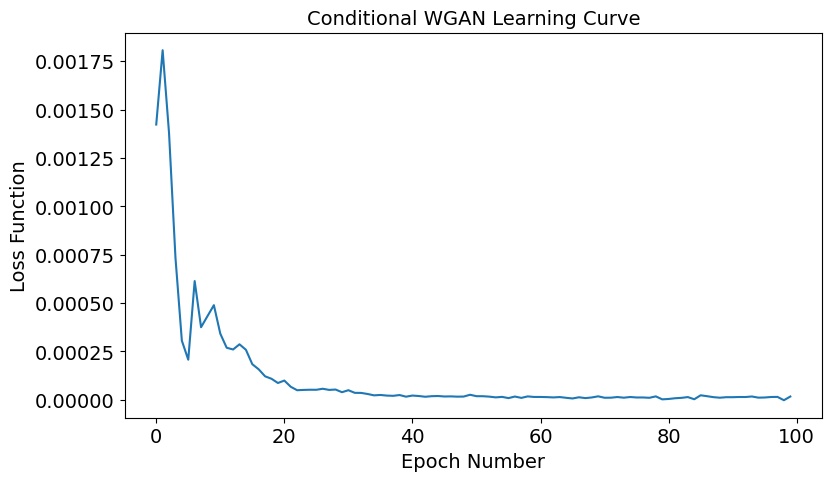

In [ ]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

Генерируем фейновые данные

In [ ]:
X_train = qt.inverse_transform(X_train)
X_test = qt.inverse_transform(X_test)

In [ ]:
X_fake_train = generate(fitter.generator, torch.tensor(y_train, dtype=torch.float, device=DEVICE), latent_dim)
X_fake_train = qt.inverse_transform(X_fake_train.detach().numpy())

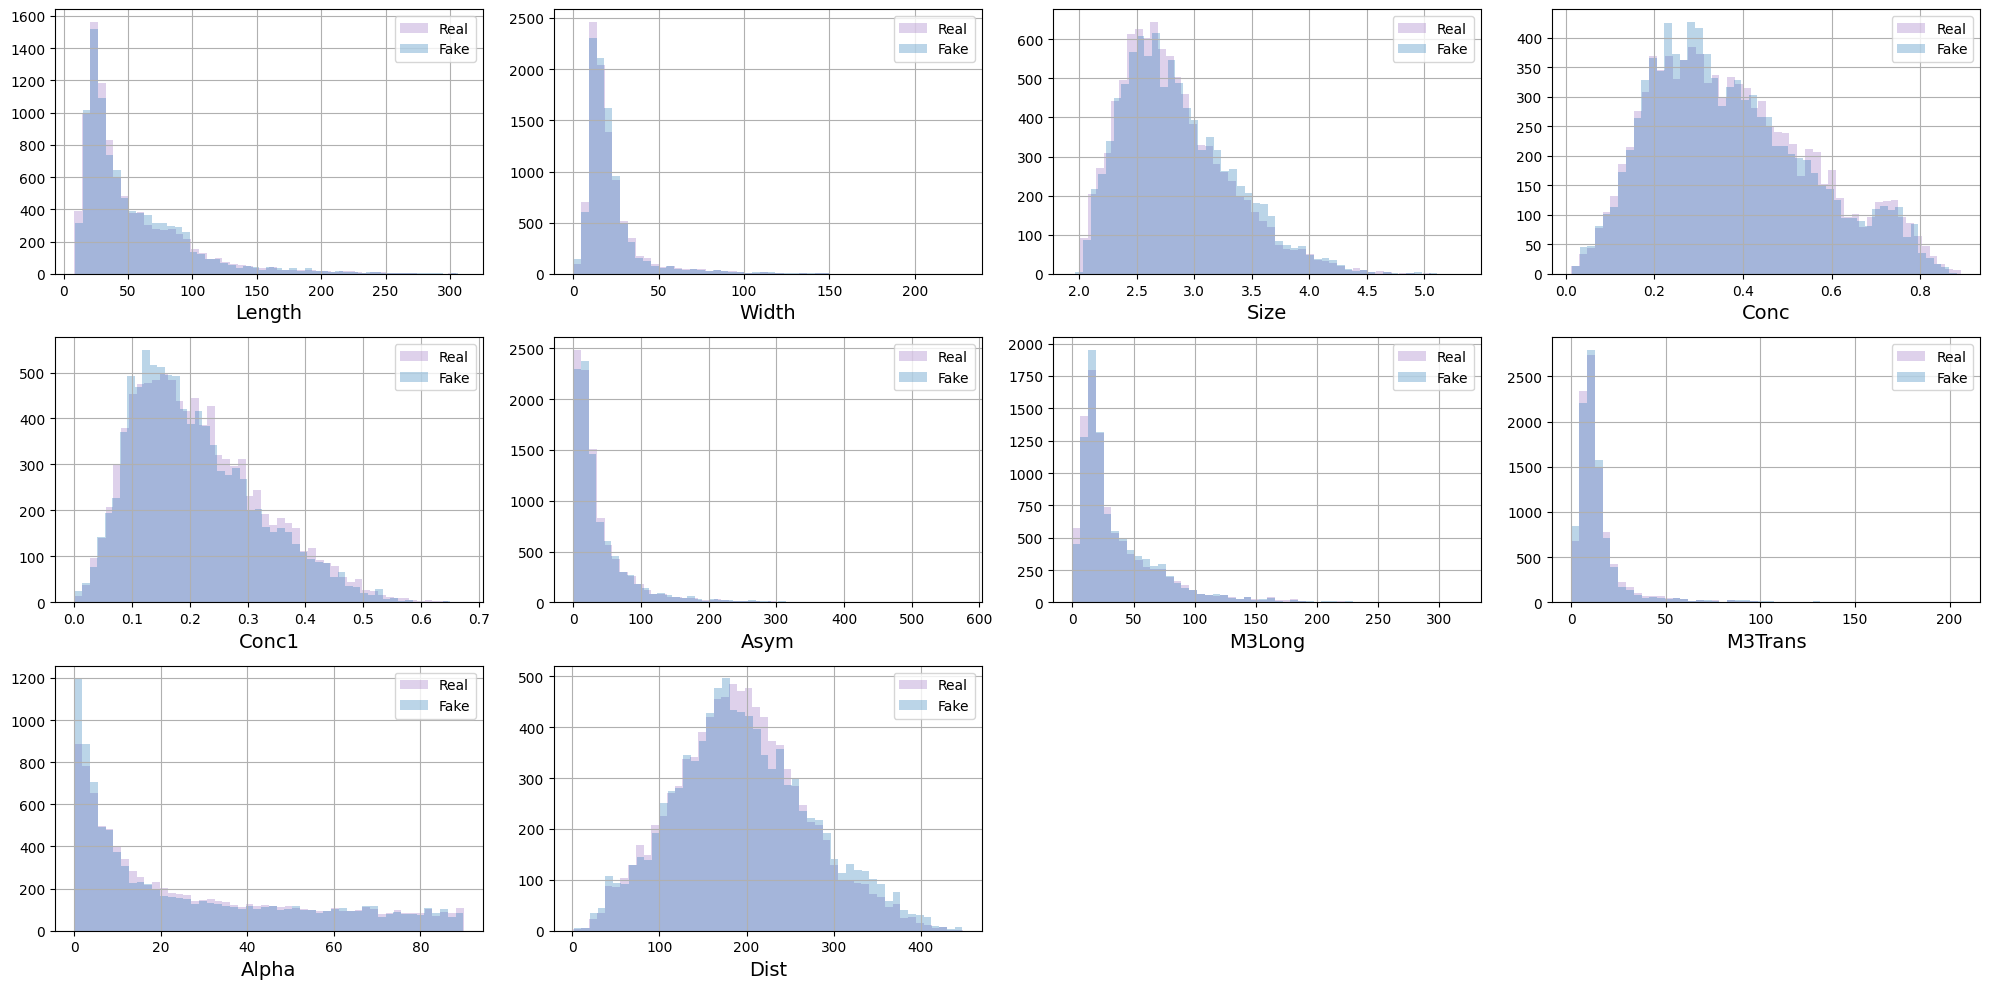

In [ ]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

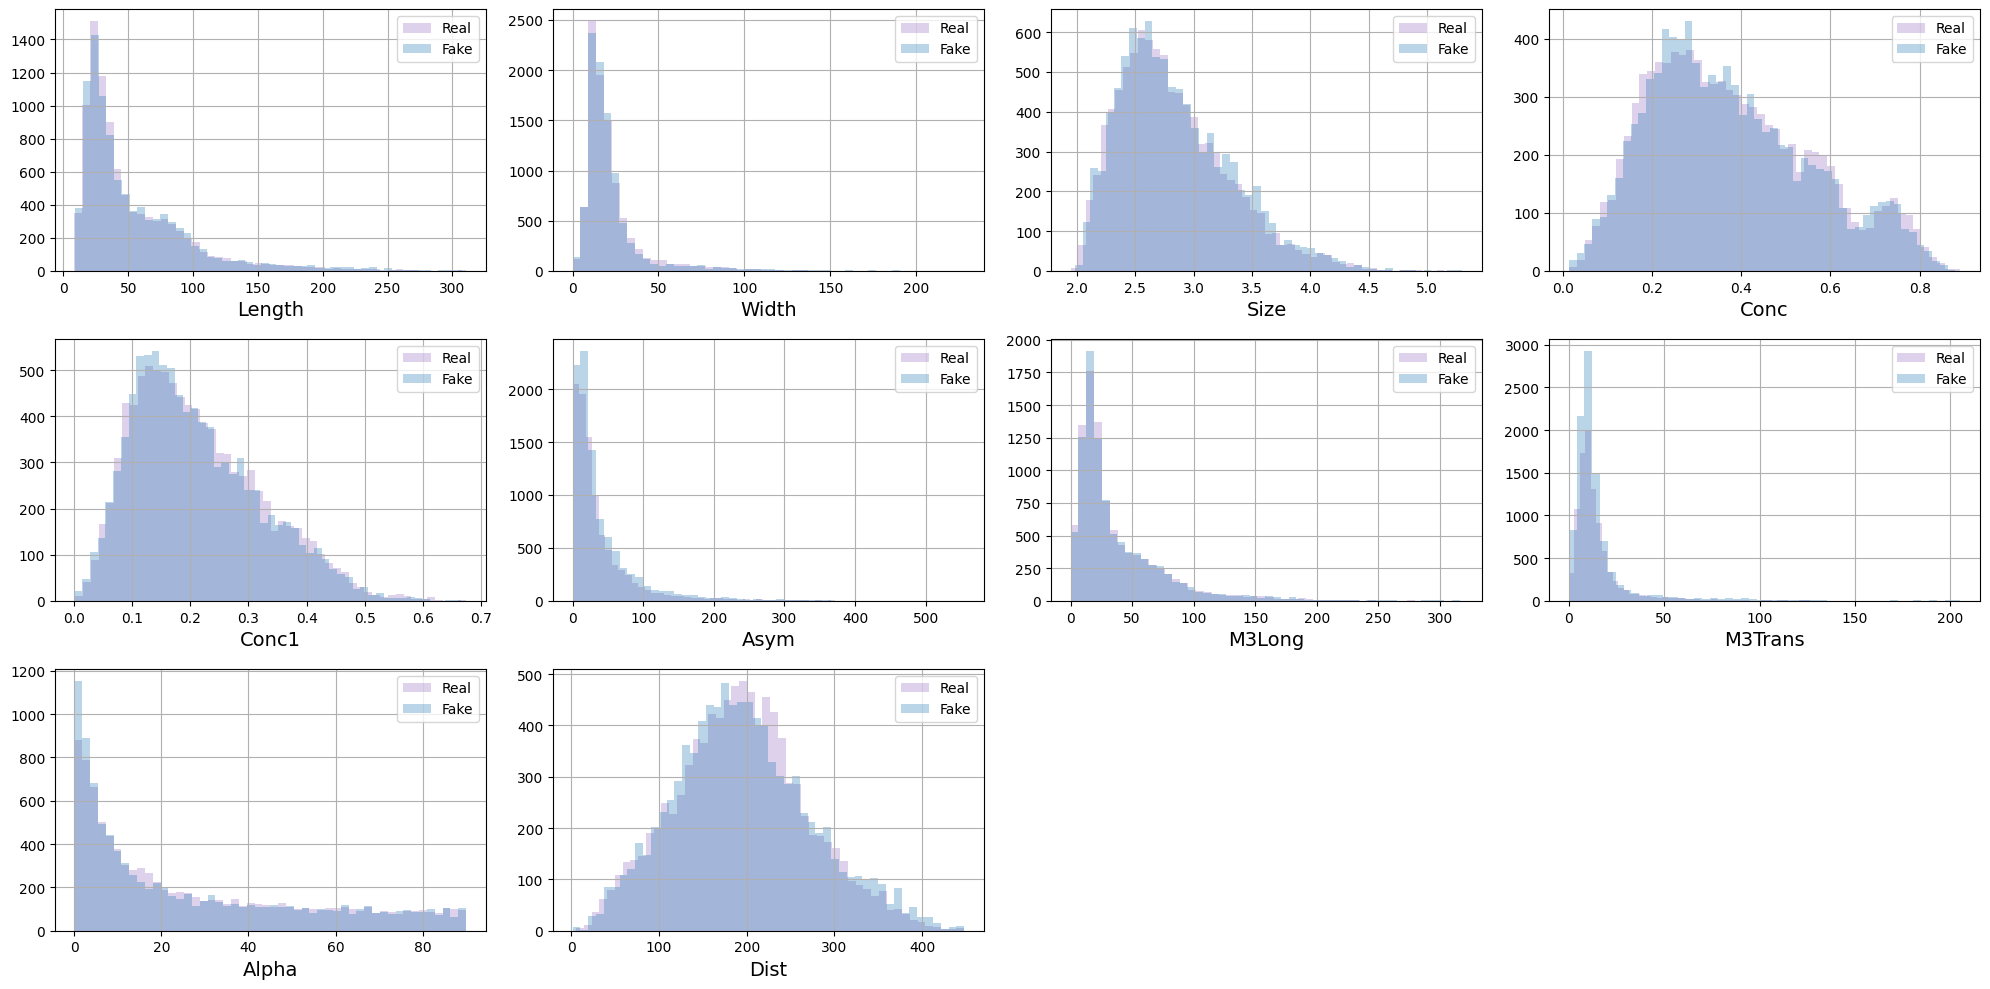

In [ ]:
X_fake_test = generate(fitter.generator, torch.tensor(y_test, dtype=torch.float, device=DEVICE), latent_dim)
X_fake_test = qt.inverse_transform(X_fake_test.detach().numpy())
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

In [ ]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.6804761549356977
